In [1]:
#import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
print ('-This section done-')

import sys
sys.path.append("/Users/omerorhan/Desktop/UCSC/Deep Learning/DeepLearningUCSC/venv/homework/Assignments/") 


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


-This section done-


In [2]:
#getting data
import weather
weather.maybe_download_and_extract()
cities = weather.cities
print(cities)
#%%time
df = weather.load_resampled_data()
print(df.head())

Data has apparently already been downloaded and unpacked.
['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']


                      Aalborg                                    Aarhus  \
                         Temp     Pressure WindSpeed     WindDir   Temp   
DateTime                                                                  
1980-03-01 11:00:00  5.000000  1007.766667      10.2  280.000000    5.0   
1980-03-01 12:00:00  5.000000  1008.000000      10.3  290.000000    5.0   
1980-03-01 13:00:00  5.000000  1008.066667       9.7  290.000000    5.0   
1980-03-01 14:00:00  4.333333  1008.133333      11.1  283.333333    5.0   
1980-03-01 15:00:00  4.000000  1008.200000      11.3  280.000000    5.0   

                                                     Esbjerg           \
                        Pressure WindSpeed WindDir      Temp Pressure   
DateTime                                                                
1980-03-01 11:00:00  1008.300000      15.4   290.0  6.083333      NaN   
1980-03-01 12:00:00  1008.600000      13.4   280.0  6.583333      NaN   
1980-03-01 13:00:00  1008.433333  

-This section done-


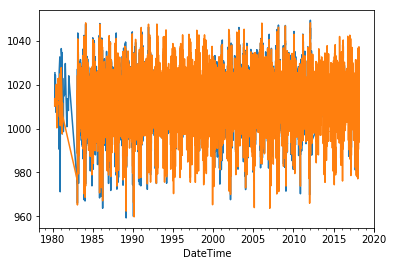

In [3]:
df['Esbjerg']['Pressure'].plot()
df['Roskilde']['Pressure'].plot()
df.values.shape
df.head(1)

df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)
print ('-This section done-')

In [4]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

In [5]:
# Converting Data Frames to Numpy array::::
x_data = df
print("X_Shape::::")
print(type(x_data))
print("Shape:", x_data.shape)

num_data = len(x_data)
print("# of input data ",num_data)
train_split = 1
num_train = int(train_split * num_data)
print("# of Training data: ",num_train)
x_train = x_data[0:num_train]
num_x_signals = x_data.shape[1]
print(num_x_signals)

X_Shape::::
<class 'pandas.core.frame.DataFrame'>
Shape: (333109, 20)
# of input data  333109
# of Training data:  333109
20


In [6]:
# Scaling data
#The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use scikit-learn for this.
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
#Data Generator
print(x_train_scaled.shape)


Min: 0.0
Max: 1.0000000000000002
(333109, 20)


/anaconda3/envs/tf-cpu/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
lookback = 2352 # was 1440. 24 hours per day into 14 days = 168*14 = 2352
step = 6 # Original was 6
delay = 144 # We will predict 1 days in future. hence 24*6 = 144
batch_size = 128
#data—The original array of floating-point data
#lookback—How many timesteps back the input data should go.
#delay—How many timesteps in the future the target should be.
#min_index and max_index—Indices in the data array that delimit which time-
#steps to draw from. This is useful for keeping a segment of the data for valida-
#tion and another for testing.
#shuffle—Whether to shuffle the samples or draw them in chronological order.
#batch_size—The number of samples per batch.
#step—The period, in timesteps, at which you sample data. set it to 1 in
#order to draw one data point every hour.
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=1, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1])) # Size = Batchsize,lookback,20
        targets = np.zeros((len(rows),)) #Size typically Batchsize
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        #print(np.shape(samples))
        #print(np.shape(targets))
        yield samples, targets

        
train_gen = generator(x_train_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=20000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(x_train_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=20001,
                    max_index=30000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(x_train_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=30001,
                    max_index=40000,
                    step=step,
                    batch_size=1)
val_steps = (30000 - 20001 - lookback)



In [16]:
dropout = 0.0
from keras.layers import LSTM
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
# We will be adding LSTM cell from Keras.
#model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model = Sequential()
model.add(LSTM(2, batch_input_shape=(batch_size, lookback// step, x_train_scaled.shape[-1]), stateful=True, dropout=dropout))
#model.add(Dense(1))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit_generator(train_gen,
steps_per_epoch=100, epochs=3, validation_data=val_gen, validation_steps=val_steps)
# make predictions
#trainPredict = model.predict(train_gen, batch_size=batch_size)
#model.reset_states()


Epoch 1/3


  1/100 [..............................] - ETA: 3:19 - loss: 0.2520

  2/100 [..............................] - ETA: 1:49 - loss: 0.2441

  3/100 [..............................] - ETA: 1:18 - loss: 0.2477

  4/100 [>.............................] - ETA: 1:02 - loss: 0.2377

  5/100 [>.............................] - ETA: 53s - loss: 0.2356 

  6/100 [>.............................] - ETA: 46s - loss: 0.2349

  7/100 [=>............................] - ETA: 42s - loss: 0.2317

  8/100 [=>............................] - ETA: 38s - loss: 0.2284

  9/100 [=>............................] - ETA: 35s - loss: 0.2252

 10/100 [==>...........................] - ETA: 33s - loss: 0.2217

 11/100 [==>...........................] - ETA: 31s - loss: 0.2184

 12/100 [==>...........................] - ETA: 30s - loss: 0.2138

 13/100 [==>...........................] - ETA: 28s - loss: 0.2103

 14/100 [===>..........................] - ETA: 27s - loss: 0.2069

 15/100 [===>..........................] - ETA: 26s - loss: 0.2043

 16/100 [===>..........................] - ETA: 25s - loss: 0.1999

 17/100 [====>.........................] - ETA: 24s - loss: 0.1962

 18/100 [====>.........................] - ETA: 24s - loss: 0.1920

 19/100 [====>.........................] - ETA: 23s - loss: 0.1883

 20/100 [=====>........................] - ETA: 22s - loss: 0.1848

 21/100 [=====>........................] - ETA: 21s - loss: 0.1815

 22/100 [=====>........................] - ETA: 21s - loss: 0.1783

 23/100 [=====>........................] - ETA: 20s - loss: 0.1753

 24/100 [======>.......................] - ETA: 20s - loss: 0.1722

 25/100 [======>.......................] - ETA: 19s - loss: 0.1692

 26/100 [======>.......................] - ETA: 19s - loss: 0.1662

 27/100 [=======>......................] - ETA: 19s - loss: 0.1635

KeyboardInterrupt: 

In [12]:
import keras
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
#early_stop = EarlyStopping(patience = 2, mode ='max')
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x_train_scaled.shape[-1])))
#model.add(Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen,
steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=val_steps)
                              #, callbacks = [early_stop])
keras.models.save_model(model,"model.h5")

Epoch 1/10


  1/500 [..............................] - ETA: 6:42 - loss: 0.8830

  4/500 [..............................] - ETA: 1:46 - loss: 8.9155

  7/500 [..............................] - ETA: 1:04 - loss: 5.2861

 10/500 [..............................] - ETA: 52s - loss: 3.8173 

 12/500 [..............................] - ETA: 46s - loss: 3.2021

 14/500 [..............................] - ETA: 41s - loss: 2.9425

 15/500 [..............................] - ETA: 40s - loss: 2.7536

 17/500 [>.............................] - ETA: 38s - loss: 2.4428

 19/500 [>.............................] - ETA: 36s - loss: 2.1971

 21/500 [>.............................] - ETA: 34s - loss: 1.9981

 23/500 [>.............................] - ETA: 33s - loss: 1.8333

 25/500 [>.............................] - ETA: 31s - loss: 1.6955

 27/500 [>.............................] - ETA: 30s - loss: 1.5775

 29/500 [>.............................] - ETA: 29s - loss: 1.4755

 31/500 [>.............................] - ETA: 28s - loss: 1.3867

 33/500 [>.............................] - ETA: 27s - loss: 1.3092

 35/500 [=>............................] - ETA: 27s - loss: 1.2407

 37/500 [=>............................] - ETA: 26s - loss: 1.1795

 39/500 [=>............................] - ETA: 25s - loss: 1.1235

 41/500 [=>............................] - ETA: 25s - loss: 1.0730

 43/500 [=>............................] - ETA: 24s - loss: 1.0274

 45/500 [=>............................] - ETA: 24s - loss: 0.9875

 46/500 [=>............................] - ETA: 24s - loss: 0.9688

 48/500 [=>............................] - ETA: 24s - loss: 0.9317

 50/500 [==>...........................] - ETA: 23s - loss: 0.8977

 52/500 [==>...........................] - ETA: 23s - loss: 0.8667

 54/500 [==>...........................] - ETA: 22s - loss: 0.8388

 56/500 [==>...........................] - ETA: 22s - loss: 0.8120

 58/500 [==>...........................] - ETA: 22s - loss: 0.8087

 60/500 [==>...........................] - ETA: 22s - loss: 0.7873

 62/500 [==>...........................] - ETA: 21s - loss: 0.7641

 64/500 [==>...........................] - ETA: 21s - loss: 0.7427

 66/500 [==>...........................] - ETA: 21s - loss: 0.7225

 68/500 [===>..........................] - ETA: 21s - loss: 0.7037

 70/500 [===>..........................] - ETA: 20s - loss: 0.6858

 72/500 [===>..........................] - ETA: 20s - loss: 0.6693

 74/500 [===>..........................] - ETA: 20s - loss: 0.6536

 76/500 [===>..........................] - ETA: 20s - loss: 0.6384



 78/500 [===>..........................] - ETA: 19s - loss: 0.6241

 80/500 [===>..........................] - ETA: 19s - loss: 0.6106

 82/500 [===>..........................] - ETA: 19s - loss: 0.5975

 84/500 [====>.........................] - ETA: 19s - loss: 0.5851

 86/500 [====>.........................] - ETA: 18s - loss: 0.5733

 88/500 [====>.........................] - ETA: 18s - loss: 0.5621

 90/500 [====>.........................] - ETA: 18s - loss: 0.5513

 92/500 [====>.........................] - ETA: 18s - loss: 0.5410

 94/500 [====>.........................] - ETA: 17s - loss: 0.5312

 96/500 [====>.........................] - ETA: 17s - loss: 0.5217

 98/500 [====>.........................] - ETA: 17s - loss: 0.5128

100/500 [=====>........................] - ETA: 17s - loss: 0.5041

102/500 [=====>........................] - ETA: 17s - loss: 0.4958

104/500 [=====>........................] - ETA: 16s - loss: 0.4880

106/500 [=====>........................] - ETA: 16s - loss: 0.4800

108/500 [=====>........................] - ETA: 16s - loss: 0.4723

110/500 [=====>........................] - ETA: 16s - loss: 0.4651

112/500 [=====>........................] - ETA: 16s - loss: 0.4582

114/500 [=====>........................] - ETA: 16s - loss: 0.4521

116/500 [=====>........................] - ETA: 15s - loss: 0.4457

118/500 [======>.......................] - ETA: 15s - loss: 0.4393

120/500 [======>.......................] - ETA: 15s - loss: 0.4335

122/500 [======>.......................] - ETA: 15s - loss: 0.4278

124/500 [======>.......................] - ETA: 15s - loss: 0.4221

126/500 [======>.......................] - ETA: 15s - loss: 0.4165

128/500 [======>.......................] - ETA: 14s - loss: 0.4112

130/500 [======>.......................] - ETA: 14s - loss: 0.4059

132/500 [======>.......................] - ETA: 14s - loss: 0.4008

134/500 [=======>......................] - ETA: 14s - loss: 0.3960

136/500 [=======>......................] - ETA: 14s - loss: 0.3915

138/500 [=======>......................] - ETA: 14s - loss: 0.3870

140/500 [=======>......................] - ETA: 14s - loss: 0.3824

142/500 [=======>......................] - ETA: 14s - loss: 0.3778

144/500 [=======>......................] - ETA: 13s - loss: 0.3735

146/500 [=======>......................] - ETA: 13s - loss: 0.3697

148/500 [=======>......................] - ETA: 13s - loss: 0.3656

150/500 [========>.....................] - ETA: 13s - loss: 0.3617

152/500 [========>.....................] - ETA: 13s - loss: 0.3579

154/500 [========>.....................] - ETA: 13s - loss: 0.3543

156/500 [========>.....................] - ETA: 13s - loss: 0.3508

158/500 [========>.....................]

 - ETA: 13s - loss: 0.3473

160/500 [========>.....................] - ETA: 13s - loss: 0.3438

162/500 [========>.....................] - ETA: 12s - loss: 0.3405

164/500 [========>.....................] - ETA: 12s - loss: 0.3373

166/500 [========>.....................] - ETA: 12s - loss: 0.3342

168/500 [=========>....................] - ETA: 12s - loss: 0.3311

170/500 [=========>....................] - ETA: 12s - loss: 0.3282

172/500 [=========>....................] - ETA: 12s - loss: 0.3252

174/500 [=========>....................] - ETA: 12s - loss: 0.3222

176/500 [=========>....................] - ETA: 12s - loss: 0.3193

178/500 [=========>....................] - ETA: 12s - loss: 0.3165

180/500 [=========>....................] - ETA: 11s - loss: 0.3137

182/500 [=========>....................] - ETA: 11s - loss: 0.3111

184/500 [==========>...................] - ETA: 11s - loss: 0.3087

186/500 [==========>...................] - ETA: 11s - loss: 0.3062

188/500 [==========>...................] - ETA: 11s - loss: 0.3037

190/500 [==========>...................] - ETA: 11s - loss: 0.3013

192/500 [==========>...................] - ETA: 11s - loss: 0.2988

194/500 [==========>...................] - ETA: 11s - loss: 0.2963

196/500 [==========>...................] - ETA: 11s - loss: 0.2941

198/500 [==========>...................] - ETA: 11s - loss: 0.2920

200/500 [===========>..................] - ETA: 11s - loss: 0.2898

202/500 [===========>..................] - ETA: 10s - loss: 0.2877

204/500 [===========>..................] - ETA: 10s - loss: 0.2856

206/500 [===========>..................] - ETA: 10s - loss: 0.2835

208/500 [===========>..................] - ETA: 10s - loss: 0.2815

210/500 [===========>..................] - ETA: 10s - loss: 0.2796

212/500 [===========>..................] - ETA: 10s - loss: 0.2775

214/500 [===========>..................] - ETA: 10s - loss: 0.2756

216/500 [===========>..................] - ETA: 10s - loss: 0.2738

218/500 [============>.................] - ETA: 10s - loss: 0.2719

220/500 [============>.................] - ETA: 10s - loss: 0.2700

222/500 [============>.................] - ETA: 10s - loss: 0.2682

223/500 [============>.................] - ETA: 10s - loss: 0.2673

224/500 [============>.................] - ETA: 10s - loss: 0.2665

225/500 [============>.................] - ETA: 10s - loss: 0.2657

227/500 [============>.................] - ETA: 10s - loss: 0.2640

229/500 [============>.................] - ETA: 9s - loss: 0.2624 

231/500 [============>.................] - ETA: 9s - loss: 0.2609

233/500 [============>.................] - ETA: 9s - loss: 0.2592

235/500 [=============>................] - ETA: 9s - loss: 0.2575

237/500 [=============>................] - ETA: 9s - loss: 0.2559

239/500 [=============>................] - ETA: 9s - loss: 0.2545

241/500 [=============>................] - ETA: 9s - loss: 0.2529

243/500 [=============>................] - ETA: 9s - loss: 0.2512

245/500 [=============>................] - ETA: 9s - loss: 0.2497

246/500 [=============>................] - ETA: 9s - loss: 0.2490

248/500 [=============>................] - ETA: 9s - loss: 0.2477

250/500 [==============>...............] - ETA: 9s - loss: 0.2463

251/500 [==============>...............] - ETA: 9s - loss: 0.2456

252/500 [==============>...............] - ETA: 9s - loss: 0.2449

254/500 [==============>...............] - ETA: 9s - loss: 0.2435

255/500 [==============>...............] - ETA: 9s - loss: 0.2428

257/500 [==============>...............] - ETA: 9s - loss: 0.2416

259/500 [==============>...............] - ETA: 9s - loss: 0.2402

260/500 [==============>...............] - ETA: 9s - loss: 0.2395

261/500 [==============>...............] - ETA: 9s - loss: 0.2388

262/500 [==============>...............] - ETA: 9s - loss: 0.2382

264/500 [==============>...............] - ETA: 8s - loss: 0.2371

265/500 [==============>...............] - ETA: 8s - loss: 0.2365

267/500 [===============>..............] - ETA: 8s - loss: 0.2353

269/500 [===============>..............] - ETA: 8s - loss: 0.2340

271/500 [===============>..............] - ETA: 8s - loss: 0.2329

272/500 [===============>..............] - ETA: 8s - loss: 0.2323

273/500 [===============>..............] - ETA: 8s - loss: 0.2317

274/500 [===============>..............] - ETA: 8s - loss: 0.2311

275/500 [===============>..............] - ETA: 8s - loss: 0.2305

277/500 [===============>..............] - ETA: 8s - loss: 0.2294

279/500 [===============>..............] - ETA: 8s - loss: 0.2283

281/500 [===============>..............] - ETA: 8s - loss: 0.2272

283/500 [===============>..............] - ETA: 8s - loss: 0.2261

285/500 [================>.............] - ETA: 8s - loss: 0.2250

287/500 [================>.............] - ETA: 8s - loss: 0.2240

289/500 [================>.............] - ETA: 8s - loss: 0.2229

291/500 [================>.............] - ETA: 7s - loss: 0.2217

293/500 [================>.............] - ETA: 7s - loss: 0.2206

295/500 [================>.............] - ETA: 7s - loss: 0.2198

297/500 [================>.............] - ETA: 7s - loss: 0.2187

299/500 [================>.............] - ETA: 7s - loss: 0.2177

301/500 [=================>............] - ETA: 7s - loss: 0.2168

304/500 [=================>............] - ETA: 7s - loss: 0.2153

306/500 [=================>............] - ETA: 7s - loss: 0.2143

308/500 [=================>............] - ETA: 7s - loss: 0.2133

310/500 [=================>............] - ETA: 7s - loss: 0.2125

312/500 [=================>............] - ETA: 6s - loss: 0.2115

314/500 [=================>............] - ETA: 6s - loss: 0.2107

316/500 [=================>............] - ETA: 6s - loss: 0.2098

318/500 [==================>...........] - ETA: 6s - loss: 0.2090

320/500 [==================>...........] - ETA: 6s - loss: 0.2082

322/500 [==================>...........] - ETA: 6s - loss: 0.2073

324/500 [==================>...........] - ETA: 6s - loss: 0.2065

326/500 [==================>...........] - ETA: 6s - loss: 0.2056

328/500 [==================>...........] - ETA: 6s - loss: 0.2048

330/500 [==================>...........] - ETA: 6s - loss: 0.2039

332/500 [==================>...........] - ETA: 6s - loss: 0.2031

334/500 [===================>..........] - ETA: 6s - loss: 0.2023

336/500 [===================>..........] - ETA: 5s - loss: 0.2016

338/500 [===================>..........] - ETA: 5s - loss: 0.2008

340/500 [===================>..........] - ETA: 5s - loss: 0.2000

342/500 [===================>..........] - ETA: 5s - loss: 0.1992

344/500 [===================>..........] - ETA: 5s - loss: 0.1984

346/500 [===================>..........] - ETA: 5s - loss: 0.1977

348/500 [===================>..........] - ETA: 5s - loss: 0.1969

350/500 [====================>.........] - ETA: 5s - loss: 0.1962

352/500 [====================>.........] - ETA: 5s - loss: 0.1956

354/500 [====================>.........] - ETA: 5s - loss: 0.1949

356/500 [====================>.........] - ETA: 5s - loss: 0.1941

358/500 [====================>.........] - ETA: 5s - loss: 0.1935

360/500 [====================>.........] - ETA: 5s - loss: 0.1927

362/500 [====================>.........] - ETA: 4s - loss: 0.1920

364/500 [====================>.........] - ETA: 4s - loss: 0.1914

366/500 [====================>.........] - ETA: 4s - loss: 0.1908

368/500 [=====================>........] - ETA: 4s - loss: 0.1901

370/500 [=====================>........] - ETA: 4s - loss: 0.1895

372/500 [=====================>........] - ETA: 4s - loss: 0.1888

374/500 [=====================>........] - ETA: 4s - loss: 0.1882

376/500 [=====================>........] - ETA: 4s - loss: 0.1876

378/500 [=====================>........] - ETA: 4s - loss: 0.1869

380/500 [=====================>........] - ETA: 4s - loss: 0.1863

382/500 [=====================>........] - ETA: 4s - loss: 0.1857

384/500 [======================>.......] - ETA: 4s - loss: 0.1850

386/500 [======================>.......] - ETA: 4s - loss: 0.1844

388/500 [======================>.......] - ETA: 3s - loss: 0.1838

391/500 [======================>.......] - ETA: 3s - loss: 0.1830

393/500 [======================>.......] - ETA: 3s - loss: 0.1824

395/500 [======================>.......] - ETA: 3s - loss: 0.1818

397/500 [======================>.......] - ETA: 3s - loss: 0.1813

399/500 [======================>.......] - ETA: 3s - loss: 0.1807

401/500 [=======================>......] - ETA: 3s - loss: 0.1801

403/500 [=======================>......] - ETA: 3s - loss: 0.1796

405/500 [=======================>......] - ETA: 3s - loss: 0.1790

407/500 [=======================>......] - ETA: 3s - loss: 0.1785

410/500 [=======================>......] - ETA: 3s - loss: 0.1777

412/500 [=======================>......] - ETA: 3s - loss: 0.1771

414/500 [=======================>......] - ETA: 3s - loss: 0.1766

416/500 [=======================>......] - ETA: 2s - loss: 0.1761

418/500 [========================>.....] - ETA: 2s - loss: 0.1756

420/500 [========================>.....] - ETA: 2s - loss: 0.1750

422/500 [========================>.....] - ETA: 2s - loss: 0.1746

424/500 [========================>.....] - ETA: 2s - loss: 0.1741

426/500 [========================>.....] - ETA: 2s - loss: 0.1736

428/500 [========================>.....] - ETA: 2s - loss: 0.1730

430/500 [========================>.....] - ETA: 2s - loss: 0.1726

432/500 [========================>.....] - ETA: 2s - loss: 0.1721

434/500 [=========================>....] - ETA: 2s - loss: 0.1717

436/500 [=========================>....] - ETA: 2s - loss: 0.1711

438/500 [=========================>....] - ETA: 2s - loss: 0.1707

440/500 [=========================>....] - ETA: 2s - loss: 0.1701

443/500 [=========================>....] - ETA: 1s - loss: 0.1694

445/500 [=========================>....] - ETA: 1s - loss: 0.1689

447/500 [=========================>....] - ETA: 1s - loss: 0.1685

449/500 [=========================>....] - ETA: 1s - loss: 0.1681

451/500 [==========================>...] - ETA: 1s - loss: 0.1676

453/500 [==========================>...] - ETA: 1s - loss: 0.1672

455/500 [==========================>...] - ETA: 1s - loss: 0.1667

457/500 [==========================>...] - ETA: 1s - loss: 0.1663

459/500 [==========================>...] - ETA: 1s - loss: 0.1659

461/500 [==========================>...] - ETA: 1s - loss: 0.1655

463/500 [==========================>...] - ETA: 1s - loss: 0.1651

465/500 [==========================>...] - ETA: 1s - loss: 0.1647

467/500 [===========================>..] - ETA: 1s - loss: 0.1643

469/500 [===========================>..] - ETA: 1s - loss: 0.1639

471/500 [===========================>..] - ETA: 1s - loss: 0.1634

473/500 [===========================>..] - ETA: 0s - loss: 0.1630

475/500 [===========================>..] - ETA: 0s - loss: 0.1626

477/500 [===========================>..] - ETA: 0s - loss: 0.1622

479/500 [===========================>..] - ETA: 0s - loss: 0.1618

481/500 [===========================>..] - ETA: 0s - loss: 0.1614

483/500 [===========================>..] - ETA: 0s - loss: 0.1609

485/500 [============================>.] - ETA: 0s - loss: 0.1606

487/500 [============================>.] - ETA: 0s - loss: 0.1602

489/500 [============================>.] - ETA: 0s - loss: 0.1599

491/500 [============================>.] - ETA: 0s - loss: 0.1594

493/500 [============================>.] - ETA: 0s - loss: 0.1591

495/500 [============================>.] - ETA: 0s - loss: 0.1587

497/500 [============================>.] - ETA: 0s - loss: 0.1583

499/500 [============================>.] - ETA: 0s - loss: 0.1579

500/500 [==============================] - 166s 331ms/step - loss: 0.1578 - val_loss: 0.0666


Epoch 2/10
  1/500 [..............................] - ETA: 11s - loss: 0.0581

  4/500 [..............................] - ETA: 10s - loss: 0.0682

  7/500 [..............................] - ETA: 10s - loss: 0.0671

 11/500 [..............................] - ETA: 9s - loss: 0.0692 

 14/500 [..............................] - ETA: 9s - loss: 0.0677

 15/500 [..............................] - ETA: 10s - loss: 0.0677



 17/500 [>.............................] - ETA: 11s - loss: 0.0681

 18/500 [>.............................] - ETA: 12s - loss: 0.0699



 19/500 [>.............................] - ETA: 13s - loss: 0.0698

 20/500 [>.............................] - ETA: 14s - loss: 0.0696

 21/500 [>.............................] - ETA: 15s - loss: 0.0692

 22/500 [>.............................] - ETA: 15s - loss: 0.0693

 24/500 [>.............................] - ETA: 15s - loss: 0.0675

 26/500 [>.............................] - ETA: 15s - loss: 0.0663

 28/500 [>.............................] - ETA: 15s - loss: 0.0648

 30/500 [>.............................] - ETA: 15s - loss: 0.0664

 32/500 [>.............................] - ETA: 15s - loss: 0.0674

 34/500 [=>............................] - ETA: 15s - loss: 0.0669

 36/500 [=>............................] - ETA: 15s - loss: 0.0664

 38/500 [=>............................] - ETA: 15s - loss: 0.0666

 40/500 [=>............................] - ETA: 15s - loss: 0.0660

 42/500 [=>............................] - ETA: 15s - loss: 0.0658

 44/500 [=>............................] - ETA: 15s - loss: 0.0665

 46/500 [=>............................] - ETA: 15s - loss: 0.0672

 48/500 [=>............................] - ETA: 15s - loss: 0.0668

 50/500 [==>...........................] - ETA: 15s - loss: 0.0673

 52/500 [==>...........................] - ETA: 14s - loss: 0.0672

 54/500 [==>...........................] - ETA: 14s - loss: 0.0673

 56/500 [==>...........................] - ETA: 14s - loss: 0.0671

 58/500 [==>...........................] - ETA: 14s - loss: 0.0672

 60/500 [==>...........................] - ETA: 14s - loss: 0.0672

 62/500 [==>...........................] - ETA: 14s - loss: 0.0673

 64/500 [==>...........................] - ETA: 14s - loss: 0.0670

 66/500 [==>...........................] - ETA: 14s - loss: 0.0673

 68/500 [===>..........................] - ETA: 14s - loss: 0.0674

 70/500 [===>..........................] - ETA: 14s - loss: 0.0674

 72/500 [===>..........................] - ETA: 14s - loss: 0.0674

 74/500 [===>..........................] - ETA: 14s - loss: 0.0671

 76/500 [===>..........................] - ETA: 14s - loss: 0.0671

 78/500 [===>..........................] - ETA: 13s - loss: 0.0671

 80/500 [===>..........................] - ETA: 13s - loss: 0.0668

 82/500 [===>..........................] - ETA: 13s - loss: 0.0665

 84/500 [====>.........................] - ETA: 13s - loss: 0.0662

 86/500 [====>.........................] - ETA: 13s - loss: 0.0667

 88/500 [====>.........................] - ETA: 13s - loss: 0.0668

 90/500 [====>.........................] - ETA: 13s - loss: 0.0670

 92/500 [====>.........................] - ETA: 13s - loss: 0.0671

 94/500 [====>.........................] - ETA: 13s - loss: 0.0669

 96/500 [====>.........................] - ETA: 13s - loss: 0.0666

 98/500 [====>.........................] - ETA: 13s - loss: 0.0667

100/500 [=====>........................] - ETA: 13s - loss: 0.0666

102/500 [=====>........................] - ETA: 13s - loss: 0.0665

104/500 [=====>........................] - ETA: 12s - loss: 0.0667

106/500 [=====>........................] - ETA: 12s - loss: 0.0667

108/500 [=====>........................] - ETA: 12s - loss: 0.0667

110/500 [=====>........................] - ETA: 12s - loss: 0.0669

112/500 [=====>........................] - ETA: 12s - loss: 0.0669



114/500 [=====>........................] - ETA: 12s - loss: 0.0668

116/500 [=====>........................] - ETA: 12s - loss: 0.0667

118/500 [======>.......................] - ETA: 12s - loss: 0.0668

120/500 [======>.......................] - ETA: 12s - loss: 0.0667

122/500 [======>.......................] - ETA: 12s - loss: 0.0667

124/500 [======>.......................] - ETA: 12s - loss: 0.0667

126/500 [======>.......................] - ETA: 12s - loss: 0.0666

128/500 [======>.......................] - ETA: 12s - loss: 0.0664

130/500 [======>.......................] - ETA: 12s - loss: 0.0666

132/500 [======>.......................] - ETA: 12s - loss: 0.0666

134/500 [=======>......................] - ETA: 12s - loss: 0.0665

136/500 [=======>......................] - ETA: 11s - loss: 0.0665

138/500 [=======>......................] - ETA: 11s - loss: 0.0663

140/500 [=======>......................] - ETA: 11s - loss: 0.0662

142/500 [=======>......................] - ETA: 11s - loss: 0.0662

144/500 [=======>......................] - ETA: 11s - loss: 0.0662

146/500 [=======>......................] - ETA: 11s - loss: 0.0662

148/500 [=======>......................] - ETA: 11s - loss: 0.0662

150/500 [========>.....................] - ETA: 11s - loss: 0.0662

152/500 [========>.....................] - ETA: 11s - loss: 0.0663

154/500 [========>.....................] - ETA: 11s - loss: 0.0661

156/500 [========>.....................] - ETA: 11s - loss: 0.0662

158/500 [========>.....................] - ETA: 11s - loss: 0.0662

160/500 [========>.....................] - ETA: 11s - loss: 0.0660

162/500 [========>.....................] - ETA: 11s - loss: 0.0659

164/500 [========>.....................] - ETA: 11s - loss: 0.0658

166/500 [========>.....................] - ETA: 11s - loss: 0.0658

168/500 [=========>....................] - ETA: 11s - loss: 0.0660

170/500 [=========>....................] - ETA: 11s - loss: 0.0660

172/500 [=========>....................] - ETA: 11s - loss: 0.0662

174/500 [=========>....................] - ETA: 11s - loss: 0.0663

176/500 [=========>....................] - ETA: 10s - loss: 0.0662

178/500 [=========>....................] - ETA: 10s - loss: 0.0663

180/500 [=========>....................] - ETA: 10s - loss: 0.0661

182/500 [=========>....................] - ETA: 10s - loss: 0.0659

184/500 [==========>...................] - ETA: 10s - loss: 0.0660



186/500 [==========>...................] - ETA: 10s - loss: 0.0661

188/500 [==========>...................] - ETA: 10s - loss: 0.0661

190/500 [==========>...................]

 - ETA: 10s - loss: 0.0662

192/500 [==========>...................] - ETA: 10s - loss: 0.0662

194/500 [==========>...................] - ETA: 10s - loss: 0.0662

196/500 [==========>...................] - ETA: 10s - loss: 0.0662

198/500 [==========>...................] - ETA: 10s - loss: 0.0663

200/500 [===========>..................] - ETA: 10s - loss: 0.0661

202/500 [===========>..................] - ETA: 10s - loss: 0.0660

204/500 [===========>..................] - ETA: 9s - loss: 0.0660 

206/500 [===========>..................] - ETA: 9s - loss: 0.0659

208/500 [===========>..................] - ETA: 9s - loss: 0.0657

210/500 [===========>..................] - ETA: 9s - loss: 0.0657

212/500 [===========>..................] - ETA: 9s - loss: 0.0659

214/500 [===========>..................] - ETA: 9s - loss: 0.0658

216/500 [===========>..................] - ETA: 9s - loss: 0.0660

218/500 [============>.................] - ETA: 9s - loss: 0.0660

220/500 [============>.................] - ETA: 9s - loss: 0.0659

222/500 [============>.................] - ETA: 9s - loss: 0.0660

224/500 [============>.................] - ETA: 9s - loss: 0.0660

226/500 [============>.................] - ETA: 9s - loss: 0.0659

228/500 [============>.................] - ETA: 9s - loss: 0.0660

230/500 [============>.................] - ETA: 9s - loss: 0.0659

232/500 [============>.................] - ETA: 9s - loss: 0.0659

234/500 [=============>................] - ETA: 8s - loss: 0.0658

236/500 [=============>................] - ETA: 8s - loss: 0.0659

238/500 [=============>................] - ETA: 8s - loss: 0.0658

240/500 [=============>................] - ETA: 8s - loss: 0.0658

242/500 [=============>................] - ETA: 8s - loss: 0.0658

244/500 [=============>................] - ETA: 8s - loss: 0.0657

246/500 [=============>................] - ETA: 8s - loss: 0.0657

248/500 [=============>................] - ETA: 8s - loss: 0.0658

250/500 [==============>...............] - ETA: 8s - loss: 0.0657

252/500 [==============>...............] - ETA: 8s - loss: 0.0657

254/500 [==============>...............] - ETA: 8s - loss: 0.0657

256/500 [==============>...............] - ETA: 8s - loss: 0.0656

258/500 [==============>...............] - ETA: 8s - loss: 0.0655



260/500 [==============>...............] - ETA: 8s - loss: 0.0654

262/500 [==============>...............] - ETA: 8s - loss: 0.0655

263/500 [==============>...............] - ETA: 8s - loss: 0.0656

265/500 [==============>...............] - ETA: 8s - loss: 0.0656

267/500 [===============>..............] - ETA: 7s - loss: 0.0656

269/500 [===============>..............] - ETA: 7s - loss: 0.0656

270/500 [===============>..............] - ETA: 7s - loss: 0.0657

272/500 [===============>..............] - ETA: 7s - loss: 0.0656

274/500 [===============>..............] - ETA: 7s - loss: 0.0656

276/500 [===============>..............] - ETA: 7s - loss: 0.0656

278/500 [===============>..............] - ETA: 7s - loss: 0.0656

280/500 [===============>..............] - ETA: 7s - loss: 0.0655

282/500 [===============>..............] - ETA: 7s - loss: 0.0655

284/500 [================>.............] - ETA: 7s - loss: 0.0655

286/500 [================>.............] - ETA: 7s - loss: 0.0655



288/500 [================>.............] - ETA: 7s - loss: 0.0654

290/500 [================>.............] - ETA: 7s - loss: 0.0653

292/500 [================>.............] - ETA: 7s - loss: 0.0654

294/500 [================>.............] - ETA: 7s - loss: 0.0655

296/500 [================>.............] - ETA: 6s - loss: 0.0655

298/500 [================>.............] - ETA: 6s - loss: 0.0655

300/500 [=================>............] - ETA: 6s - loss: 0.0655

302/500 [=================>............] - ETA: 6s - loss: 0.0655

304/500 [=================>............] - ETA: 6s - loss: 0.0655

306/500 [=================>............] - ETA: 6s - loss: 0.0654

308/500 [=================>............] - ETA: 6s - loss: 0.0654

310/500 [=================>............] - ETA: 6s - loss: 0.0653

312/500 [=================>............] - ETA: 6s - loss: 0.0653

314/500 [=================>............] - ETA: 6s - loss: 0.0654

316/500 [=================>............] - ETA: 6s - loss: 0.0654

318/500 [==================>...........] - ETA: 6s - loss: 0.0654

320/500 [==================>...........] - ETA: 6s - loss: 0.0654

322/500 [==================>...........] - ETA: 6s - loss: 0.0654

324/500 [==================>...........] - ETA: 6s - loss: 0.0653

326/500 [==================>...........] - ETA: 5s - loss: 0.0653



328/500 [==================>...........] - ETA: 5s - loss: 0.0653

330/500 [==================>...........] - ETA: 5s - loss: 0.0653

332/500 [==================>...........] - ETA: 5s - loss: 0.0652

334/500 [===================>..........] - ETA: 5s - loss: 0.0653

336/500 [===================>..........] - ETA: 5s - loss: 0.0654

338/500 [===================>..........] - ETA: 5s - loss: 0.0653

340/500 [===================>..........] - ETA: 5s - loss: 0.0652

342/500 [===================>..........] - ETA: 5s - loss: 0.0651

344/500 [===================>..........] - ETA: 5s - loss: 0.0650

346/500 [===================>..........] - ETA: 5s - loss: 0.0652

348/500 [===================>..........] - ETA: 5s - loss: 0.0652

350/500 [====================>.........] - ETA: 5s - loss: 0.0652

352/500 [====================>.........] - ETA: 5s - loss: 0.0652

354/500 [====================>.........] - ETA: 4s - loss: 0.0652

356/500 [====================>.........] - ETA: 4s - loss: 0.0652

358/500 [====================>.........] - ETA: 4s - loss: 0.0651

360/500 [====================>.........] - ETA: 4s - loss: 0.0650

362/500 [====================>.........] - ETA: 4s - loss: 0.0650

364/500 [====================>.........] - ETA: 4s - loss: 0.0651

366/500 [====================>.........] - ETA: 4s - loss: 0.0651

368/500 [=====================>........] - ETA: 4s - loss: 0.0651

370/500 [=====================>........] - ETA: 4s - loss: 0.0651

372/500 [=====================>........] - ETA: 4s - loss: 0.0651

374/500 [=====================>........] - ETA: 4s - loss: 0.0651

376/500 [=====================>........] - ETA: 4s - loss: 0.0651

378/500 [=====================>........] - ETA: 4s - loss: 0.0651



380/500 [=====================>........] - ETA: 4s - loss: 0.0650

382/500 [=====================>........] - ETA: 4s - loss: 0.0650

384/500 [======================>.......] - ETA: 3s - loss: 0.0650

386/500 [======================>.......] - ETA: 3s - loss: 0.0650

388/500 [======================>.......] - ETA: 3s - loss: 0.0650

389/500 [======================>.......] - ETA: 3s - loss: 0.0650

391/500 [======================>.......] - ETA: 3s - loss: 0.0650

392/500 [======================>.......] - ETA: 3s - loss: 0.0650

393/500 [======================>.......] - ETA: 3s - loss: 0.0651

395/500 [======================>.......] - ETA: 3s - loss: 0.0650

397/500 [======================>.......] - ETA: 3s - loss: 0.0650

398/500 [======================>.......] - ETA: 3s - loss: 0.0650

400/500 [=======================>......] - ETA: 3s - loss: 0.0650

402/500 [=======================>......] - ETA: 3s - loss: 0.0650

404/500 [=======================>......] - ETA: 3s - loss: 0.0650

406/500 [=======================>......] - ETA: 3s - loss: 0.0650

408/500 [=======================>......] - ETA: 3s - loss: 0.0649

410/500 [=======================>......] - ETA: 3s - loss: 0.0649

412/500 [=======================>......] - ETA: 3s - loss: 0.0648

414/500 [=======================>......] - ETA: 2s - loss: 0.0648

416/500 [=======================>......] - ETA: 2s - loss: 0.0649

418/500 [========================>.....] - ETA: 2s - loss: 0.0649

420/500 [========================>.....] - ETA: 2s - loss: 0.0649

422/500 [========================>.....] - ETA: 2s - loss: 0.0649

424/500 [========================>.....] - ETA: 2s - loss: 0.0649

426/500 [========================>.....] - ETA: 2s - loss: 0.0649

428/500 [========================>.....] - ETA: 2s - loss: 0.0648

430/500 [========================>.....] - ETA: 2s - loss: 0.0648

432/500 [========================>.....] - ETA: 2s - loss: 0.0648

434/500 [=========================>....] - ETA: 2s - loss: 0.0648

436/500 [=========================>....] - ETA: 2s - loss: 0.0648

438/500 [=========================>....] - ETA: 2s - loss: 0.0647

440/500 [=========================>....] - ETA: 2s - loss: 0.0648

442/500 [=========================>....] - ETA: 2s - loss: 0.0648

444/500 [=========================>....] - ETA: 1s - loss: 0.0648

446/500 [=========================>....] - ETA: 1s - loss: 0.0647

448/500 [=========================>....] - ETA: 1s - loss: 0.0647

450/500 [==========================>...] - ETA: 1s - loss: 0.0647

452/500 [==========================>...] - ETA: 1s - loss: 0.0647

454/500 [==========================>...] - ETA: 1s - loss: 0.0648

456/500 [==========================>...] - ETA: 1s - loss: 0.0648

458/500 [==========================>...] - ETA: 1s - loss: 0.0647

460/500 [==========================>...] - ETA: 1s - loss: 0.0647

462/500 [==========================>...] - ETA: 1s - loss: 0.0646

464/500 [==========================>...] - ETA: 1s - loss: 0.0646

466/500 [==========================>...] - ETA: 1s - loss: 0.0647

468/500 [===========================>..] - ETA: 1s - loss: 0.0647

470/500 [===========================>..] - ETA: 1s - loss: 0.0647

472/500 [===========================>..] - ETA: 0s - loss: 0.0646

474/500 [===========================>..] - ETA: 0s - loss: 0.0646

476/500 [===========================>..] - ETA: 0s - loss: 0.0646

478/500 [===========================>..] - ETA: 0s - loss: 0.0646



480/500 [===========================>..] - ETA: 0s - loss: 0.0647

482/500 [===========================>..] - ETA: 0s - loss: 0.0647

484/500 [============================>.] - ETA: 0s - loss: 0.0647

486/500 [============================>.] - ETA: 0s - loss: 0.0647

488/500 [============================>.] - ETA: 0s - loss: 0.0647

490/500 [============================>.] - ETA: 0s - loss: 0.0647

492/500 [============================>.] - ETA: 0s - loss: 0.0646

494/500 [============================>.] - ETA: 0s - loss: 0.0646

496/500 [============================>.] - ETA: 0s - loss: 0.0646

498/500 [============================>.] - ETA: 0s - loss: 0.0646

500/500 [==============================] - 187s 374ms/step - loss: 0.0647 - val_loss: 0.0680


Epoch 3/10
  1/500 [..............................] - ETA: 13s - loss: 0.0609

  4/500 [..............................] - ETA: 10s - loss: 0.0547

  7/500 [..............................] - ETA: 9s - loss: 0.0619 

 11/500 [..............................] - ETA: 9s - loss: 0.0621

 14/500 [..............................] - ETA: 8s - loss: 0.0610

 16/500 [..............................] - ETA: 11s - loss: 0.0623

 18/500 [>.............................] - ETA: 12s - loss: 0.0633

 19/500 [>.............................] - ETA: 13s - loss: 0.0629

 20/500 [>.............................] - ETA: 13s - loss: 0.0626

 22/500 [>.............................] - ETA: 14s - loss: 0.0630

 23/500 [>.............................] - ETA: 14s - loss: 0.0631

 25/500 [>.............................] - ETA: 14s - loss: 0.0632

 27/500 [>.............................] - ETA: 14s - loss: 0.0630

 29/500 [>.............................] - ETA: 14s - loss: 0.0633

 31/500 [>.............................] - ETA: 14s - loss: 0.0632

 33/500 [>.............................] - ETA: 14s - loss: 0.0638

 35/500 [=>............................] - ETA: 14s - loss: 0.0631

 37/500 [=>............................] - ETA: 14s - loss: 0.0625

 39/500 [=>............................] - ETA: 14s - loss: 0.0630

 41/500 [=>............................] - ETA: 14s - loss: 0.0634

 43/500 [=>............................] - ETA: 14s - loss: 0.0630

 45/500 [=>............................] - ETA: 13s - loss: 0.0625

 47/500 [=>............................] - ETA: 13s - loss: 0.0621

 49/500 [=>............................] - ETA: 13s - loss: 0.0626

 51/500 [==>...........................] - ETA: 13s - loss: 0.0630

 53/500 [==>...........................] - ETA: 13s - loss: 0.0633

 55/500 [==>...........................] - ETA: 13s - loss: 0.0634

 57/500 [==>...........................] - ETA: 13s - loss: 0.0631

 59/500 [==>...........................] - ETA: 13s - loss: 0.0629

 61/500 [==>...........................] - ETA: 13s - loss: 0.0629

 63/500 [==>...........................] - ETA: 13s - loss: 0.0628

 65/500 [==>...........................] - ETA: 13s - loss: 0.0625

 67/500 [===>..........................] - ETA: 13s - loss: 0.0629

 69/500 [===>..........................] - ETA: 13s - loss: 0.0630

 71/500 [===>..........................] - ETA: 13s - loss: 0.0632

 73/500 [===>..........................] - ETA: 13s - loss: 0.0630

 75/500 [===>..........................] - ETA: 13s - loss: 0.0627

 77/500 [===>..........................] - ETA: 13s - loss: 0.0629

 79/500 [===>..........................] - ETA: 13s - loss: 0.0629

 81/500 [===>..........................] - ETA: 13s - loss: 0.0632

 83/500 [===>..........................] - ETA: 13s - loss: 0.0633

 85/500 [====>.........................] - ETA: 12s - loss: 0.0631

 87/500 [====>.........................] - ETA: 12s - loss: 0.0632

 89/500 [====>.........................] - ETA: 12s - loss: 0.0632

 91/500 [====>.........................] - ETA: 12s - loss: 0.0629

 93/500 [====>.........................] - ETA: 12s - loss: 0.0629

 95/500 [====>.........................] - ETA: 12s - loss: 0.0630

 97/500 [====>.........................] - ETA: 12s - loss: 0.0631

 99/500 [====>.........................] - ETA: 12s - loss: 0.0632

101/500 [=====>........................] - ETA: 12s - loss: 0.0630

103/500 [=====>........................] - ETA: 12s - loss: 0.0632

105/500 [=====>........................] - ETA: 12s - loss: 0.0630

107/500 [=====>........................] - ETA: 12s - loss: 0.0628

109/500 [=====>........................] - ETA: 12s - loss: 0.0627

111/500 [=====>........................] - ETA: 12s - loss: 0.0628

113/500 [=====>........................] - ETA: 12s - loss: 0.0630

115/500 [=====>........................] - ETA: 12s - loss: 0.0631

117/500 [======>.......................] - ETA: 11s - loss: 0.0631

119/500 [======>.......................] - ETA: 11s - loss: 0.0631

121/500 [======>.......................] - ETA: 11s - loss: 0.0629

123/500 [======>.......................] - ETA: 11s - loss: 0.0629

125/500 [======>.......................] - ETA: 11s - loss: 0.0630

127/500 [======>.......................] - ETA: 11s - loss: 0.0630

129/500 [======>.......................] - ETA: 11s - loss: 0.0630

131/500 [======>.......................] - ETA: 11s - loss: 0.0629

133/500 [======>.......................] - ETA: 11s - loss: 0.0627

135/500 [=======>......................] - ETA: 11s - loss: 0.0627

137/500 [=======>......................] - ETA: 11s - loss: 0.0630

139/500 [=======>......................] - ETA: 11s - loss: 0.0630

141/500 [=======>......................] - ETA: 11s - loss: 0.0630

143/500 [=======>......................] - ETA: 11s - loss: 0.0629

145/500 [=======>......................] - ETA: 11s - loss: 0.0628

147/500 [=======>......................] - ETA: 11s - loss: 0.0628

149/500 [=======>......................] - ETA: 10s - loss: 0.0629

151/500 [========>.....................] - ETA: 10s - loss: 0.0630

153/500 [========>.....................] - ETA: 10s - loss: 0.0628

155/500 [========>.....................] - ETA: 10s - loss: 0.0628

157/500 [========>.....................] - ETA: 10s - loss: 0.0627

159/500 [========>.....................] - ETA: 10s - loss: 0.0628

161/500 [========>.....................] - ETA: 10s - loss: 0.0627



163/500 [========>.....................] - ETA: 10s - loss: 0.0628

165/500 [========>.....................] - ETA: 10s - loss: 0.0629

167/500 [=========>....................] - ETA: 10s - loss: 0.0629

169/500 [=========>....................] - ETA: 10s - loss: 0.0628

171/500 [=========>....................] - ETA: 10s - loss: 0.0628

173/500 [=========>....................] - ETA: 10s - loss: 0.0629

175/500 [=========>....................] - ETA: 10s - loss: 0.0628

177/500 [=========>....................] - ETA: 10s - loss: 0.0626

179/500 [=========>....................] - ETA: 10s - loss: 0.0625

181/500 [=========>....................] - ETA: 10s - loss: 0.0625

183/500 [=========>....................] - ETA: 9s - loss: 0.0627 

185/500 [==========>...................] - ETA: 9s - loss: 0.0628

187/500 [==========>...................] - ETA: 9s - loss: 0.0628

189/500 [==========>...................] - ETA: 9s - loss: 0.0628

191/500 [==========>...................] - ETA: 9s - loss: 0.0628

193/500 [==========>...................] - ETA: 9s - loss: 0.0628

195/500 [==========>...................] - ETA: 9s - loss: 0.0628

197/500 [==========>...................] - ETA: 9s - loss: 0.0628

199/500 [==========>...................] - ETA: 9s - loss: 0.0628

201/500 [===========>..................] - ETA: 9s - loss: 0.0628

203/500 [===========>..................] - ETA: 9s - loss: 0.0628

205/500 [===========>..................] - ETA: 9s - loss: 0.0628

207/500 [===========>..................] - ETA: 9s - loss: 0.0628

209/500 [===========>..................] - ETA: 9s - loss: 0.0628

211/500 [===========>..................] - ETA: 9s - loss: 0.0627

213/500 [===========>..................] - ETA: 9s - loss: 0.0626

215/500 [===========>..................] - ETA: 8s - loss: 0.0626

217/500 [============>.................] - ETA: 8s - loss: 0.0627

219/500 [============>.................] - ETA: 8s - loss: 0.0628

221/500 [============>.................] - ETA: 8s - loss: 0.0627

223/500 [============>.................] - ETA: 8s - loss: 0.0627

225/500 [============>.................] - ETA: 8s - loss: 0.0628

227/500 [============>.................] - ETA: 8s - loss: 0.0628



229/500 [============>.................] - ETA: 8s - loss: 0.0627

231/500 [============>.................] - ETA: 8s - loss: 0.0627

233/500 [============>.................] - ETA: 8s - loss: 0.0627

235/500 [=============>................] - ETA: 8s - loss: 0.0627

237/500 [=============>................] - ETA: 8s - loss: 0.0628

239/500 [=============>................] - ETA: 8s - loss: 0.0627

241/500 [=============>................] - ETA: 8s - loss: 0.0628



243/500 [=============>................] - ETA: 8s - loss: 0.0627



245/500 [=============>................] - ETA: 8s - loss: 0.0627

247/500 [=============>................] - ETA: 8s - loss: 0.0627



249/500 [=============>................] - ETA: 7s - loss: 0.0628

251/500 [==============>...............] - ETA: 7s - loss: 0.0627

253/500 [==============>...............] - ETA: 7s - loss: 0.0627

255/500 [==============>...............] - ETA: 7s - loss: 0.0628

257/500 [==============>...............] - ETA: 7s - loss: 0.0627

259/500 [==============>...............] - ETA: 7s - loss: 0.0626

261/500 [==============>...............] - ETA: 7s - loss: 0.0626

263/500 [==============>...............] - ETA: 7s - loss: 0.0626

265/500 [==============>...............] - ETA: 7s - loss: 0.0626

267/500 [===============>..............] - ETA: 7s - loss: 0.0625

269/500 [===============>..............] - ETA: 7s - loss: 0.0625

271/500 [===============>..............] - ETA: 7s - loss: 0.0625

274/500 [===============>..............] - ETA: 7s - loss: 0.0626

276/500 [===============>..............] - ETA: 7s - loss: 0.0625



278/500 [===============>..............] - ETA: 7s - loss: 0.0626

280/500 [===============>..............] - ETA: 6s - loss: 0.0626

282/500 [===============>..............] - ETA: 6s - loss: 0.0626

284/500 [================>.............] - ETA: 6s - loss: 0.0626

286/500 [================>.............] - ETA: 6s - loss: 0.0625

288/500 [================>.............] - ETA: 6s - loss: 0.0624

290/500 [================>.............] - ETA: 6s - loss: 0.0625

292/500 [================>.............] - ETA: 6s - loss: 0.0625

294/500 [================>.............] - ETA: 6s - loss: 0.0626

296/500 [================>.............] - ETA: 6s - loss: 0.0626

298/500 [================>.............] - ETA: 6s - loss: 0.0626

300/500 [=================>............] - ETA: 6s - loss: 0.0625

302/500 [=================>............] - ETA: 6s - loss: 0.0625

304/500 [=================>............] - ETA: 6s - loss: 0.0626

306/500 [=================>............] - ETA: 6s - loss: 0.0625

308/500 [=================>............] - ETA: 6s - loss: 0.0625

310/500 [=================>............] - ETA: 6s - loss: 0.0625

312/500 [=================>............] - ETA: 5s - loss: 0.0625

314/500 [=================>............] - ETA: 5s - loss: 0.0625

316/500 [=================>............] - ETA: 5s - loss: 0.0625

318/500 [==================>...........] - ETA: 5s - loss: 0.0624

320/500 [==================>...........] - ETA: 5s - loss: 0.0624

322/500 [==================>...........] - ETA: 5s - loss: 0.0625

324/500 [==================>...........] - ETA: 5s - loss: 0.0624

326/500 [==================>...........] - ETA: 5s - loss: 0.0624

328/500 [==================>...........] - ETA: 5s - loss: 0.0624

330/500 [==================>...........] - ETA: 5s - loss: 0.0624

332/500 [==================>...........] - ETA: 5s - loss: 0.0624

334/500 [===================>..........] - ETA: 5s - loss: 0.0624

336/500 [===================>..........] - ETA: 5s - loss: 0.0624

338/500 [===================>..........] - ETA: 5s - loss: 0.0624

340/500 [===================>..........] - ETA: 5s - loss: 0.0624

342/500 [===================>..........] - ETA: 5s - loss: 0.0624

344/500 [===================>..........] - ETA: 4s - loss: 0.0624

346/500 [===================>..........] - ETA: 4s - loss: 0.0624

348/500 [===================>..........] - ETA: 4s - loss: 0.0623

350/500 [====================>.........] - ETA: 4s - loss: 0.0624



352/500 [====================>.........] - ETA: 4s - loss: 0.0624

354/500 [====================>.........] - ETA: 4s - loss: 0.0624

356/500 [====================>.........] - ETA: 4s - loss: 0.0624

358/500 [====================>.........] - ETA: 4s - loss: 0.0624

360/500 [====================>.........] - ETA: 4s - loss: 0.0624

362/500 [====================>.........] - ETA: 4s - loss: 0.0623

364/500 [====================>.........] - ETA: 4s - loss: 0.0623

366/500 [====================>.........] - ETA: 4s - loss: 0.0623

368/500 [=====================>........] - ETA: 4s - loss: 0.0623

370/500 [=====================>........] - ETA: 4s - loss: 0.0623

372/500 [=====================>........] - ETA: 4s - loss: 0.0623

374/500 [=====================>........] - ETA: 4s - loss: 0.0622

376/500 [=====================>........] - ETA: 3s - loss: 0.0622

378/500 [=====================>........] - ETA: 3s - loss: 0.0623

380/500 [=====================>........] - ETA: 3s - loss: 0.0623

382/500 [=====================>........] - ETA: 3s - loss: 0.0623

384/500 [======================>.......] - ETA: 3s - loss: 0.0623

386/500 [======================>.......] - ETA: 3s - loss: 0.0622

388/500 [======================>.......] - ETA: 3s - loss: 0.0622

390/500 [======================>.......] - ETA: 3s - loss: 0.0622

392/500 [======================>.......] - ETA: 3s - loss: 0.0622

394/500 [======================>.......] - ETA: 3s - loss: 0.0623

396/500 [======================>.......] - ETA: 3s - loss: 0.0623

398/500 [======================>.......] - ETA: 3s - loss: 0.0622

400/500 [=======================>......] - ETA: 3s - loss: 0.0622

402/500 [=======================>......] - ETA: 3s - loss: 0.0622

404/500 [=======================>......] - ETA: 3s - loss: 0.0622

406/500 [=======================>......] - ETA: 2s - loss: 0.0622

408/500 [=======================>......] - ETA: 2s - loss: 0.0621

410/500 [=======================>......] - ETA: 2s - loss: 0.0621

412/500 [=======================>......] - ETA: 2s - loss: 0.0621

414/500 [=======================>......] - ETA: 2s - loss: 0.0621

416/500 [=======================>......] - ETA: 2s - loss: 0.0621

418/500 [========================>.....] - ETA: 2s - loss: 0.0621

420/500 [========================>.....] - ETA: 2s - loss: 0.0621

422/500 [========================>.....] - ETA: 2s - loss: 0.0621

424/500 [========================>.....] - ETA: 2s - loss: 0.0621

426/500 [========================>.....] - ETA: 2s - loss: 0.0621

428/500 [========================>.....] - ETA: 2s - loss: 0.0622

430/500 [========================>.....] - ETA: 2s - loss: 0.0621

432/500 [========================>.....] - ETA: 2s - loss: 0.0621

434/500 [=========================>....] - ETA: 2s - loss: 0.0621

436/500 [=========================>....] - ETA: 2s - loss: 0.0620

438/500 [=========================>....] - ETA: 1s - loss: 0.0620

440/500 [=========================>....] - ETA: 1s - loss: 0.0620

442/500 [=========================>....] - ETA: 1s - loss: 0.0621

444/500 [=========================>....] - ETA: 1s - loss: 0.0621

446/500 [=========================>....] - ETA: 1s - loss: 0.0621

448/500 [=========================>....] - ETA: 1s - loss: 0.0621



450/500 [==========================>...] - ETA: 1s - loss: 0.0621

452/500 [==========================>...] - ETA: 1s - loss: 0.0620

454/500 [==========================>...] - ETA: 1s - loss: 0.0620



456/500 [==========================>...] - ETA: 1s - loss: 0.0620

458/500 [==========================>...] - ETA: 1s - loss: 0.0620

460/500 [==========================>...] - ETA: 1s - loss: 0.0620

462/500 [==========================>...] - ETA: 1s - loss: 0.0620

464/500 [==========================>...] - ETA: 1s - loss: 0.0620

466/500 [==========================>...] - ETA: 1s - loss: 0.0620

468/500 [===========================>..] - ETA: 1s - loss: 0.0620

470/500 [===========================>..] - ETA: 0s - loss: 0.0620

472/500 [===========================>..] - ETA: 0s - loss: 0.0620

473/500 [===========================>..] - ETA: 0s - loss: 0.0619

475/500 [===========================>..] - ETA: 0s - loss: 0.0620

477/500 [===========================>..] - ETA: 0s - loss: 0.0620

479/500 [===========================>..] - ETA: 0s - loss: 0.0620

481/500 [===========================>..] - ETA: 0s - loss: 0.0620

483/500 [===========================>..] - ETA: 0s - loss: 0.0620

485/500 [============================>.] - ETA: 0s - loss: 0.0620

487/500 [============================>.] - ETA: 0s - loss: 0.0620

489/500 [============================>.] - ETA: 0s - loss: 0.0620

491/500 [============================>.] - ETA: 0s - loss: 0.0620

493/500 [============================>.] - ETA: 0s - loss: 0.0619

495/500 [============================>.] - ETA: 0s - loss: 0.0619

497/500 [============================>.] - ETA: 0s - loss: 0.0619

499/500 [============================>.] - ETA: 0s - loss: 0.0619

500/500 [==============================] - 185s 371ms/step - loss: 0.0619 - val_loss: 0.0578


Epoch 4/10
  1/500 [..............................] - ETA: 13s - loss: 0.0654

  4/500 [..............................] - ETA: 11s - loss: 0.0683

  7/500 [..............................] - ETA: 10s - loss: 0.0597

 11/500 [..............................] - ETA: 8s - loss: 0.0608 

 14/500 [..............................] - ETA: 9s - loss: 0.0617

 15/500 [..............................] - ETA: 10s - loss: 0.0620

 16/500 [..............................] - ETA: 11s - loss: 0.0627

 18/500 [>.............................] - ETA: 12s - loss: 0.0620

 20/500 [>.............................] - ETA: 13s - loss: 0.0622

 22/500 [>.............................] - ETA: 13s - loss: 0.0624

 23/500 [>.............................] - ETA: 14s - loss: 0.0621

 24/500 [>.............................] - ETA: 14s - loss: 0.0616

 26/500 [>.............................] - ETA: 14s - loss: 0.0609

 28/500 [>.............................] - ETA: 14s - loss: 0.0608

 30/500 [>.............................] - ETA: 14s - loss: 0.0610

 32/500 [>.............................] - ETA: 14s - loss: 0.0610

 34/500 [=>............................] - ETA: 14s - loss: 0.0606

 36/500 [=>............................] - ETA: 14s - loss: 0.0605

 38/500 [=>............................] - ETA: 14s - loss: 0.0607

 40/500 [=>............................] - ETA: 14s - loss: 0.0605

 42/500 [=>............................] - ETA: 14s - loss: 0.0606

 44/500 [=>............................] - ETA: 14s - loss: 0.0601

 46/500 [=>............................] - ETA: 14s - loss: 0.0598

 48/500 [=>............................] - ETA: 14s - loss: 0.0599

 50/500 [==>...........................] - ETA: 14s - loss: 0.0599

 52/500 [==>...........................] - ETA: 14s - loss: 0.0602

 54/500 [==>...........................] - ETA: 14s - loss: 0.0604

 56/500 [==>...........................] - ETA: 14s - loss: 0.0600

 58/500 [==>...........................] - ETA: 14s - loss: 0.0599

 60/500 [==>...........................] - ETA: 14s - loss: 0.0600

 62/500 [==>...........................] - ETA: 13s - loss: 0.0601



 64/500 [==>...........................] - ETA: 13s - loss: 0.0603

 66/500 [==>...........................] - ETA: 13s - loss: 0.0602



 68/500 [===>..........................] - ETA: 13s - loss: 0.0602

 70/500 [===>..........................] - ETA: 13s - loss: 0.0603

 72/500 [===>..........................] - ETA: 13s - loss: 0.0601

 74/500 [===>..........................] - ETA: 13s - loss: 0.0601

 75/500 [===>..........................] - ETA: 13s - loss: 0.0601

 77/500 [===>..........................] - ETA: 13s - loss: 0.0600

 79/500 [===>..........................] - ETA: 13s - loss: 0.0602

 81/500 [===>..........................] - ETA: 13s - loss: 0.0605

 83/500 [===>..........................] - ETA: 13s - loss: 0.0605

 85/500 [====>.........................] - ETA: 13s - loss: 0.0603

 87/500 [====>.........................] - ETA: 13s - loss: 0.0600

 89/500 [====>.........................] - ETA: 13s - loss: 0.0599

 91/500 [====>.........................] - ETA: 13s - loss: 0.0600

 93/500 [====>.........................] - ETA: 13s - loss: 0.0602

 95/500 [====>.........................] - ETA: 13s - loss: 0.0602

 97/500 [====>.........................] - ETA: 13s - loss: 0.0602

 99/500 [====>.........................] - ETA: 13s - loss: 0.0601

101/500 [=====>........................] - ETA: 13s - loss: 0.0602

103/500 [=====>........................] - ETA: 13s - loss: 0.0603



105/500 [=====>........................] - ETA: 13s - loss: 0.0603



107/500 [=====>........................] - ETA: 13s - loss: 0.0605

109/500 [=====>........................] - ETA: 13s - loss: 0.0606

111/500 [=====>........................] - ETA: 13s - loss: 0.0606

113/500 [=====>........................] - ETA: 13s - loss: 0.0606

115/500 [=====>........................] - ETA: 12s - loss: 0.0605

117/500 [======>.......................] - ETA: 12s - loss: 0.0602

119/500 [======>.......................] - ETA: 12s - loss: 0.0599

121/500 [======>.......................] - ETA: 12s - loss: 0.0601

123/500 [======>.......................] - ETA: 12s - loss: 0.0601

125/500 [======>.......................] - ETA: 12s - loss: 0.0600

127/500 [======>.......................] - ETA: 12s - loss: 0.0601

129/500 [======>.......................] - ETA: 12s - loss: 0.0602

131/500 [======>.......................] - ETA: 12s - loss: 0.0602

133/500 [======>.......................] - ETA: 12s - loss: 0.0600

135/500 [=======>......................] - ETA: 12s - loss: 0.0599

137/500 [=======>......................] - ETA: 12s - loss: 0.0602

139/500 [=======>......................] - ETA: 12s - loss: 0.0602

141/500 [=======>......................] - ETA: 11s - loss: 0.0601

143/500 [=======>......................] - ETA: 11s - loss: 0.0602

145/500 [=======>......................] - ETA: 11s - loss: 0.0600

147/500 [=======>......................] - ETA: 11s - loss: 0.0599

149/500 [=======>......................] - ETA: 11s - loss: 0.0598

150/500 [========>.....................] - ETA: 11s - loss: 0.0597

152/500 [========>.....................] - ETA: 11s - loss: 0.0596

154/500 [========>.....................] - ETA: 11s - loss: 0.0596

156/500 [========>.....................] - ETA: 11s - loss: 0.0596

158/500 [========>.....................] - ETA: 11s - loss: 0.0598

160/500 [========>.....................] - ETA: 11s - loss: 0.0599

162/500 [========>.....................] - ETA: 11s - loss: 0.0598

164/500 [========>.....................] - ETA: 11s - loss: 0.0596



166/500 [========>.....................] - ETA: 11s - loss: 0.0597



168/500 [=========>....................] - ETA: 11s - loss: 0.0597

170/500 [=========>....................] - ETA: 11s - loss: 0.0598

172/500 [=========>....................] - ETA: 10s - loss: 0.0597

174/500 [=========>....................] - ETA: 10s - loss: 0.0597

176/500 [=========>....................] - ETA: 10s - loss: 0.0596

178/500 [=========>....................] - ETA: 10s - loss: 0.0598

180/500 [=========>....................] - ETA: 10s - loss: 0.0597

182/500 [=========>....................] - ETA: 10s - loss: 0.0599

184/500 [==========>...................] - ETA: 10s - loss: 0.0600

186/500 [==========>...................] - ETA: 10s - loss: 0.0600



188/500 [==========>...................] - ETA: 10s - loss: 0.0600

190/500 [==========>...................] - ETA: 10s - loss: 0.0601

192/500 [==========>...................] - ETA: 10s - loss: 0.0600

194/500 [==========>...................] - ETA: 10s - loss: 0.0600

196/500 [==========>...................] - ETA: 10s - loss: 0.0598

198/500 [==========>...................] - ETA: 10s - loss: 0.0597

200/500 [===========>..................] - ETA: 9s - loss: 0.0595 

202/500 [===========>..................] - ETA: 9s - loss: 0.0597

204/500 [===========>..................] - ETA: 9s - loss: 0.0599

206/500 [===========>..................] - ETA: 9s - loss: 0.0599

208/500 [===========>..................] - ETA: 9s - loss: 0.0599

210/500 [===========>..................] - ETA: 9s - loss: 0.0600

212/500 [===========>..................] - ETA: 9s - loss: 0.0600

214/500 [===========>..................] - ETA: 9s - loss: 0.0599

216/500 [===========>..................] - ETA: 9s - loss: 0.0598

218/500 [============>.................] - ETA: 9s - loss: 0.0599

220/500 [============>.................] - ETA: 9s - loss: 0.0598

222/500 [============>.................] - ETA: 9s - loss: 0.0598

224/500 [============>.................] - ETA: 9s - loss: 0.0598

226/500 [============>.................] - ETA: 9s - loss: 0.0599

228/500 [============>.................] - ETA: 9s - loss: 0.0599

230/500 [============>.................] - ETA: 8s - loss: 0.0599

232/500 [============>.................] - ETA: 8s - loss: 0.0599

234/500 [=============>................] - ETA: 8s - loss: 0.0599

236/500 [=============>................] - ETA: 8s - loss: 0.0599

238/500 [=============>................] - ETA: 8s - loss: 0.0599

240/500 [=============>................] - ETA: 8s - loss: 0.0598

242/500 [=============>................] - ETA: 8s - loss: 0.0598

244/500 [=============>................] - ETA: 8s - loss: 0.0598

246/500 [=============>................] - ETA: 8s - loss: 0.0599

248/500 [=============>................] - ETA: 8s - loss: 0.0599

250/500 [==============>...............] - ETA: 8s - loss: 0.0599

252/500 [==============>...............] - ETA: 8s - loss: 0.0599

254/500 [==============>...............] - ETA: 8s - loss: 0.0598

256/500 [==============>...............] - ETA: 8s - loss: 0.0598



258/500 [==============>...............] - ETA: 7s - loss: 0.0598

260/500 [==============>...............] - ETA: 7s - loss: 0.0599

262/500 [==============>...............] - ETA: 7s - loss: 0.0599

264/500 [==============>...............] - ETA: 7s - loss: 0.0599

266/500 [==============>...............] - ETA: 7s - loss: 0.0599

268/500 [===============>..............] - ETA: 7s - loss: 0.0599

270/500 [===============>..............] - ETA: 7s - loss: 0.0598

272/500 [===============>..............] - ETA: 7s - loss: 0.0598

274/500 [===============>..............] - ETA: 7s - loss: 0.0599

276/500 [===============>..............] - ETA: 7s - loss: 0.0599

278/500 [===============>..............] - ETA: 7s - loss: 0.0599

280/500 [===============>..............] - ETA: 7s - loss: 0.0599

282/500 [===============>..............] - ETA: 7s - loss: 0.0598

284/500 [================>.............] - ETA: 7s - loss: 0.0598

286/500 [================>.............] - ETA: 7s - loss: 0.0598

288/500 [================>.............] - ETA: 6s - loss: 0.0598

290/500 [================>.............] - ETA: 6s - loss: 0.0598

292/500 [================>.............] - ETA: 6s - loss: 0.0597

294/500 [================>.............] - ETA: 6s - loss: 0.0598

296/500 [================>.............] - ETA: 6s - loss: 0.0597

298/500 [================>.............] - ETA: 6s - loss: 0.0597

300/500 [=================>............] - ETA: 6s - loss: 0.0596

302/500 [=================>............] - ETA: 6s - loss: 0.0596

304/500 [=================>............] - ETA: 6s - loss: 0.0597

306/500 [=================>............] - ETA: 6s - loss: 0.0597

308/500 [=================>............] - ETA: 6s - loss: 0.0598

310/500 [=================>............] - ETA: 6s - loss: 0.0598

312/500 [=================>............] - ETA: 6s - loss: 0.0598

314/500 [=================>............] - ETA: 6s - loss: 0.0598

315/500 [=================>............] - ETA: 6s - loss: 0.0598

317/500 [==================>...........] - ETA: 6s - loss: 0.0598

319/500 [==================>...........] - ETA: 5s - loss: 0.0598

321/500 [==================>...........] - ETA: 5s - loss: 0.0598

323/500 [==================>...........] - ETA: 5s - loss: 0.0598

325/500 [==================>...........] - ETA: 5s - loss: 0.0598

327/500 [==================>...........] - ETA: 5s - loss: 0.0598

329/500 [==================>...........] - ETA: 5s - loss: 0.0598

331/500 [==================>...........] - ETA: 5s - loss: 0.0598

333/500 [==================>...........] - ETA: 5s - loss: 0.0598

335/500 [===================>..........] - ETA: 5s - loss: 0.0598

337/500 [===================>..........] - ETA: 5s - loss: 0.0597

339/500 [===================>..........] - ETA: 5s - loss: 0.0597

341/500 [===================>..........] - ETA: 5s - loss: 0.0597

343/500 [===================>..........] - ETA: 5s - loss: 0.0598

345/500 [===================>..........] - ETA: 5s - loss: 0.0597

347/500 [===================>..........] - ETA: 5s - loss: 0.0597

349/500 [===================>..........] - ETA: 4s - loss: 0.0597

351/500 [====================>.........] - ETA: 4s - loss: 0.0596

353/500 [====================>.........] - ETA: 4s - loss: 0.0596

355/500 [====================>.........] - ETA: 4s - loss: 0.0596

357/500 [====================>.........] - ETA: 4s - loss: 0.0597

359/500 [====================>.........] - ETA: 4s - loss: 0.0597

361/500 [====================>.........] - ETA: 4s - loss: 0.0597

363/500 [====================>.........] - ETA: 4s - loss: 0.0598

365/500 [====================>.........] - ETA: 4s - loss: 0.0598

367/500 [=====================>........] - ETA: 4s - loss: 0.0598

369/500 [=====================>........] - ETA: 4s - loss: 0.0598

371/500 [=====================>........] - ETA: 4s - loss: 0.0598

373/500 [=====================>........] - ETA: 4s - loss: 0.0598

375/500 [=====================>........] - ETA: 4s - loss: 0.0598

377/500 [=====================>........] - ETA: 4s - loss: 0.0597

379/500 [=====================>........] - ETA: 3s - loss: 0.0597

381/500 [=====================>........] - ETA: 3s - loss: 0.0597

383/500 [=====================>........] - ETA: 3s - loss: 0.0597

385/500 [======================>.......] - ETA: 3s - loss: 0.0597

387/500 [======================>.......] - ETA: 3s - loss: 0.0597

389/500 [======================>.......] - ETA: 3s - loss: 0.0597

391/500 [======================>.......] - ETA: 3s - loss: 0.0597

393/500 [======================>.......] - ETA: 3s - loss: 0.0597

395/500 [======================>.......] - ETA: 3s - loss: 0.0597

397/500 [======================>.......] - ETA: 3s - loss: 0.0597

399/500 [======================>.......] - ETA: 3s - loss: 0.0597

401/500 [=======================>......] - ETA: 3s - loss: 0.0597

403/500 [=======================>......] - ETA: 3s - loss: 0.0597

405/500 [=======================>......] - ETA: 3s - loss: 0.0597

407/500 [=======================>......] - ETA: 3s - loss: 0.0597

409/500 [=======================>......] - ETA: 2s - loss: 0.0598

411/500 [=======================>......] - ETA: 2s - loss: 0.0598

413/500 [=======================>......] - ETA: 2s - loss: 0.0598

415/500 [=======================>......] - ETA: 2s - loss: 0.0597

417/500 [========================>.....] - ETA: 2s - loss: 0.0596

419/500 [========================>.....] - ETA: 2s - loss: 0.0595

421/500 [========================>.....] - ETA: 2s - loss: 0.0595

423/500 [========================>.....] - ETA: 2s - loss: 0.0596

425/500 [========================>.....] - ETA: 2s - loss: 0.0596

427/500 [========================>.....] - ETA: 2s - loss: 0.0596

429/500 [========================>.....] - ETA: 2s - loss: 0.0596

431/500 [========================>.....] - ETA: 2s - loss: 0.0596

433/500 [========================>.....] - ETA: 2s - loss: 0.0596

435/500 [=========================>....] - ETA: 2s - loss: 0.0597

437/500 [=========================>....] - ETA: 2s - loss: 0.0597

439/500 [=========================>....] - ETA: 1s - loss: 0.0597

441/500 [=========================>....] - ETA: 1s - loss: 0.0597

443/500 [=========================>....] - ETA: 1s - loss: 0.0597

445/500 [=========================>....] - ETA: 1s - loss: 0.0597

447/500 [=========================>....] - ETA: 1s - loss: 0.0597

449/500 [=========================>....] - ETA: 1s - loss: 0.0597

451/500 [==========================>...] - ETA: 1s - loss: 0.0597

453/500 [==========================>...] - ETA: 1s - loss: 0.0597

455/500 [==========================>...] - ETA: 1s - loss: 0.0597

457/500 [==========================>...] - ETA: 1s - loss: 0.0597

459/500 [==========================>...] - ETA: 1s - loss: 0.0597

461/500 [==========================>...] - ETA: 1s - loss: 0.0597

463/500 [==========================>...] - ETA: 1s - loss: 0.0597

465/500 [==========================>...] - ETA: 1s - loss: 0.0597

467/500 [===========================>..] - ETA: 1s - loss: 0.0597

469/500 [===========================>..] - ETA: 1s - loss: 0.0597

471/500 [===========================>..] - ETA: 0s - loss: 0.0597

473/500 [===========================>..] - ETA: 0s - loss: 0.0597

475/500 [===========================>..] - ETA: 0s - loss: 0.0596

477/500 [===========================>..] - ETA: 0s - loss: 0.0596

479/500 [===========================>..] - ETA: 0s - loss: 0.0596

481/500 [===========================>..] - ETA: 0s - loss: 0.0597

483/500 [===========================>..] - ETA: 0s - loss: 0.0596

485/500 [============================>.] - ETA: 0s - loss: 0.0596

487/500 [============================>.] - ETA: 0s - loss: 0.0596

489/500 [============================>.] - ETA: 0s - loss: 0.0596

491/500 [============================>.] - ETA: 0s - loss: 0.0595

493/500 [============================>.] - ETA: 0s - loss: 0.0595

495/500 [============================>.] - ETA: 0s - loss: 0.0595

497/500 [============================>.] - ETA: 0s - loss: 0.0596

499/500 [============================>.] - ETA: 0s - loss: 0.0596

500/500 [==============================] - 182s 365ms/step - loss: 0.0595 - val_loss: 0.0573


Epoch 5/10
  1/500 [..............................] - ETA: 13s - loss: 0.0568

  4/500 [..............................] - ETA: 12s - loss: 0.0622

  7/500 [..............................] - ETA: 10s - loss: 0.0617

 10/500 [..............................] - ETA: 9s - loss: 0.0636 

 14/500 [..............................] - ETA: 9s - loss: 0.0625

 15/500 [..............................] - ETA: 10s - loss: 0.0612

 16/500 [..............................] - ETA: 11s - loss: 0.0612

 17/500 [>.............................] - ETA: 12s - loss: 0.0617

 18/500 [>.............................] - ETA: 13s - loss: 0.0617

 19/500 [>.............................] - ETA: 14s - loss: 0.0619

 21/500 [>.............................] - ETA: 14s - loss: 0.0612

 23/500 [>.............................] - ETA: 14s - loss: 0.0612



 25/500 [>.............................] - ETA: 14s - loss: 0.0609

 27/500 [>.............................] - ETA: 14s - loss: 0.0608

 29/500 [>.............................] - ETA: 14s - loss: 0.0606

 31/500 [>.............................] - ETA: 14s - loss: 0.0601

 33/500 [>.............................] - ETA: 14s - loss: 0.0597

 35/500 [=>............................] - ETA: 14s - loss: 0.0598

 37/500 [=>............................] - ETA: 14s - loss: 0.0596

 39/500 [=>............................] - ETA: 14s - loss: 0.0595

 41/500 [=>............................] - ETA: 14s - loss: 0.0597

 43/500 [=>............................] - ETA: 14s - loss: 0.0596

 45/500 [=>............................] - ETA: 14s - loss: 0.0598

 47/500 [=>............................] - ETA: 14s - loss: 0.0597

 49/500 [=>............................] - ETA: 13s - loss: 0.0594

 51/500 [==>...........................] - ETA: 13s - loss: 0.0594

 53/500 [==>...........................] - ETA: 13s - loss: 0.0594

 55/500 [==>...........................] - ETA: 13s - loss: 0.0591

 57/500 [==>...........................] - ETA: 13s - loss: 0.0591

 59/500 [==>...........................] - ETA: 13s - loss: 0.0595

 61/500 [==>...........................] - ETA: 13s - loss: 0.0592

 63/500 [==>...........................] - ETA: 13s - loss: 0.0590

 65/500 [==>...........................] - ETA: 13s - loss: 0.0592

 67/500 [===>..........................] - ETA: 13s - loss: 0.0593

 69/500 [===>..........................] - ETA: 13s - loss: 0.0590

 71/500 [===>..........................] - ETA: 13s - loss: 0.0590

 73/500 [===>..........................] - ETA: 13s - loss: 0.0590

 75/500 [===>..........................] - ETA: 13s - loss: 0.0590

 77/500 [===>..........................] - ETA: 13s - loss: 0.0587

 79/500 [===>..........................] - ETA: 13s - loss: 0.0588

 81/500 [===>..........................] - ETA: 13s - loss: 0.0590

 83/500 [===>..........................] - ETA: 13s - loss: 0.0590

 85/500 [====>.........................] - ETA: 13s - loss: 0.0593

 87/500 [====>.........................] - ETA: 12s - loss: 0.0592

 89/500 [====>.........................] - ETA: 12s - loss: 0.0593

 91/500 [====>.........................] - ETA: 12s - loss: 0.0593

 93/500 [====>.........................] - ETA: 12s - loss: 0.0592

 95/500 [====>.........................] - ETA: 12s - loss: 0.0593

 97/500 [====>.........................] - ETA: 12s - loss: 0.0594

 99/500 [====>.........................] - ETA: 12s - loss: 0.0593

101/500 [=====>........................] - ETA: 12s - loss: 0.0592

103/500 [=====>........................] - ETA: 12s - loss: 0.0589

105/500 [=====>........................] - ETA: 12s - loss: 0.0587

107/500 [=====>........................] - ETA: 12s - loss: 0.0587

109/500 [=====>........................] - ETA: 12s - loss: 0.0589

111/500 [=====>........................] - ETA: 12s - loss: 0.0590

113/500 [=====>........................] - ETA: 12s - loss: 0.0589

115/500 [=====>........................] - ETA: 12s - loss: 0.0589

117/500 [======>.......................] - ETA: 12s - loss: 0.0590

119/500 [======>.......................] - ETA: 12s - loss: 0.0589

121/500 [======>.......................] - ETA: 11s - loss: 0.0591

123/500 [======>.......................] - ETA: 11s - loss: 0.0591

125/500 [======>.......................] - ETA: 11s - loss: 0.0593

127/500 [======>.......................] - ETA: 11s - loss: 0.0592

129/500 [======>.......................] - ETA: 11s - loss: 0.0591

131/500 [======>.......................] - ETA: 11s - loss: 0.0590

133/500 [======>.......................] - ETA: 11s - loss: 0.0590

135/500 [=======>......................] - ETA: 11s - loss: 0.0592

137/500 [=======>......................] - ETA: 11s - loss: 0.0591

139/500 [=======>......................] - ETA: 11s - loss: 0.0590

141/500 [=======>......................] - ETA: 11s - loss: 0.0592

143/500 [=======>......................] - ETA: 11s - loss: 0.0592

145/500 [=======>......................] - ETA: 11s - loss: 0.0592

147/500 [=======>......................] - ETA: 11s - loss: 0.0591

149/500 [=======>......................] - ETA: 11s - loss: 0.0588

151/500 [========>.....................] - ETA: 11s - loss: 0.0588

153/500 [========>.....................] - ETA: 10s - loss: 0.0589

155/500 [========>.....................] - ETA: 10s - loss: 0.0591

157/500 [========>.....................] - ETA: 10s - loss: 0.0592

159/500 [========>.....................] - ETA: 10s - loss: 0.0592



161/500 [========>.....................] - ETA: 10s - loss: 0.0592

163/500 [========>.....................] - ETA: 10s - loss: 0.0590

165/500 [========>.....................] - ETA: 10s - loss: 0.0589

167/500 [=========>....................] - ETA: 10s - loss: 0.0588

169/500 [=========>....................] - ETA: 10s - loss: 0.0589

171/500 [=========>....................] - ETA: 10s - loss: 0.0590

173/500 [=========>....................] - ETA: 10s - loss: 0.0590

175/500 [=========>....................] - ETA: 10s - loss: 0.0591

177/500 [=========>....................] - ETA: 10s - loss: 0.0590

179/500 [=========>....................] - ETA: 10s - loss: 0.0590

181/500 [=========>....................] - ETA: 10s - loss: 0.0590

183/500 [=========>....................] - ETA: 10s - loss: 0.0590

185/500 [==========>...................] - ETA: 9s - loss: 0.0590 

187/500 [==========>...................] - ETA: 9s - loss: 0.0590

189/500 [==========>...................] - ETA: 9s - loss: 0.0591

191/500 [==========>...................] - ETA: 9s - loss: 0.0590

193/500 [==========>...................] - ETA: 9s - loss: 0.0590

195/500 [==========>...................] - ETA: 9s - loss: 0.0590

197/500 [==========>...................] - ETA: 9s - loss: 0.0591

199/500 [==========>...................] - ETA: 9s - loss: 0.0591

201/500 [===========>..................] - ETA: 9s - loss: 0.0591

203/500 [===========>..................] - ETA: 9s - loss: 0.0591

205/500 [===========>..................] - ETA: 9s - loss: 0.0591

207/500 [===========>..................] - ETA: 9s - loss: 0.0590

209/500 [===========>..................] - ETA: 9s - loss: 0.0590

211/500 [===========>..................] - ETA: 9s - loss: 0.0589

213/500 [===========>..................] - ETA: 9s - loss: 0.0588

215/500 [===========>..................] - ETA: 9s - loss: 0.0589

217/500 [============>.................] - ETA: 8s - loss: 0.0589

219/500 [============>.................] - ETA: 8s - loss: 0.0589

221/500 [============>.................] - ETA: 8s - loss: 0.0589

223/500 [============>.................] - ETA: 8s - loss: 0.0589

225/500 [============>.................] - ETA: 8s - loss: 0.0588

227/500 [============>.................] - ETA: 8s - loss: 0.0588



229/500 [============>.................] - ETA: 8s - loss: 0.0589



231/500 [============>.................] - ETA: 8s - loss: 0.0589

233/500 [============>.................] - ETA: 8s - loss: 0.0589

235/500 [=============>................] - ETA: 8s - loss: 0.0588

237/500 [=============>................] - ETA: 8s - loss: 0.0588

239/500 [=============>................] - ETA: 8s - loss: 0.0589

241/500 [=============>................] - ETA: 8s - loss: 0.0589

243/500 [=============>................] - ETA: 8s - loss: 0.0589

245/500 [=============>................] - ETA: 8s - loss: 0.0589

247/500 [=============>................] - ETA: 8s - loss: 0.0589

249/500 [=============>................] - ETA: 7s - loss: 0.0588

251/500 [==============>...............] - ETA: 7s - loss: 0.0589

253/500 [==============>...............] - ETA: 7s - loss: 0.0589

255/500 [==============>...............] - ETA: 7s - loss: 0.0589

257/500 [==============>...............] - ETA: 7s - loss: 0.0588



259/500 [==============>...............] - ETA: 7s - loss: 0.0588

261/500 [==============>...............] - ETA: 7s - loss: 0.0589

263/500 [==============>...............] - ETA: 7s - loss: 0.0588

265/500 [==============>...............] - ETA: 7s - loss: 0.0588

267/500 [===============>..............] - ETA: 7s - loss: 0.0587

269/500 [===============>..............] - ETA: 7s - loss: 0.0586

271/500 [===============>..............] - ETA: 7s - loss: 0.0585

273/500 [===============>..............] - ETA: 7s - loss: 0.0587

275/500 [===============>..............] - ETA: 7s - loss: 0.0587

277/500 [===============>..............] - ETA: 7s - loss: 0.0588

279/500 [===============>..............] - ETA: 7s - loss: 0.0588

281/500 [===============>..............] - ETA: 6s - loss: 0.0587

283/500 [===============>..............] - ETA: 6s - loss: 0.0586

285/500 [================>.............] - ETA: 6s - loss: 0.0587

287/500 [================>.............] - ETA: 6s - loss: 0.0588

289/500 [================>.............] - ETA: 6s - loss: 0.0588

291/500 [================>.............] - ETA: 6s - loss: 0.0588

293/500 [================>.............] - ETA: 6s - loss: 0.0587

295/500 [================>.............] - ETA: 6s - loss: 0.0587

297/500 [================>.............] - ETA: 6s - loss: 0.0587

299/500 [================>.............] - ETA: 6s - loss: 0.0587

301/500 [=================>............] - ETA: 6s - loss: 0.0587

303/500 [=================>............] - ETA: 6s - loss: 0.0587

305/500 [=================>............] - ETA: 6s - loss: 0.0587

307/500 [=================>............] - ETA: 6s - loss: 0.0587

309/500 [=================>............] - ETA: 6s - loss: 0.0587

311/500 [=================>............] - ETA: 5s - loss: 0.0587

313/500 [=================>............] - ETA: 5s - loss: 0.0587

315/500 [=================>............] - ETA: 5s - loss: 0.0587

317/500 [==================>...........] - ETA: 5s - loss: 0.0587

319/500 [==================>...........] - ETA: 5s - loss: 0.0587

321/500 [==================>...........] - ETA: 5s - loss: 0.0587

323/500 [==================>...........] - ETA: 5s - loss: 0.0587

325/500 [==================>...........] - ETA: 5s - loss: 0.0587

327/500 [==================>...........] - ETA: 5s - loss: 0.0586



329/500 [==================>...........] - ETA: 5s - loss: 0.0587



331/500 [==================>...........] - ETA: 5s - loss: 0.0587

333/500 [==================>...........] - ETA: 5s - loss: 0.0587

335/500 [===================>..........] - ETA: 5s - loss: 0.0586

337/500 [===================>..........] - ETA: 5s - loss: 0.0587

339/500 [===================>..........] - ETA: 5s - loss: 0.0587

341/500 [===================>..........] - ETA: 5s - loss: 0.0587

343/500 [===================>..........] - ETA: 4s - loss: 0.0587

345/500 [===================>..........] - ETA: 4s - loss: 0.0587

347/500 [===================>..........] - ETA: 4s - loss: 0.0587

349/500 [===================>..........] - ETA: 4s - loss: 0.0587

351/500 [====================>.........] - ETA: 4s - loss: 0.0587

353/500 [====================>.........] - ETA: 4s - loss: 0.0587

355/500 [====================>.........] - ETA: 4s - loss: 0.0587

357/500 [====================>.........] - ETA: 4s - loss: 0.0586

359/500 [====================>.........] - ETA: 4s - loss: 0.0586

361/500 [====================>.........] - ETA: 4s - loss: 0.0586

363/500 [====================>.........] - ETA: 4s - loss: 0.0586

365/500 [====================>.........] - ETA: 4s - loss: 0.0586



367/500 [=====================>........] - ETA: 4s - loss: 0.0586

369/500 [=====================>........] - ETA: 4s - loss: 0.0586

371/500 [=====================>........] - ETA: 4s - loss: 0.0587

373/500 [=====================>........] - ETA: 4s - loss: 0.0586

375/500 [=====================>........] - ETA: 3s - loss: 0.0586

377/500 [=====================>........] - ETA: 3s - loss: 0.0586

379/500 [=====================>........] - ETA: 3s - loss: 0.0586

381/500 [=====================>........] - ETA: 3s - loss: 0.0586

383/500 [=====================>........] - ETA: 3s - loss: 0.0586

385/500 [======================>.......] - ETA: 3s - loss: 0.0585

387/500 [======================>.......] - ETA: 3s - loss: 0.0584

389/500 [======================>.......] - ETA: 3s - loss: 0.0584

391/500 [======================>.......] - ETA: 3s - loss: 0.0585

393/500 [======================>.......] - ETA: 3s - loss: 0.0585

395/500 [======================>.......] - ETA: 3s - loss: 0.0585

397/500 [======================>.......] - ETA: 3s - loss: 0.0585

399/500 [======================>.......] - ETA: 3s - loss: 0.0585

401/500 [=======================>......] - ETA: 3s - loss: 0.0585

403/500 [=======================>......] - ETA: 3s - loss: 0.0585

405/500 [=======================>......] - ETA: 3s - loss: 0.0585

407/500 [=======================>......] - ETA: 2s - loss: 0.0585

409/500 [=======================>......] - ETA: 2s - loss: 0.0585

411/500 [=======================>......] - ETA: 2s - loss: 0.0585

413/500 [=======================>......] - ETA: 2s - loss: 0.0585

415/500 [=======================>......] - ETA: 2s - loss: 0.0585

417/500 [========================>.....] - ETA: 2s - loss: 0.0585

419/500 [========================>.....] - ETA: 2s - loss: 0.0585

421/500 [========================>.....] - ETA: 2s - loss: 0.0585

423/500 [========================>.....] - ETA: 2s - loss: 0.0586

425/500 [========================>.....] - ETA: 2s - loss: 0.0585

427/500 [========================>.....] - ETA: 2s - loss: 0.0585

429/500 [========================>.....] - ETA: 2s - loss: 0.0585

431/500 [========================>.....] - ETA: 2s - loss: 0.0585

433/500 [========================>.....] - ETA: 2s - loss: 0.0585

435/500 [=========================>....] - ETA: 2s - loss: 0.0585

437/500 [=========================>....] - ETA: 1s - loss: 0.0585

439/500 [=========================>....] - ETA: 1s - loss: 0.0586

441/500 [=========================>....] - ETA: 1s - loss: 0.0585

443/500 [=========================>....] - ETA: 1s - loss: 0.0585

445/500 [=========================>....] - ETA: 1s - loss: 0.0585

447/500 [=========================>....] - ETA: 1s - loss: 0.0585

449/500 [=========================>....] - ETA: 1s - loss: 0.0585

451/500 [==========================>...] - ETA: 1s - loss: 0.0586

453/500 [==========================>...] - ETA: 1s - loss: 0.0585

455/500 [==========================>...] - ETA: 1s - loss: 0.0585

457/500 [==========================>...] - ETA: 1s - loss: 0.0585

459/500 [==========================>...] - ETA: 1s - loss: 0.0586

461/500 [==========================>...] - ETA: 1s - loss: 0.0585

463/500 [==========================>...] - ETA: 1s - loss: 0.0586

465/500 [==========================>...] - ETA: 1s - loss: 0.0586

467/500 [===========================>..] - ETA: 1s - loss: 0.0586

469/500 [===========================>..] - ETA: 0s - loss: 0.0586

471/500 [===========================>..] - ETA: 0s - loss: 0.0586

473/500 [===========================>..] - ETA: 0s - loss: 0.0586

475/500 [===========================>..] - ETA: 0s - loss: 0.0586



477/500 [===========================>..] - ETA: 0s - loss: 0.0586



479/500 [===========================>..] - ETA: 0s - loss: 0.0586

481/500 [===========================>..] - ETA: 0s - loss: 0.0585

483/500 [===========================>..] - ETA: 0s - loss: 0.0586

485/500 [============================>.] - ETA: 0s - loss: 0.0586

487/500 [============================>.] - ETA: 0s - loss: 0.0586

489/500 [============================>.] - ETA: 0s - loss: 0.0585

491/500 [============================>.] - ETA: 0s - loss: 0.0585

493/500 [============================>.] - ETA: 0s - loss: 0.0585



495/500 [============================>.] - ETA: 0s - loss: 0.0585

497/500 [============================>.] - ETA: 0s - loss: 0.0585

499/500 [============================>.] - ETA: 0s - loss: 0.0585

500/500 [==============================] - 182s 364ms/step - loss: 0.0585 - val_loss: 0.0655


Epoch 6/10
  1/500 [..............................] - ETA: 8s - loss: 0.0641

  4/500 [..............................] - ETA: 9s - loss: 0.0527

  7/500 [..............................] - ETA: 8s - loss: 0.0566

 10/500 [..............................] - ETA: 8s - loss: 0.0585

 13/500 [..............................] - ETA: 8s - loss: 0.0595

 15/500 [..............................] - ETA: 9s - loss: 0.0592

 17/500 [>.............................] - ETA: 10s - loss: 0.0587

 19/500 [>.............................] - ETA: 11s - loss: 0.0589

 20/500 [>.............................] - ETA: 12s - loss: 0.0588

 21/500 [>.............................] - ETA: 12s - loss: 0.0579

 22/500 [>.............................] - ETA: 13s - loss: 0.0575

 23/500 [>.............................] - ETA: 14s - loss: 0.0575

 25/500 [>.............................] - ETA: 14s - loss: 0.0579

 26/500 [>.............................] - ETA: 15s - loss: 0.0577

 27/500 [>.............................] - ETA: 15s - loss: 0.0580

 29/500 [>.............................] - ETA: 15s - loss: 0.0576

 31/500 [>.............................] - ETA: 15s - loss: 0.0575

 33/500 [>.............................] - ETA: 15s - loss: 0.0581

 35/500 [=>............................] - ETA: 15s - loss: 0.0576

 37/500 [=>............................] - ETA: 15s - loss: 0.0573

 39/500 [=>............................] - ETA: 15s - loss: 0.0578

 41/500 [=>............................] - ETA: 15s - loss: 0.0575

 43/500 [=>............................] - ETA: 14s - loss: 0.0576

 45/500 [=>............................] - ETA: 14s - loss: 0.0579

 47/500 [=>............................] - ETA: 14s - loss: 0.0576

 49/500 [=>............................] - ETA: 14s - loss: 0.0574

 51/500 [==>...........................] - ETA: 14s - loss: 0.0574

 53/500 [==>...........................] - ETA: 14s - loss: 0.0576

 55/500 [==>...........................] - ETA: 14s - loss: 0.0582

 57/500 [==>...........................] - ETA: 14s - loss: 0.0580

 59/500 [==>...........................] - ETA: 14s - loss: 0.0577



 61/500 [==>...........................] - ETA: 14s - loss: 0.0578

 63/500 [==>...........................] - ETA: 14s - loss: 0.0580

 65/500 [==>...........................] - ETA: 14s - loss: 0.0579

 67/500 [===>..........................] - ETA: 14s - loss: 0.0578

 69/500 [===>..........................] - ETA: 14s - loss: 0.0577

 71/500 [===>..........................] - ETA: 14s - loss: 0.0579

 73/500 [===>..........................] - ETA: 13s - loss: 0.0579

 75/500 [===>..........................] - ETA: 13s - loss: 0.0577

 77/500 [===>..........................] - ETA: 13s - loss: 0.0578

 79/500 [===>..........................] - ETA: 13s - loss: 0.0579

 81/500 [===>..........................] - ETA: 13s - loss: 0.0578

 83/500 [===>..........................] - ETA: 13s - loss: 0.0578

 85/500 [====>.........................] - ETA: 13s - loss: 0.0579

 87/500 [====>.........................] - ETA: 13s - loss: 0.0580

 89/500 [====>.........................] - ETA: 13s - loss: 0.0583

 91/500 [====>.........................] - ETA: 13s - loss: 0.0580

 93/500 [====>.........................] - ETA: 13s - loss: 0.0580

 95/500 [====>.........................] - ETA: 13s - loss: 0.0580

 97/500 [====>.........................] - ETA: 13s - loss: 0.0582

 99/500 [====>.........................] - ETA: 13s - loss: 0.0581

101/500 [=====>........................] - ETA: 12s - loss: 0.0578

103/500 [=====>........................] - ETA: 12s - loss: 0.0577

105/500 [=====>........................] - ETA: 12s - loss: 0.0580

107/500 [=====>........................] - ETA: 12s - loss: 0.0579

109/500 [=====>........................] - ETA: 12s - loss: 0.0579

111/500 [=====>........................] - ETA: 12s - loss: 0.0581

113/500 [=====>........................] - ETA: 12s - loss: 0.0580

115/500 [=====>........................] - ETA: 12s - loss: 0.0579

117/500 [======>.......................]

 - ETA: 12s - loss: 0.0580

119/500 [======>.......................] - ETA: 12s - loss: 0.0580

121/500 [======>.......................] - ETA: 12s - loss: 0.0580

123/500 [======>.......................] - ETA: 12s - loss: 0.0578

125/500 [======>.......................] - ETA: 12s - loss: 0.0576

127/500 [======>.......................] - ETA: 12s - loss: 0.0576

129/500 [======>.......................] - ETA: 12s - loss: 0.0579

131/500 [======>.......................] - ETA: 12s - loss: 0.0578

133/500 [======>.......................] - ETA: 12s - loss: 0.0578

135/500 [=======>......................] - ETA: 11s - loss: 0.0577

137/500 [=======>......................] - ETA: 11s - loss: 0.0579

139/500 [=======>......................] - ETA: 11s - loss: 0.0579

141/500 [=======>......................] - ETA: 11s - loss: 0.0579

143/500 [=======>......................] - ETA: 11s - loss: 0.0579

145/500 [=======>......................] - ETA: 11s - loss: 0.0578



147/500 [=======>......................] - ETA: 11s - loss: 0.0577

148/500 [=======>......................] - ETA: 11s - loss: 0.0578

150/500 [========>.....................] - ETA: 11s - loss: 0.0578

152/500 [========>.....................] - ETA: 11s - loss: 0.0576

154/500 [========>.....................] - ETA: 11s - loss: 0.0577

156/500 [========>.....................] - ETA: 11s - loss: 0.0578

158/500 [========>.....................] - ETA: 11s - loss: 0.0578

160/500 [========>.....................] - ETA: 11s - loss: 0.0579

162/500 [========>.....................] - ETA: 11s - loss: 0.0579

164/500 [========>.....................] - ETA: 11s - loss: 0.0579

166/500 [========>.....................] - ETA: 10s - loss: 0.0578

168/500 [=========>....................] - ETA: 10s - loss: 0.0579

170/500 [=========>....................] - ETA: 10s - loss: 0.0578

172/500 [=========>....................] - ETA: 10s - loss: 0.0578

174/500 [=========>....................] - ETA: 10s - loss: 0.0578

176/500 [=========>....................] - ETA: 10s - loss: 0.0579

178/500 [=========>....................] - ETA: 10s - loss: 0.0580



180/500 [=========>....................] - ETA: 10s - loss: 0.0580

182/500 [=========>....................] - ETA: 10s - loss: 0.0580

184/500 [==========>...................] - ETA: 10s - loss: 0.0579

186/500 [==========>...................] - ETA: 10s - loss: 0.0579

188/500 [==========>...................] - ETA: 10s - loss: 0.0579

190/500 [==========>...................] - ETA: 10s - loss: 0.0578

192/500 [==========>...................] - ETA: 10s - loss: 0.0579

194/500 [==========>...................] - ETA: 10s - loss: 0.0579

196/500 [==========>...................] - ETA: 9s - loss: 0.0579 

198/500 [==========>...................] - ETA: 9s - loss: 0.0579

200/500 [===========>..................] - ETA: 9s - loss: 0.0579

202/500 [===========>..................] - ETA: 9s - loss: 0.0580

204/500 [===========>..................] - ETA: 9s - loss: 0.0580

206/500 [===========>..................] - ETA: 9s - loss: 0.0580

208/500 [===========>..................] - ETA: 9s - loss: 0.0581

210/500 [===========>..................] - ETA: 9s - loss: 0.0581

212/500 [===========>..................] - ETA: 9s - loss: 0.0581

214/500 [===========>..................] - ETA: 9s - loss: 0.0581

216/500 [===========>..................] - ETA: 9s - loss: 0.0581

218/500 [============>.................] - ETA: 9s - loss: 0.0581

220/500 [============>.................] - ETA: 9s - loss: 0.0580

222/500 [============>.................] - ETA: 9s - loss: 0.0579

224/500 [============>.................] - ETA: 9s - loss: 0.0580

226/500 [============>.................] - ETA: 9s - loss: 0.0580

228/500 [============>.................] - ETA: 8s - loss: 0.0580

230/500 [============>.................] - ETA: 8s - loss: 0.0581

232/500 [============>.................] - ETA: 8s - loss: 0.0580

234/500 [=============>................] - ETA: 8s - loss: 0.0579

236/500 [=============>................] - ETA: 8s - loss: 0.0580

238/500 [=============>................] - ETA: 8s - loss: 0.0581

240/500 [=============>................] - ETA: 8s - loss: 0.0580

242/500 [=============>................] - ETA: 8s - loss: 0.0580

244/500 [=============>................] - ETA: 8s - loss: 0.0580

246/500 [=============>................] - ETA: 8s - loss: 0.0580

248/500 [=============>................] - ETA: 8s - loss: 0.0581

250/500 [==============>...............] - ETA: 8s - loss: 0.0580

252/500 [==============>...............] - ETA: 8s - loss: 0.0580

254/500 [==============>...............] - ETA: 8s - loss: 0.0580

256/500 [==============>...............] - ETA: 8s - loss: 0.0580

258/500 [==============>...............] - ETA: 7s - loss: 0.0581

260/500 [==============>...............] - ETA: 7s - loss: 0.0581

262/500 [==============>...............] - ETA: 7s - loss: 0.0581

264/500 [==============>...............] - ETA: 7s - loss: 0.0580

266/500 [==============>...............] - ETA: 7s - loss: 0.0580

268/500 [===============>..............] - ETA: 7s - loss: 0.0579

270/500 [===============>..............] - ETA: 7s - loss: 0.0579

272/500 [===============>..............] - ETA: 7s - loss: 0.0579

274/500 [===============>..............] - ETA: 7s - loss: 0.0580

276/500 [===============>..............] - ETA: 7s - loss: 0.0580

278/500 [===============>..............] - ETA: 7s - loss: 0.0579

280/500 [===============>..............] - ETA: 7s - loss: 0.0580

282/500 [===============>..............] - ETA: 7s - loss: 0.0580

284/500 [================>.............] - ETA: 7s - loss: 0.0580

286/500 [================>.............] - ETA: 7s - loss: 0.0580

288/500 [================>.............] - ETA: 6s - loss: 0.0580

290/500 [================>.............] - ETA: 6s - loss: 0.0580

292/500 [================>.............] - ETA: 6s - loss: 0.0580

294/500 [================>.............] - ETA: 6s - loss: 0.0580

296/500 [================>.............] - ETA: 6s - loss: 0.0579

298/500 [================>.............] - ETA: 6s - loss: 0.0578



300/500 [=================>............] - ETA: 6s - loss: 0.0578



302/500 [=================>............] - ETA: 6s - loss: 0.0579

304/500 [=================>............] - ETA: 6s - loss: 0.0580

306/500 [=================>............] - ETA: 6s - loss: 0.0580

308/500 [=================>............] - ETA: 6s - loss: 0.0580

310/500 [=================>............] - ETA: 6s - loss: 0.0581

312/500 [=================>............] - ETA: 6s - loss: 0.0581

314/500 [=================>............] - ETA: 6s - loss: 0.0581

316/500 [=================>............] - ETA: 6s - loss: 0.0581

318/500 [==================>...........] - ETA: 5s - loss: 0.0581

320/500 [==================>...........] - ETA: 5s - loss: 0.0581

322/500 [==================>...........] - ETA: 5s - loss: 0.0581

324/500 [==================>...........] - ETA: 5s - loss: 0.0581

326/500 [==================>...........] - ETA: 5s - loss: 0.0581

328/500 [==================>...........] - ETA: 5s - loss: 0.0581

330/500 [==================>...........] - ETA: 5s - loss: 0.0581

331/500 [==================>...........] - ETA: 5s - loss: 0.0581

333/500 [==================>...........] - ETA: 5s - loss: 0.0581

335/500 [===================>..........] - ETA: 5s - loss: 0.0580

337/500 [===================>..........] - ETA: 5s - loss: 0.0580

339/500 [===================>..........] - ETA: 5s - loss: 0.0581

341/500 [===================>..........] - ETA: 5s - loss: 0.0580

343/500 [===================>..........] - ETA: 5s - loss: 0.0580



345/500 [===================>..........] - ETA: 5s - loss: 0.0580

347/500 [===================>..........] - ETA: 5s - loss: 0.0581

349/500 [===================>..........] - ETA: 4s - loss: 0.0581

351/500 [====================>.........] - ETA: 4s - loss: 0.0581

353/500 [====================>.........] - ETA: 4s - loss: 0.0580



355/500 [====================>.........] - ETA: 4s - loss: 0.0580

357/500 [====================>.........] - ETA: 4s - loss: 0.0580



359/500 [====================>.........] - ETA: 4s - loss: 0.0580

361/500 [====================>.........] - ETA: 4s - loss: 0.0581

363/500 [====================>.........] - ETA: 4s - loss: 0.0581

365/500 [====================>.........] - ETA: 4s - loss: 0.0580

367/500 [=====================>........] - ETA: 4s - loss: 0.0581

368/500 [=====================>........] - ETA: 4s - loss: 0.0581

370/500 [=====================>........] - ETA: 4s - loss: 0.0581

371/500 [=====================>........] - ETA: 4s - loss: 0.0581

372/500 [=====================>........] - ETA: 4s - loss: 0.0580

373/500 [=====================>........] - ETA: 4s - loss: 0.0581

374/500 [=====================>........] - ETA: 4s - loss: 0.0581

376/500 [=====================>........] - ETA: 4s - loss: 0.0581

377/500 [=====================>........] - ETA: 4s - loss: 0.0581

378/500 [=====================>........] - ETA: 4s - loss: 0.0581

379/500 [=====================>........] - ETA: 4s - loss: 0.0580

380/500 [=====================>........] - ETA: 4s - loss: 0.0580

381/500 [=====================>........] - ETA: 4s - loss: 0.0580

383/500 [=====================>........] - ETA: 4s - loss: 0.0579

384/500 [======================>.......] - ETA: 3s - loss: 0.0580

385/500 [======================>.......] - ETA: 3s - loss: 0.0580

386/500 [======================>.......] - ETA: 3s - loss: 0.0580

387/500 [======================>.......] - ETA: 3s - loss: 0.0579

389/500 [======================>.......] - ETA: 3s - loss: 0.0579

390/500 [======================>.......] - ETA: 3s - loss: 0.0580

392/500 [======================>.......] - ETA: 3s - loss: 0.0580

394/500 [======================>.......] - ETA: 3s - loss: 0.0580

396/500 [======================>.......] - ETA: 3s - loss: 0.0580

398/500 [======================>.......] - ETA: 3s - loss: 0.0580



399/500 [======================>.......] - ETA: 3s - loss: 0.0580

400/500 [=======================>......] - ETA: 3s - loss: 0.0580

402/500 [=======================>......] - ETA: 3s - loss: 0.0580

403/500 [=======================>......] - ETA: 3s - loss: 0.0580

404/500 [=======================>......] - ETA: 3s - loss: 0.0580

405/500 [=======================>......] - ETA: 3s - loss: 0.0580

406/500 [=======================>......] - ETA: 3s - loss: 0.0580

408/500 [=======================>......] - ETA: 3s - loss: 0.0579

410/500 [=======================>......] - ETA: 3s - loss: 0.0580

412/500 [=======================>......] - ETA: 3s - loss: 0.0580

414/500 [=======================>......] - ETA: 3s - loss: 0.0580

416/500 [=======================>......] - ETA: 2s - loss: 0.0580

418/500 [========================>.....] - ETA: 2s - loss: 0.0580

420/500 [========================>.....] - ETA: 2s - loss: 0.0580

422/500 [========================>.....] - ETA: 2s - loss: 0.0580

424/500 [========================>.....] - ETA: 2s - loss: 0.0580



426/500 [========================>.....] - ETA: 2s - loss: 0.0580

428/500 [========================>.....] - ETA: 2s - loss: 0.0580

430/500 [========================>.....] - ETA: 2s - loss: 0.0580

432/500 [========================>.....] - ETA: 2s - loss: 0.0579

434/500 [=========================>....]

 - ETA: 2s - loss: 0.0578

436/500 [=========================>....] - ETA: 2s - loss: 0.0578

438/500 [=========================>....] - ETA: 2s - loss: 0.0577

440/500 [=========================>....] - ETA: 2s - loss: 0.0577

442/500 [=========================>....] - ETA: 2s - loss: 0.0578

444/500 [=========================>....] - ETA: 1s - loss: 0.0578

446/500 [=========================>....] - ETA: 1s - loss: 0.0578

448/500 [=========================>....] - ETA: 1s - loss: 0.0578

450/500 [==========================>...] - ETA: 1s - loss: 0.0578

452/500 [==========================>...] - ETA: 1s - loss: 0.0578

454/500 [==========================>...] - ETA: 1s - loss: 0.0578

456/500 [==========================>...] - ETA: 1s - loss: 0.0578

458/500 [==========================>...] - ETA: 1s - loss: 0.0578

460/500 [==========================>...] - ETA: 1s - loss: 0.0578

462/500 [==========================>...] - ETA: 1s - loss: 0.0578

463/500 [==========================>...] - ETA: 1s - loss: 0.0578

464/500 [==========================>...] - ETA: 1s - loss: 0.0578

465/500 [==========================>...] - ETA: 1s - loss: 0.0578

466/500 [==========================>...] - ETA: 1s - loss: 0.0578

468/500 [===========================>..] - ETA: 1s - loss: 0.0578

470/500 [===========================>..] - ETA: 1s - loss: 0.0578

471/500 [===========================>..] - ETA: 1s - loss: 0.0578

473/500 [===========================>..] - ETA: 0s - loss: 0.0578

475/500 [===========================>..] - ETA: 0s - loss: 0.0578

477/500 [===========================>..] - ETA: 0s - loss: 0.0578

479/500 [===========================>..] - ETA: 0s - loss: 0.0578

481/500 [===========================>..] - ETA: 0s - loss: 0.0578

482/500 [===========================>..] - ETA: 0s - loss: 0.0578

483/500 [===========================>..] - ETA: 0s - loss: 0.0578

484/500 [============================>.] - ETA: 0s - loss: 0.0578

486/500 [============================>.] - ETA: 0s - loss: 0.0578

487/500 [============================>.] - ETA: 0s - loss: 0.0579

488/500 [============================>.] - ETA: 0s - loss: 0.0579

489/500 [============================>.] - ETA: 0s - loss: 0.0578

490/500 [============================>.] - ETA: 0s - loss: 0.0578

492/500 [============================>.] - ETA: 0s - loss: 0.0578

494/500 [============================>.] - ETA: 0s - loss: 0.0577

496/500 [============================>.] - ETA: 0s - loss: 0.0577

498/500 [============================>.] - ETA: 0s - loss: 0.0577

500/500 [==============================] - 195s 390ms/step - loss: 0.0578 - val_loss: 0.0586


Epoch 7/10
  1/500 [..............................] - ETA: 15s - loss: 0.0597

  3/500 [..............................] - ETA: 14s - loss: 0.0534

  6/500 [..............................] - ETA: 12s - loss: 0.0513

  9/500 [..............................] - ETA: 11s - loss: 0.0533

 13/500 [..............................] - ETA: 9s - loss: 0.0575 

 15/500 [..............................] - ETA: 10s - loss: 0.0570

 16/500 [..............................] - ETA: 11s - loss: 0.0565

 18/500 [>.............................] - ETA: 11s - loss: 0.0566

 20/500 [>.............................] - ETA: 12s - loss: 0.0579

 22/500 [>.............................] - ETA: 12s - loss: 0.0570

 24/500 [>.............................] - ETA: 13s - loss: 0.0573

 26/500 [>.............................] - ETA: 13s - loss: 0.0572

 27/500 [>.............................] - ETA: 14s - loss: 0.0572

 28/500 [>.............................] - ETA: 14s - loss: 0.0575

 30/500 [>.............................] - ETA: 14s - loss: 0.0576

 32/500 [>.............................] - ETA: 14s - loss: 0.0574

 34/500 [=>............................] - ETA: 14s - loss: 0.0566

 36/500 [=>............................] - ETA: 14s - loss: 0.0565

 37/500 [=>............................] - ETA: 14s - loss: 0.0565

 39/500 [=>............................] - ETA: 14s - loss: 0.0567

 41/500 [=>............................] - ETA: 14s - loss: 0.0572

 43/500 [=>............................] - ETA: 14s - loss: 0.0573

 45/500 [=>............................] - ETA: 14s - loss: 0.0572

 47/500 [=>............................] - ETA: 14s - loss: 0.0571

 49/500 [=>............................] - ETA: 14s - loss: 0.0570

 51/500 [==>...........................] - ETA: 14s - loss: 0.0567

 53/500 [==>...........................] - ETA: 14s - loss: 0.0569

 55/500 [==>...........................] - ETA: 13s - loss: 0.0573

 57/500 [==>...........................] - ETA: 13s - loss: 0.0573

 59/500 [==>...........................] - ETA: 13s - loss: 0.0572

 61/500 [==>...........................] - ETA: 13s - loss: 0.0574

 63/500 [==>...........................] - ETA: 13s - loss: 0.0573

 65/500 [==>...........................] - ETA: 13s - loss: 0.0571

 67/500 [===>..........................] - ETA: 13s - loss: 0.0571

 69/500 [===>..........................] - ETA: 13s - loss: 0.0573

 71/500 [===>..........................] - ETA: 13s - loss: 0.0574

 73/500 [===>..........................] - ETA: 13s - loss: 0.0574

 75/500 [===>..........................] - ETA: 13s - loss: 0.0574

 77/500 [===>..........................] - ETA: 13s - loss: 0.0575

 79/500 [===>..........................] - ETA: 13s - loss: 0.0575

 81/500 [===>..........................] - ETA: 13s - loss: 0.0574

 83/500 [===>..........................] - ETA: 13s - loss: 0.0574

 85/500 [====>.........................] - ETA: 13s - loss: 0.0574

 87/500 [====>.........................] - ETA: 13s - loss: 0.0575

 89/500 [====>.........................] - ETA: 13s - loss: 0.0572



 91/500 [====>.........................] - ETA: 13s - loss: 0.0571

 93/500 [====>.........................] - ETA: 13s - loss: 0.0570

 95/500 [====>.........................] - ETA: 12s - loss: 0.0572

 97/500 [====>.........................] - ETA: 12s - loss: 0.0573

 99/500 [====>.........................] - ETA: 12s - loss: 0.0575

101/500 [=====>........................] - ETA: 12s - loss: 0.0575

103/500 [=====>........................] - ETA: 12s - loss: 0.0576

105/500 [=====>........................] - ETA: 12s - loss: 0.0576

107/500 [=====>........................] - ETA: 12s - loss: 0.0576

109/500 [=====>........................] - ETA: 12s - loss: 0.0577

111/500 [=====>........................] - ETA: 12s - loss: 0.0576

113/500 [=====>........................] - ETA: 12s - loss: 0.0576

115/500 [=====>........................] - ETA: 12s - loss: 0.0576

117/500 [======>.......................] - ETA: 12s - loss: 0.0577

118/500 [======>.......................] - ETA: 12s - loss: 0.0577

120/500 [======>.......................] - ETA: 12s - loss: 0.0576

121/500 [======>.......................] - ETA: 12s - loss: 0.0576

122/500 [======>.......................] - ETA: 12s - loss: 0.0576

124/500 [======>.......................] - ETA: 12s - loss: 0.0575

126/500 [======>.......................] - ETA: 12s - loss: 0.0574

128/500 [======>.......................] - ETA: 12s - loss: 0.0572

130/500 [======>.......................] - ETA: 12s - loss: 0.0574

131/500 [======>.......................] - ETA: 12s - loss: 0.0574

132/500 [======>.......................] - ETA: 12s - loss: 0.0575

133/500 [======>.......................] - ETA: 12s - loss: 0.0575

135/500 [=======>......................] - ETA: 12s - loss: 0.0575

137/500 [=======>......................] - ETA: 12s - loss: 0.0574

139/500 [=======>......................] - ETA: 12s - loss: 0.0573

141/500 [=======>......................] - ETA: 12s - loss: 0.0573

143/500 [=======>......................] - ETA: 12s - loss: 0.0573

145/500 [=======>......................] - ETA: 12s - loss: 0.0574

147/500 [=======>......................] - ETA: 12s - loss: 0.0574

149/500 [=======>......................] - ETA: 11s - loss: 0.0574

151/500 [========>.....................] - ETA: 11s - loss: 0.0573

153/500 [========>.....................] - ETA: 11s - loss: 0.0571

155/500 [========>.....................] - ETA: 11s - loss: 0.0572

157/500 [========>.....................] - ETA: 11s - loss: 0.0572

159/500 [========>.....................] - ETA: 11s - loss: 0.0572

161/500 [========>.....................] - ETA: 11s - loss: 0.0573

163/500 [========>.....................] - ETA: 11s - loss: 0.0572

165/500 [========>.....................] - ETA: 11s - loss: 0.0572

167/500 [=========>....................] - ETA: 11s - loss: 0.0571

169/500 [=========>....................] - ETA: 11s - loss: 0.0571

171/500 [=========>....................] - ETA: 11s - loss: 0.0571

173/500 [=========>....................] - ETA: 11s - loss: 0.0571

175/500 [=========>....................] - ETA: 11s - loss: 0.0570

177/500 [=========>....................] - ETA: 11s - loss: 0.0570

179/500 [=========>....................] - ETA: 10s - loss: 0.0570

181/500 [=========>....................] - ETA: 10s - loss: 0.0571

183/500 [=========>....................] - ETA: 10s - loss: 0.0571

185/500 [==========>...................] - ETA: 10s - loss: 0.0571

187/500 [==========>...................] - ETA: 10s - loss: 0.0571

189/500 [==========>...................] - ETA: 10s - loss: 0.0571

191/500 [==========>...................] - ETA: 10s - loss: 0.0570

193/500 [==========>...................] - ETA: 10s - loss: 0.0568

195/500 [==========>...................] - ETA: 10s - loss: 0.0568

197/500 [==========>...................] - ETA: 10s - loss: 0.0569

199/500 [==========>...................] - ETA: 10s - loss: 0.0569

201/500 [===========>..................] - ETA: 10s - loss: 0.0569

203/500 [===========>..................] - ETA: 10s - loss: 0.0568

204/500 [===========>..................] - ETA: 10s - loss: 0.0569

205/500 [===========>..................] - ETA: 10s - loss: 0.0569

206/500 [===========>..................] - ETA: 10s - loss: 0.0569

208/500 [===========>..................] - ETA: 10s - loss: 0.0569

210/500 [===========>..................] - ETA: 10s - loss: 0.0569

212/500 [===========>..................] - ETA: 9s - loss: 0.0570 

214/500 [===========>..................] - ETA: 9s - loss: 0.0570

216/500 [===========>..................] - ETA: 9s - loss: 0.0571

218/500 [============>.................] - ETA: 9s - loss: 0.0570

220/500 [============>.................] - ETA: 9s - loss: 0.0570

222/500 [============>.................] - ETA: 9s - loss: 0.0570



224/500 [============>.................] - ETA: 9s - loss: 0.0571

225/500 [============>.................] - ETA: 9s - loss: 0.0570

226/500 [============>.................] - ETA: 9s - loss: 0.0570

227/500 [============>.................] - ETA: 9s - loss: 0.0570

228/500 [============>.................] - ETA: 9s - loss: 0.0570

230/500 [============>.................] - ETA: 9s - loss: 0.0570

232/500 [============>.................] - ETA: 9s - loss: 0.0569

234/500 [=============>................] - ETA: 9s - loss: 0.0569

236/500 [=============>................] - ETA: 9s - loss: 0.0570

238/500 [=============>................] - ETA: 9s - loss: 0.0570

240/500 [=============>................] - ETA: 9s - loss: 0.0569

241/500 [=============>................] - ETA: 9s - loss: 0.0569

242/500 [=============>................] - ETA: 9s - loss: 0.0569

243/500 [=============>................] - ETA: 9s - loss: 0.0569

245/500 [=============>................] - ETA: 9s - loss: 0.0570

247/500 [=============>................] - ETA: 8s - loss: 0.0569

249/500 [=============>................] - ETA: 8s - loss: 0.0568

251/500 [==============>...............] - ETA: 8s - loss: 0.0569

253/500 [==============>...............] - ETA: 8s - loss: 0.0569

255/500 [==============>...............] - ETA: 8s - loss: 0.0569

257/500 [==============>...............] - ETA: 8s - loss: 0.0568

259/500 [==============>...............] - ETA: 8s - loss: 0.0568

261/500 [==============>...............] - ETA: 8s - loss: 0.0568

263/500 [==============>...............] - ETA: 8s - loss: 0.0569

265/500 [==============>...............] - ETA: 8s - loss: 0.0569

267/500 [===============>..............] - ETA: 8s - loss: 0.0570

269/500 [===============>..............]

 - ETA: 8s - loss: 0.0570

271/500 [===============>..............] - ETA: 8s - loss: 0.0570

273/500 [===============>..............] - ETA: 7s - loss: 0.0569

275/500 [===============>..............] - ETA: 7s - loss: 0.0569

277/500 [===============>..............] - ETA: 7s - loss: 0.0569

279/500 [===============>..............] - ETA: 7s - loss: 0.0569

281/500 [===============>..............] - ETA: 7s - loss: 0.0568

283/500 [===============>..............] - ETA: 7s - loss: 0.0568

285/500 [================>.............] - ETA: 7s - loss: 0.0569

287/500 [================>.............] - ETA: 7s - loss: 0.0569

289/500 [================>.............] - ETA: 7s - loss: 0.0568

291/500 [================>.............] - ETA: 7s - loss: 0.0569

293/500 [================>.............] - ETA: 7s - loss: 0.0569



295/500 [================>.............] - ETA: 7s - loss: 0.0569

297/500 [================>.............] - ETA: 7s - loss: 0.0569

299/500 [================>.............] - ETA: 7s - loss: 0.0569

301/500 [=================>............] - ETA: 6s - loss: 0.0569

303/500 [=================>............] - ETA: 6s - loss: 0.0569

305/500 [=================>............] - ETA: 6s - loss: 0.0569

307/500 [=================>............] - ETA: 6s - loss: 0.0569

309/500 [=================>............] - ETA: 6s - loss: 0.0569

311/500 [=================>............] - ETA: 6s - loss: 0.0568

313/500 [=================>............] - ETA: 6s - loss: 0.0569

315/500 [=================>............] - ETA: 6s - loss: 0.0569

317/500 [==================>...........] - ETA: 6s - loss: 0.0568

319/500 [==================>...........] - ETA: 6s - loss: 0.0568

321/500 [==================>...........] - ETA: 6s - loss: 0.0568

323/500 [==================>...........] - ETA: 6s - loss: 0.0567

325/500 [==================>...........] - ETA: 6s - loss: 0.0568

326/500 [==================>...........] - ETA: 6s - loss: 0.0568

328/500 [==================>...........] - ETA: 6s - loss: 0.0568

330/500 [==================>...........] - ETA: 5s - loss: 0.0568

331/500 [==================>...........] - ETA: 5s - loss: 0.0568



332/500 [==================>...........] - ETA: 5s - loss: 0.0568

334/500 [===================>..........] - ETA: 5s - loss: 0.0568

336/500 [===================>..........] - ETA: 5s - loss: 0.0568

337/500 [===================>..........] - ETA: 5s - loss: 0.0568

338/500 [===================>..........] - ETA: 5s - loss: 0.0568

339/500 [===================>..........] - ETA: 5s - loss: 0.0568

340/500 [===================>..........] - ETA: 5s - loss: 0.0568

341/500 [===================>..........] - ETA: 5s - loss: 0.0568

342/500 [===================>..........] - ETA: 5s - loss: 0.0568

343/500 [===================>..........] - ETA: 5s - loss: 0.0568

344/500 [===================>..........] - ETA: 5s - loss: 0.0568

345/500 [===================>..........] - ETA: 5s - loss: 0.0568

347/500 [===================>..........] - ETA: 5s - loss: 0.0568

349/500 [===================>..........] - ETA: 5s - loss: 0.0568

351/500 [====================>.........] - ETA: 5s - loss: 0.0568

352/500 [====================>.........] - ETA: 5s - loss: 0.0568

353/500 [====================>.........] - ETA: 5s - loss: 0.0568

354/500 [====================>.........] - ETA: 5s - loss: 0.0568

355/500 [====================>.........] - ETA: 5s - loss: 0.0568

357/500 [====================>.........] - ETA: 5s - loss: 0.0568

359/500 [====================>.........] - ETA: 5s - loss: 0.0568

360/500 [====================>.........] - ETA: 5s - loss: 0.0568

362/500 [====================>.........] - ETA: 5s - loss: 0.0568

364/500 [====================>.........] - ETA: 5s - loss: 0.0568

366/500 [====================>.........] - ETA: 5s - loss: 0.0567

367/500 [=====================>........] - ETA: 5s - loss: 0.0567

369/500 [=====================>........] - ETA: 5s - loss: 0.0567

370/500 [=====================>........] - ETA: 4s - loss: 0.0567

372/500 [=====================>........] - ETA: 4s - loss: 0.0567

374/500 [=====================>........] - ETA: 4s - loss: 0.0567

375/500 [=====================>........] - ETA: 4s - loss: 0.0568

377/500 [=====================>........] - ETA: 4s - loss: 0.0567

379/500 [=====================>........] - ETA: 4s - loss: 0.0567

381/500 [=====================>........] - ETA: 4s - loss: 0.0568

383/500 [=====================>........] - ETA: 4s - loss: 0.0568

385/500 [======================>.......] - ETA: 4s - loss: 0.0568

387/500 [======================>.......] - ETA: 4s - loss: 0.0567

388/500 [======================>.......] - ETA: 4s - loss: 0.0568

390/500 [======================>.......] - ETA: 4s - loss: 0.0568

392/500 [======================>.......] - ETA: 4s - loss: 0.0568

394/500 [======================>.......] - ETA: 4s - loss: 0.0568

396/500 [======================>.......] - ETA: 3s - loss: 0.0568

398/500 [======================>.......] - ETA: 3s - loss: 0.0567

399/500 [======================>.......] - ETA: 3s - loss: 0.0568

400/500 [=======================>......] - ETA: 3s - loss: 0.0568

401/500 [=======================>......] - ETA: 3s - loss: 0.0568

402/500 [=======================>......] - ETA: 3s - loss: 0.0568

404/500 [=======================>......] - ETA: 3s - loss: 0.0568

406/500 [=======================>......] - ETA: 3s - loss: 0.0567

408/500 [=======================>......] - ETA: 3s - loss: 0.0567

410/500 [=======================>......] - ETA: 3s - loss: 0.0568

412/500 [=======================>......] - ETA: 3s - loss: 0.0568

414/500 [=======================>......] - ETA: 3s - loss: 0.0567

416/500 [=======================>......] - ETA: 3s - loss: 0.0567

418/500 [========================>.....] - ETA: 3s - loss: 0.0568

420/500 [========================>.....] - ETA: 3s - loss: 0.0568

422/500 [========================>.....] - ETA: 3s - loss: 0.0567

423/500 [========================>.....] - ETA: 2s - loss: 0.0567

424/500 [========================>.....] - ETA: 2s - loss: 0.0567

425/500 [========================>.....] - ETA: 2s - loss: 0.0567

426/500 [========================>.....] - ETA: 2s - loss: 0.0567

427/500 [========================>.....] - ETA: 2s - loss: 0.0567

428/500 [========================>.....] - ETA: 2s - loss: 0.0567

429/500 [========================>.....] - ETA: 2s - loss: 0.0567

431/500 [========================>.....] - ETA: 2s - loss: 0.0567

432/500 [========================>.....] - ETA: 2s - loss: 0.0567

433/500 [========================>.....] - ETA: 2s - loss: 0.0567

434/500 [=========================>....] - ETA: 2s - loss: 0.0567

435/500 [=========================>....] - ETA: 2s - loss: 0.0566

437/500 [=========================>....] - ETA: 2s - loss: 0.0566

439/500 [=========================>....] - ETA: 2s - loss: 0.0566

441/500 [=========================>....] - ETA: 2s - loss: 0.0566

443/500 [=========================>....] - ETA: 2s - loss: 0.0566

445/500 [=========================>....] - ETA: 2s - loss: 0.0566

447/500 [=========================>....] - ETA: 2s - loss: 0.0567

449/500 [=========================>....] - ETA: 1s - loss: 0.0567

451/500 [==========================>...] - ETA: 1s - loss: 0.0567

453/500 [==========================>...] - ETA: 1s - loss: 0.0567

455/500 [==========================>...] - ETA: 1s - loss: 0.0567

457/500 [==========================>...] - ETA: 1s - loss: 0.0567

459/500 [==========================>...] - ETA: 1s - loss: 0.0567

461/500 [==========================>...] - ETA: 1s - loss: 0.0567

463/500 [==========================>...] - ETA: 1s - loss: 0.0567

465/500 [==========================>...] - ETA: 1s - loss: 0.0567

467/500 [===========================>..] - ETA: 1s - loss: 0.0566

469/500 [===========================>..] - ETA: 1s - loss: 0.0566

471/500 [===========================>..] - ETA: 1s - loss: 0.0566

473/500 [===========================>..] - ETA: 1s - loss: 0.0566

475/500 [===========================>..] - ETA: 0s - loss: 0.0567

477/500 [===========================>..] - ETA: 0s - loss: 0.0566

479/500 [===========================>..] - ETA: 0s - loss: 0.0566

481/500 [===========================>..] - ETA: 0s - loss: 0.0566

483/500 [===========================>..] - ETA: 0s - loss: 0.0566

485/500 [============================>.] - ETA: 0s - loss: 0.0566

487/500 [============================>.] - ETA: 0s - loss: 0.0567

489/500 [============================>.] - ETA: 0s - loss: 0.0567

491/500 [============================>.] - ETA: 0s - loss: 0.0567

493/500 [============================>.] - ETA: 0s - loss: 0.0566

495/500 [============================>.] - ETA: 0s - loss: 0.0566

497/500 [============================>.] - ETA: 0s - loss: 0.0566

499/500 [============================>.] - ETA: 0s - loss: 0.0566

500/500 [==============================] - 184s 369ms/step - loss: 0.0567 - val_loss: 0.0510


Epoch 8/10
  1/500 [..............................] - ETA: 12s - loss: 0.0535

  4/500 [..............................] - ETA: 10s - loss: 0.0578

  6/500 [..............................] - ETA: 10s - loss: 0.0543

  9/500 [..............................] - ETA: 10s - loss: 0.0519

 13/500 [..............................] - ETA: 9s - loss: 0.0548 

 15/500 [..............................] - ETA: 10s - loss: 0.0559

 16/500 [..............................] - ETA: 11s - loss: 0.0557

 18/500 [>.............................] - ETA: 12s - loss: 0.0557

 19/500 [>.............................] - ETA: 13s - loss: 0.0553

 20/500 [>.............................] - ETA: 16s - loss: 0.0548

 21/500 [>.............................] - ETA: 17s - loss: 0.0543

 22/500 [>.............................] - ETA: 18s - loss: 0.0538

 24/500 [>.............................] - ETA: 18s - loss: 0.0546

 26/500 [>.............................] - ETA: 17s - loss: 0.0547

 28/500 [>.............................] - ETA: 17s - loss: 0.0544

 30/500 [>.............................] - ETA: 17s - loss: 0.0544

 32/500 [>.............................] - ETA: 17s - loss: 0.0549

 34/500 [=>............................] - ETA: 16s - loss: 0.0551

 36/500 [=>............................] - ETA: 16s - loss: 0.0551

 38/500 [=>............................] - ETA: 16s - loss: 0.0551

 40/500 [=>............................] - ETA: 16s - loss: 0.0556

 41/500 [=>............................] - ETA: 17s - loss: 0.0558

 42/500 [=>............................] - ETA: 17s - loss: 0.0556

 43/500 [=>............................] - ETA: 17s - loss: 0.0556

 45/500 [=>............................] - ETA: 17s - loss: 0.0556

 47/500 [=>............................] - ETA: 17s - loss: 0.0553

 49/500 [=>............................] - ETA: 16s - loss: 0.0550

 50/500 [==>...........................] - ETA: 17s - loss: 0.0548

 51/500 [==>...........................] - ETA: 17s - loss: 0.0546

 52/500 [==>...........................] - ETA: 17s - loss: 0.0544

 54/500 [==>...........................] - ETA: 17s - loss: 0.0545

 56/500 [==>...........................] - ETA: 17s - loss: 0.0550

 58/500 [==>...........................] - ETA: 17s - loss: 0.0554

 60/500 [==>...........................] - ETA: 16s - loss: 0.0553

 62/500 [==>...........................] - ETA: 16s - loss: 0.0552

 64/500 [==>...........................] - ETA: 16s - loss: 0.0552

 66/500 [==>...........................] - ETA: 16s - loss: 0.0553

 68/500 [===>..........................] - ETA: 16s - loss: 0.0552

 70/500 [===>..........................] - ETA: 16s - loss: 0.0548



 72/500 [===>..........................] - ETA: 16s - loss: 0.0545

 74/500 [===>..........................] - ETA: 16s - loss: 0.0549

 76/500 [===>..........................] - ETA: 16s - loss: 0.0552

 78/500 [===>..........................] - ETA: 16s - loss: 0.0553

 80/500 [===>..........................] - ETA: 16s - loss: 0.0553

 82/500 [===>..........................] - ETA: 15s - loss: 0.0554

 84/500 [====>.........................] - ETA: 15s - loss: 0.0553

 86/500 [====>.........................] - ETA: 15s - loss: 0.0555

 88/500 [====>.........................] - ETA: 15s - loss: 0.0554

 90/500 [====>.........................] - ETA: 15s - loss: 0.0553

 92/500 [====>.........................] - ETA: 15s - loss: 0.0553

 94/500 [====>.........................] - ETA: 15s - loss: 0.0554

 95/500 [====>.........................] - ETA: 15s - loss: 0.0553

 97/500 [====>.........................] - ETA: 15s - loss: 0.0553

 98/500 [====>.........................] - ETA: 15s - loss: 0.0552

100/500 [=====>........................] - ETA: 15s - loss: 0.0549

102/500 [=====>........................] - ETA: 15s - loss: 0.0550

104/500 [=====>........................] - ETA: 15s - loss: 0.0551

106/500 [=====>........................] - ETA: 15s - loss: 0.0554

108/500 [=====>........................] - ETA: 15s - loss: 0.0553

110/500 [=====>........................] - ETA: 14s - loss: 0.0553

111/500 [=====>........................] - ETA: 14s - loss: 0.0553

113/500 [=====>........................] - ETA: 14s - loss: 0.0555



115/500 [=====>........................] - ETA: 14s - loss: 0.0555

117/500 [======>.......................] - ETA: 14s - loss: 0.0555

119/500 [======>.......................] - ETA: 14s - loss: 0.0555

121/500 [======>.......................] - ETA: 14s - loss: 0.0554

123/500 [======>.......................] - ETA: 14s - loss: 0.0554

124/500 [======>.......................] - ETA: 14s - loss: 0.0554

126/500 [======>.......................] - ETA: 14s - loss: 0.0554

128/500 [======>.......................] - ETA: 14s - loss: 0.0555

130/500 [======>.......................] - ETA: 14s - loss: 0.0554

132/500 [======>.......................] - ETA: 14s - loss: 0.0555

134/500 [=======>......................] - ETA: 14s - loss: 0.0554

136/500 [=======>......................] - ETA: 13s - loss: 0.0553

138/500 [=======>......................] - ETA: 13s - loss: 0.0551

140/500 [=======>......................] - ETA: 13s - loss: 0.0552

142/500 [=======>......................] - ETA: 13s - loss: 0.0552

144/500 [=======>......................] - ETA: 13s - loss: 0.0552

146/500 [=======>......................] - ETA: 13s - loss: 0.0553

148/500 [=======>......................] - ETA: 13s - loss: 0.0553

150/500 [========>.....................] - ETA: 13s - loss: 0.0553

152/500 [========>.....................] - ETA: 13s - loss: 0.0552



154/500 [========>.....................] - ETA: 13s - loss: 0.0552

156/500 [========>.....................] - ETA: 13s - loss: 0.0553

158/500 [========>.....................] - ETA: 13s - loss: 0.0554

160/500 [========>.....................] - ETA: 12s - loss: 0.0554

161/500 [========>.....................] - ETA: 12s - loss: 0.0554

163/500 [========>.....................] - ETA: 12s - loss: 0.0553

165/500 [========>.....................] - ETA: 12s - loss: 0.0555

167/500 [=========>....................] - ETA: 12s - loss: 0.0553

169/500 [=========>....................] - ETA: 12s - loss: 0.0552

171/500 [=========>....................] - ETA: 12s - loss: 0.0552

173/500 [=========>....................] - ETA: 12s - loss: 0.0552

175/500 [=========>....................] - ETA: 12s - loss: 0.0552

177/500 [=========>....................] - ETA: 12s - loss: 0.0552

179/500 [=========>....................] - ETA: 12s - loss: 0.0552

180/500 [=========>....................] - ETA: 12s - loss: 0.0552

181/500 [=========>....................] - ETA: 12s - loss: 0.0552

182/500 [=========>....................] - ETA: 12s - loss: 0.0552

183/500 [=========>....................] - ETA: 12s - loss: 0.0553

184/500 [==========>...................] - ETA: 12s - loss: 0.0553

185/500 [==========>...................] - ETA: 12s - loss: 0.0553

187/500 [==========>...................] - ETA: 12s - loss: 0.0552

188/500 [==========>...................] - ETA: 12s - loss: 0.0551

190/500 [==========>...................] - ETA: 12s - loss: 0.0549

191/500 [==========>...................] - ETA: 12s - loss: 0.0549

192/500 [==========>...................] - ETA: 12s - loss: 0.0548

193/500 [==========>...................] - ETA: 12s - loss: 0.0548

194/500 [==========>...................] - ETA: 12s - loss: 0.0549

195/500 [==========>...................] - ETA: 12s - loss: 0.0550

197/500 [==========>...................] - ETA: 12s - loss: 0.0551

199/500 [==========>...................] - ETA: 11s - loss: 0.0552

201/500 [===========>..................] - ETA: 11s - loss: 0.0551

203/500 [===========>..................] - ETA: 11s - loss: 0.0551

205/500 [===========>..................] - ETA: 11s - loss: 0.0552

207/500 [===========>..................] - ETA: 11s - loss: 0.0552

209/500 [===========>..................] - ETA: 11s - loss: 0.0553

211/500 [===========>..................] - ETA: 11s - loss: 0.0553

213/500 [===========>..................] - ETA: 11s - loss: 0.0553

215/500 [===========>..................] - ETA: 11s - loss: 0.0553

217/500 [============>.................] - ETA: 11s - loss: 0.0553

218/500 [============>.................] - ETA: 11s - loss: 0.0553

219/500 [============>.................] - ETA: 11s - loss: 0.0552

220/500 [============>.................] - ETA: 11s - loss: 0.0553

221/500 [============>.................] - ETA: 11s - loss: 0.0552

222/500 [============>.................] - ETA: 11s - loss: 0.0553

223/500 [============>.................] - ETA: 11s - loss: 0.0552

224/500 [============>.................] - ETA: 11s - loss: 0.0552

225/500 [============>.................] - ETA: 11s - loss: 0.0552

226/500 [============>.................] - ETA: 11s - loss: 0.0552

227/500 [============>.................] - ETA: 11s - loss: 0.0551

228/500 [============>.................] - ETA: 11s - loss: 0.0551

229/500 [============>.................] - ETA: 10s - loss: 0.0551

230/500 [============>.................] - ETA: 10s - loss: 0.0552

232/500 [============>.................] - ETA: 10s - loss: 0.0553

233/500 [============>.................] - ETA: 10s - loss: 0.0553

234/500 [=============>................] - ETA: 10s - loss: 0.0552

235/500 [=============>................] - ETA: 10s - loss: 0.0552

236/500 [=============>................] - ETA: 10s - loss: 0.0552

238/500 [=============>................] - ETA: 10s - loss: 0.0553

240/500 [=============>................] - ETA: 10s - loss: 0.0553

242/500 [=============>................] - ETA: 10s - loss: 0.0554

244/500 [=============>................] - ETA: 10s - loss: 0.0553

246/500 [=============>................] - ETA: 10s - loss: 0.0553

247/500 [=============>................] - ETA: 10s - loss: 0.0553

249/500 [=============>................] - ETA: 10s - loss: 0.0554

251/500 [==============>...............] - ETA: 10s - loss: 0.0555

253/500 [==============>...............] - ETA: 10s - loss: 0.0555

255/500 [==============>...............]

 - ETA: 9s - loss: 0.0555 

257/500 [==============>...............] - ETA: 9s - loss: 0.0555

259/500 [==============>...............] - ETA: 9s - loss: 0.0555

260/500 [==============>...............] - ETA: 9s - loss: 0.0555

262/500 [==============>...............] - ETA: 9s - loss: 0.0554

264/500 [==============>...............] - ETA: 9s - loss: 0.0554

266/500 [==============>...............] - ETA: 9s - loss: 0.0554

267/500 [===============>..............] - ETA: 9s - loss: 0.0555

268/500 [===============>..............] - ETA: 9s - loss: 0.0555

269/500 [===============>..............] - ETA: 9s - loss: 0.0555

270/500 [===============>..............] - ETA: 9s - loss: 0.0555

271/500 [===============>..............] - ETA: 9s - loss: 0.0555

272/500 [===============>..............] - ETA: 9s - loss: 0.0555

273/500 [===============>..............] - ETA: 9s - loss: 0.0555

274/500 [===============>..............] - ETA: 9s - loss: 0.0555

275/500 [===============>..............] - ETA: 9s - loss: 0.0555

276/500 [===============>..............] - ETA: 9s - loss: 0.0555

277/500 [===============>..............] - ETA: 9s - loss: 0.0555

278/500 [===============>..............] - ETA: 9s - loss: 0.0555

280/500 [===============>..............] - ETA: 9s - loss: 0.0555

281/500 [===============>..............] - ETA: 9s - loss: 0.0555

282/500 [===============>..............] - ETA: 9s - loss: 0.0555

283/500 [===============>..............] - ETA: 9s - loss: 0.0555

285/500 [================>.............] - ETA: 9s - loss: 0.0555

287/500 [================>.............] - ETA: 8s - loss: 0.0555

289/500 [================>.............] - ETA: 8s - loss: 0.0555

291/500 [================>.............] - ETA: 8s - loss: 0.0555



293/500 [================>.............] - ETA: 8s - loss: 0.0555

295/500 [================>.............] - ETA: 8s - loss: 0.0555

297/500 [================>.............] - ETA: 8s - loss: 0.0555

299/500 [================>.............] - ETA: 8s - loss: 0.0555

301/500 [=================>............] - ETA: 8s - loss: 0.0554

302/500 [=================>............] - ETA: 8s - loss: 0.0554

303/500 [=================>............] - ETA: 8s - loss: 0.0553

304/500 [=================>............] - ETA: 8s - loss: 0.0554

305/500 [=================>............] - ETA: 8s - loss: 0.0554

306/500 [=================>............] - ETA: 8s - loss: 0.0554

307/500 [=================>............] - ETA: 8s - loss: 0.0554

308/500 [=================>............] - ETA: 8s - loss: 0.0555

309/500 [=================>............] - ETA: 8s - loss: 0.0555

311/500 [=================>............] - ETA: 8s - loss: 0.0555

313/500 [=================>............] - ETA: 7s - loss: 0.0556

315/500 [=================>............] - ETA: 7s - loss: 0.0556

316/500 [=================>............] - ETA: 7s - loss: 0.0556

318/500 [==================>...........] - ETA: 7s - loss: 0.0555

320/500 [==================>...........] - ETA: 7s - loss: 0.0555

322/500 [==================>...........] - ETA: 7s - loss: 0.0555

324/500 [==================>...........] - ETA: 7s - loss: 0.0555

326/500 [==================>...........] - ETA: 7s - loss: 0.0554

328/500 [==================>...........] - ETA: 7s - loss: 0.0555

330/500 [==================>...........] - ETA: 7s - loss: 0.0555

332/500 [==================>...........] - ETA: 7s - loss: 0.0555

334/500 [===================>..........] - ETA: 6s - loss: 0.0555

336/500 [===================>..........] - ETA: 6s - loss: 0.0555

338/500 [===================>..........] - ETA: 6s - loss: 0.0555

340/500 [===================>..........] - ETA: 6s - loss: 0.0555

342/500 [===================>..........] - ETA: 6s - loss: 0.0555

344/500 [===================>..........] - ETA: 6s - loss: 0.0555

346/500 [===================>..........] - ETA: 6s - loss: 0.0555

348/500 [===================>..........] - ETA: 6s - loss: 0.0555

350/500 [====================>.........] - ETA: 6s - loss: 0.0555

352/500 [====================>.........] - ETA: 6s - loss: 0.0555

354/500 [====================>.........] - ETA: 6s - loss: 0.0555

356/500 [====================>.........] - ETA: 6s - loss: 0.0555

358/500 [====================>.........] - ETA: 5s - loss: 0.0555

360/500 [====================>.........] - ETA: 5s - loss: 0.0555

362/500 [====================>.........] - ETA: 5s - loss: 0.0555

364/500 [====================>.........] - ETA: 5s - loss: 0.0555

366/500 [====================>.........] - ETA: 5s - loss: 0.0555

368/500 [=====================>........] - ETA: 5s - loss: 0.0555

370/500 [=====================>........] - ETA: 5s - loss: 0.0556



372/500 [=====================>........] - ETA: 5s - loss: 0.0555

374/500 [=====================>........] - ETA: 5s - loss: 0.0554

375/500 [=====================>........] - ETA: 5s - loss: 0.0554

377/500 [=====================>........] - ETA: 5s - loss: 0.0554

378/500 [=====================>........] - ETA: 5s - loss: 0.0554

380/500 [=====================>........] - ETA: 5s - loss: 0.0555

381/500 [=====================>........] - ETA: 4s - loss: 0.0555

382/500 [=====================>........] - ETA: 4s - loss: 0.0554

383/500 [=====================>........] - ETA: 4s - loss: 0.0554

384/500 [======================>.......] - ETA: 4s - loss: 0.0554

386/500 [======================>.......] - ETA: 4s - loss: 0.0554

388/500 [======================>.......] - ETA: 4s - loss: 0.0554

390/500 [======================>.......] - ETA: 4s - loss: 0.0554

391/500 [======================>.......] - ETA: 4s - loss: 0.0554

393/500 [======================>.......] - ETA: 4s - loss: 0.0554

395/500 [======================>.......] - ETA: 4s - loss: 0.0553

397/500 [======================>.......] - ETA: 4s - loss: 0.0554

399/500 [======================>.......] - ETA: 4s - loss: 0.0554

400/500 [=======================>......] - ETA: 4s - loss: 0.0554

402/500 [=======================>......] - ETA: 4s - loss: 0.0554

404/500 [=======================>......] - ETA: 3s - loss: 0.0554

405/500 [=======================>......] - ETA: 3s - loss: 0.0554

406/500 [=======================>......] - ETA: 3s - loss: 0.0554

408/500 [=======================>......] - ETA: 3s - loss: 0.0554

410/500 [=======================>......] - ETA: 3s - loss: 0.0555

411/500 [=======================>......] - ETA: 3s - loss: 0.0555

412/500 [=======================>......] - ETA: 3s - loss: 0.0555

414/500 [=======================>......] - ETA: 3s - loss: 0.0554

416/500 [=======================>......] - ETA: 3s - loss: 0.0554

417/500 [========================>.....] - ETA: 3s - loss: 0.0554

418/500 [========================>.....] - ETA: 3s - loss: 0.0554

419/500 [========================>.....] - ETA: 3s - loss: 0.0554

420/500 [========================>.....] - ETA: 3s - loss: 0.0554

421/500 [========================>.....] - ETA: 3s - loss: 0.0554

423/500 [========================>.....] - ETA: 3s - loss: 0.0554

425/500 [========================>.....] - ETA: 3s - loss: 0.0554

427/500 [========================>.....] - ETA: 3s - loss: 0.0554

429/500 [========================>.....] - ETA: 2s - loss: 0.0555

430/500 [========================>.....] - ETA: 2s - loss: 0.0555

431/500 [========================>.....] - ETA: 2s - loss: 0.0555

432/500 [========================>.....] - ETA: 2s - loss: 0.0555

434/500 [=========================>....] - ETA: 2s - loss: 0.0555

436/500 [=========================>....] - ETA: 2s - loss: 0.0555

438/500 [=========================>....] - ETA: 2s - loss: 0.0555

440/500 [=========================>....] - ETA: 2s - loss: 0.0555

442/500 [=========================>....] - ETA: 2s - loss: 0.0554

444/500 [=========================>....] - ETA: 2s - loss: 0.0554

446/500 [=========================>....] - ETA: 2s - loss: 0.0555

448/500 [=========================>....] - ETA: 2s - loss: 0.0555

449/500 [=========================>....] - ETA: 2s - loss: 0.0555

451/500 [==========================>...] - ETA: 2s - loss: 0.0555

452/500 [==========================>...] - ETA: 2s - loss: 0.0555

453/500 [==========================>...] - ETA: 2s - loss: 0.0555

454/500 [==========================>...] - ETA: 1s - loss: 0.0555

455/500 [==========================>...] - ETA: 1s - loss: 0.0555

456/500 [==========================>...] - ETA: 1s - loss: 0.0555

457/500 [==========================>...] - ETA: 1s - loss: 0.0555

458/500 [==========================>...] - ETA: 1s - loss: 0.0555

459/500 [==========================>...] - ETA: 1s - loss: 0.0555

461/500 [==========================>...] - ETA: 1s - loss: 0.0554

462/500 [==========================>...] - ETA: 1s - loss: 0.0554

463/500 [==========================>...] - ETA: 1s - loss: 0.0554

464/500 [==========================>...] - ETA: 1s - loss: 0.0554

465/500 [==========================>...] - ETA: 1s - loss: 0.0554

467/500 [===========================>..] - ETA: 1s - loss: 0.0554

469/500 [===========================>..] - ETA: 1s - loss: 0.0554

471/500 [===========================>..] - ETA: 1s - loss: 0.0554

472/500 [===========================>..] - ETA: 1s - loss: 0.0554

474/500 [===========================>..] - ETA: 1s - loss: 0.0554

476/500 [===========================>..] - ETA: 1s - loss: 0.0554

478/500 [===========================>..] - ETA: 0s - loss: 0.0554

480/500 [===========================>..] - ETA: 0s - loss: 0.0554

481/500 [===========================>..] - ETA: 0s - loss: 0.0554

482/500 [===========================>..] - ETA: 0s - loss: 0.0554

484/500 [============================>.] - ETA: 0s - loss: 0.0554

486/500 [============================>.] - ETA: 0s - loss: 0.0554

488/500 [============================>.] - ETA: 0s - loss: 0.0554

490/500 [============================>.] - ETA: 0s - loss: 0.0554

492/500 [============================>.] - ETA: 0s - loss: 0.0554

494/500 [============================>.] - ETA: 0s - loss: 0.0554

496/500 [============================>.] - ETA: 0s - loss: 0.0554

498/500 [============================>.] - ETA: 0s - loss: 0.0554

500/500 [==============================] - 194s 389ms/step - loss: 0.0553 - val_loss: 0.0557


Epoch 9/10
  1/500 [..............................] - ETA: 13s - loss: 0.0528

  3/500 [..............................] - ETA: 15s - loss: 0.0600

  6/500 [..............................] - ETA: 11s - loss: 0.0600



 10/500 [..............................] - ETA: 9s - loss: 0.0564 

 13/500 [..............................] - ETA: 9s - loss: 0.0573

 15/500 [..............................] - ETA: 10s - loss: 0.0566

 16/500 [..............................] - ETA: 12s - loss: 0.0558

 17/500 [>.............................] - ETA: 15s - loss: 0.0548

 18/500 [>.............................] - ETA: 17s - loss: 0.0542

 19/500 [>.............................] - ETA: 18s - loss: 0.0536

 20/500 [>.............................] - ETA: 18s - loss: 0.0531

 21/500 [>.............................] - ETA: 19s - loss: 0.0525

 23/500 [>.............................] - ETA: 18s - loss: 0.0520

 25/500 [>.............................] - ETA: 18s - loss: 0.0534

 27/500 [>.............................] - ETA: 18s - loss: 0.0533

 28/500 [>.............................] - ETA: 19s - loss: 0.0535

 29/500 [>.............................] - ETA: 19s - loss: 0.0535

 31/500 [>.............................] - ETA: 19s - loss: 0.0540

 33/500 [>.............................] - ETA: 18s - loss: 0.0544

 35/500 [=>............................] - ETA: 18s - loss: 0.0539

 37/500 [=>............................] - ETA: 18s - loss: 0.0533

 39/500 [=>............................] - ETA: 17s - loss: 0.0527

 41/500 [=>............................] - ETA: 17s - loss: 0.0530

 43/500 [=>............................] - ETA: 17s - loss: 0.0535

 45/500 [=>............................] - ETA: 17s - loss: 0.0533

 47/500 [=>............................] - ETA: 16s - loss: 0.0532

 49/500 [=>............................] - ETA: 16s - loss: 0.0538

 51/500 [==>...........................] - ETA: 16s - loss: 0.0540

 53/500 [==>...........................] - ETA: 16s - loss: 0.0537

 55/500 [==>...........................] - ETA: 16s - loss: 0.0538

 57/500 [==>...........................] - ETA: 16s - loss: 0.0540

 59/500 [==>...........................] - ETA: 15s - loss: 0.0537

 61/500 [==>...........................] - ETA: 15s - loss: 0.0537

 63/500 [==>...........................] - ETA: 15s - loss: 0.0539

 65/500 [==>...........................] - ETA: 15s - loss: 0.0540

 67/500 [===>..........................] - ETA: 15s - loss: 0.0540

 69/500 [===>..........................] - ETA: 15s - loss: 0.0541

 71/500 [===>..........................] - ETA: 15s - loss: 0.0540

 73/500 [===>..........................] - ETA: 15s - loss: 0.0540

 75/500 [===>..........................] - ETA: 14s - loss: 0.0539

 77/500 [===>..........................] - ETA: 14s - loss: 0.0537

 79/500 [===>..........................] - ETA: 14s - loss: 0.0536

 81/500 [===>..........................] - ETA: 14s - loss: 0.0535

 83/500 [===>..........................] - ETA: 14s - loss: 0.0537

 85/500 [====>.........................] - ETA: 14s - loss: 0.0537

 87/500 [====>.........................] - ETA: 14s - loss: 0.0539

 88/500 [====>.........................] - ETA: 14s - loss: 0.0540

 89/500 [====>.........................] - ETA: 14s - loss: 0.0538

 91/500 [====>.........................] - ETA: 14s - loss: 0.0539

 93/500 [====>.........................] - ETA: 14s - loss: 0.0541

 95/500 [====>.........................] - ETA: 14s - loss: 0.0543

 97/500 [====>.........................] - ETA: 14s - loss: 0.0543

 99/500 [====>.........................] - ETA: 14s - loss: 0.0543

101/500 [=====>........................] - ETA: 14s - loss: 0.0543

103/500 [=====>........................] - ETA: 13s - loss: 0.0544

105/500 [=====>........................] - ETA: 13s - loss: 0.0543

107/500 [=====>........................] - ETA: 13s - loss: 0.0542

109/500 [=====>........................] - ETA: 13s - loss: 0.0544

110/500 [=====>........................] - ETA: 13s - loss: 0.0543

112/500 [=====>........................] - ETA: 13s - loss: 0.0543

114/500 [=====>........................] - ETA: 13s - loss: 0.0542

116/500 [=====>........................] - ETA: 13s - loss: 0.0543

118/500 [======>.......................] - ETA: 13s - loss: 0.0543

120/500 [======>.......................] - ETA: 13s - loss: 0.0543



122/500 [======>.......................] - ETA: 13s - loss: 0.0543

124/500 [======>.......................] - ETA: 13s - loss: 0.0543

126/500 [======>.......................] - ETA: 13s - loss: 0.0543

128/500 [======>.......................] - ETA: 13s - loss: 0.0545

130/500 [======>.......................] - ETA: 13s - loss: 0.0545

132/500 [======>.......................] - ETA: 13s - loss: 0.0546

134/500 [=======>......................] - ETA: 12s - loss: 0.0546

136/500 [=======>......................] - ETA: 12s - loss: 0.0546

138/500 [=======>......................] - ETA: 12s - loss: 0.0545

140/500 [=======>......................] - ETA: 12s - loss: 0.0547

141/500 [=======>......................] - ETA: 12s - loss: 0.0547

142/500 [=======>......................] - ETA: 12s - loss: 0.0547

143/500 [=======>......................] - ETA: 12s - loss: 0.0546

145/500 [=======>......................] - ETA: 12s - loss: 0.0546

147/500 [=======>......................] - ETA: 12s - loss: 0.0546

149/500 [=======>......................] - ETA: 12s - loss: 0.0547

151/500 [========>.....................] - ETA: 12s - loss: 0.0547

153/500 [========>.....................] - ETA: 12s - loss: 0.0547

155/500 [========>.....................] - ETA: 12s - loss: 0.0548

157/500 [========>.....................] - ETA: 12s - loss: 0.0547

159/500 [========>.....................] - ETA: 12s - loss: 0.0546

161/500 [========>.....................] - ETA: 12s - loss: 0.0544

163/500 [========>.....................] - ETA: 12s - loss: 0.0543

165/500 [========>.....................] - ETA: 11s - loss: 0.0544

167/500 [=========>....................] - ETA: 11s - loss: 0.0545

169/500 [=========>....................] - ETA: 11s - loss: 0.0544

171/500 [=========>....................] - ETA: 11s - loss: 0.0546

173/500 [=========>....................] - ETA: 11s - loss: 0.0546

175/500 [=========>....................] - ETA: 11s - loss: 0.0546

177/500 [=========>....................] - ETA: 11s - loss: 0.0547

178/500 [=========>....................] - ETA: 11s - loss: 0.0547

179/500 [=========>....................] - ETA: 11s - loss: 0.0547

180/500 [=========>....................] - ETA: 11s - loss: 0.0547

182/500 [=========>....................] - ETA: 11s - loss: 0.0548

183/500 [=========>....................] - ETA: 11s - loss: 0.0548

184/500 [==========>...................] - ETA: 11s - loss: 0.0547

186/500 [==========>...................] - ETA: 11s - loss: 0.0546

188/500 [==========>...................] - ETA: 11s - loss: 0.0546

190/500 [==========>...................] - ETA: 11s - loss: 0.0546

192/500 [==========>...................] - ETA: 11s - loss: 0.0547

194/500 [==========>...................] - ETA: 11s - loss: 0.0546

196/500 [==========>...................] - ETA: 10s - loss: 0.0546

198/500 [==========>...................] - ETA: 10s - loss: 0.0546

200/500 [===========>..................] - ETA: 10s - loss: 0.0545

202/500 [===========>..................] - ETA: 10s - loss: 0.0545

204/500 [===========>..................] - ETA: 10s - loss: 0.0545

206/500 [===========>..................] - ETA: 10s - loss: 0.0545

208/500 [===========>..................] - ETA: 10s - loss: 0.0546

210/500 [===========>..................] - ETA: 10s - loss: 0.0546

212/500 [===========>..................] - ETA: 10s - loss: 0.0546

214/500 [===========>..................] - ETA: 10s - loss: 0.0547

216/500 [===========>..................] - ETA: 10s - loss: 0.0546

218/500 [============>.................] - ETA: 10s - loss: 0.0547

220/500 [============>.................] - ETA: 10s - loss: 0.0547

222/500 [============>.................] - ETA: 9s - loss: 0.0547 

224/500 [============>.................] - ETA: 9s - loss: 0.0547

226/500 [============>.................] - ETA: 9s - loss: 0.0547

228/500 [============>.................] - ETA: 9s - loss: 0.0545

230/500 [============>.................] - ETA: 9s - loss: 0.0546

232/500 [============>.................] - ETA: 9s - loss: 0.0546

234/500 [=============>................] - ETA: 9s - loss: 0.0546

236/500 [=============>................] - ETA: 9s - loss: 0.0546

238/500 [=============>................] - ETA: 9s - loss: 0.0547

240/500 [=============>................] - ETA: 9s - loss: 0.0547

242/500 [=============>................] - ETA: 9s - loss: 0.0546

244/500 [=============>................] - ETA: 9s - loss: 0.0546

246/500 [=============>................] - ETA: 9s - loss: 0.0546

248/500 [=============>................] - ETA: 9s - loss: 0.0547

250/500 [==============>...............] - ETA: 8s - loss: 0.0546

252/500 [==============>...............] - ETA: 8s - loss: 0.0547

254/500 [==============>...............] - ETA: 8s - loss: 0.0546

256/500 [==============>...............] - ETA: 8s - loss: 0.0546

258/500 [==============>...............] - ETA: 8s - loss: 0.0546

260/500 [==============>...............] - ETA: 8s - loss: 0.0546

262/500 [==============>...............] - ETA: 8s - loss: 0.0546

264/500 [==============>...............] - ETA: 8s - loss: 0.0546

266/500 [==============>...............] - ETA: 8s - loss: 0.0546

268/500 [===============>..............] - ETA: 8s - loss: 0.0546

270/500 [===============>..............] - ETA: 8s - loss: 0.0547

272/500 [===============>..............] - ETA: 8s - loss: 0.0547

274/500 [===============>..............] - ETA: 8s - loss: 0.0546

276/500 [===============>..............] - ETA: 7s - loss: 0.0547

278/500 [===============>..............] - ETA: 7s - loss: 0.0547

280/500 [===============>..............] - ETA: 7s - loss: 0.0547

282/500 [===============>..............] - ETA: 7s - loss: 0.0547

284/500 [================>.............] - ETA: 7s - loss: 0.0546

286/500 [================>.............] - ETA: 7s - loss: 0.0546

288/500 [================>.............] - ETA: 7s - loss: 0.0547

290/500 [================>.............] - ETA: 7s - loss: 0.0547

292/500 [================>.............] - ETA: 7s - loss: 0.0547

294/500 [================>.............] - ETA: 7s - loss: 0.0547

296/500 [================>.............] - ETA: 7s - loss: 0.0547

298/500 [================>.............] - ETA: 7s - loss: 0.0547

300/500 [=================>............] - ETA: 7s - loss: 0.0547

302/500 [=================>............] - ETA: 7s - loss: 0.0547

304/500 [=================>............] - ETA: 6s - loss: 0.0547

306/500 [=================>............] - ETA: 6s - loss: 0.0547



308/500 [=================>............] - ETA: 6s - loss: 0.0547

310/500 [=================>............] - ETA: 6s - loss: 0.0547

312/500 [=================>............] - ETA: 6s - loss: 0.0547

314/500 [=================>............] - ETA: 6s - loss: 0.0547

316/500 [=================>............] - ETA: 6s - loss: 0.0547

318/500 [==================>...........] - ETA: 6s - loss: 0.0547

320/500 [==================>...........] - ETA: 6s - loss: 0.0547

322/500 [==================>...........] - ETA: 6s - loss: 0.0547

324/500 [==================>...........] - ETA: 6s - loss: 0.0547

326/500 [==================>...........] - ETA: 6s - loss: 0.0547

328/500 [==================>...........] - ETA: 6s - loss: 0.0547

330/500 [==================>...........] - ETA: 5s - loss: 0.0547

332/500 [==================>...........] - ETA: 5s - loss: 0.0547

334/500 [===================>..........] - ETA: 5s - loss: 0.0547

336/500 [===================>..........] - ETA: 5s - loss: 0.0547

338/500 [===================>..........] - ETA: 5s - loss: 0.0547

340/500 [===================>..........] - ETA: 5s - loss: 0.0547

342/500 [===================>..........] - ETA: 5s - loss: 0.0547

344/500 [===================>..........] - ETA: 5s - loss: 0.0547

346/500 [===================>..........] - ETA: 5s - loss: 0.0547

348/500 [===================>..........] - ETA: 5s - loss: 0.0546

350/500 [====================>.........] - ETA: 5s - loss: 0.0547

352/500 [====================>.........] - ETA: 5s - loss: 0.0547

354/500 [====================>.........] - ETA: 5s - loss: 0.0547

356/500 [====================>.........] - ETA: 5s - loss: 0.0547

358/500 [====================>.........] - ETA: 4s - loss: 0.0547

360/500 [====================>.........] - ETA: 4s - loss: 0.0547

362/500 [====================>.........] - ETA: 4s - loss: 0.0547

364/500 [====================>.........] - ETA: 4s - loss: 0.0547

366/500 [====================>.........] - ETA: 4s - loss: 0.0548

368/500 [=====================>........] - ETA: 4s - loss: 0.0547

370/500 [=====================>........] - ETA: 4s - loss: 0.0546

373/500 [=====================>........] - ETA: 4s - loss: 0.0546

375/500 [=====================>........] - ETA: 4s - loss: 0.0546

377/500 [=====================>........] - ETA: 4s - loss: 0.0546

379/500 [=====================>........] - ETA: 4s - loss: 0.0547

381/500 [=====================>........] - ETA: 4s - loss: 0.0547

383/500 [=====================>........] - ETA: 4s - loss: 0.0546

385/500 [======================>.......] - ETA: 3s - loss: 0.0546

386/500 [======================>.......] - ETA: 3s - loss: 0.0546

388/500 [======================>.......] - ETA: 3s - loss: 0.0546

390/500 [======================>.......] - ETA: 3s - loss: 0.0546

392/500 [======================>.......] - ETA: 3s - loss: 0.0546

394/500 [======================>.......] - ETA: 3s - loss: 0.0546

396/500 [======================>.......] - ETA: 3s - loss: 0.0547

398/500 [======================>.......] - ETA: 3s - loss: 0.0546

400/500 [=======================>......] - ETA: 3s - loss: 0.0546

402/500 [=======================>......] - ETA: 3s - loss: 0.0547

404/500 [=======================>......] - ETA: 3s - loss: 0.0547

406/500 [=======================>......] - ETA: 3s - loss: 0.0547

408/500 [=======================>......] - ETA: 3s - loss: 0.0547

410/500 [=======================>......] - ETA: 3s - loss: 0.0547

411/500 [=======================>......] - ETA: 3s - loss: 0.0547

413/500 [=======================>......] - ETA: 3s - loss: 0.0547

414/500 [=======================>......] - ETA: 2s - loss: 0.0547

415/500 [=======================>......] - ETA: 2s - loss: 0.0547

417/500 [========================>.....] - ETA: 2s - loss: 0.0546

419/500 [========================>.....] - ETA: 2s - loss: 0.0546

421/500 [========================>.....] - ETA: 2s - loss: 0.0546

423/500 [========================>.....] - ETA: 2s - loss: 0.0546

425/500 [========================>.....] - ETA: 2s - loss: 0.0546

427/500 [========================>.....] - ETA: 2s - loss: 0.0546

429/500 [========================>.....] - ETA: 2s - loss: 0.0547

431/500 [========================>.....] - ETA: 2s - loss: 0.0546

433/500 [========================>.....] - ETA: 2s - loss: 0.0547

435/500 [=========================>....] - ETA: 2s - loss: 0.0547

437/500 [=========================>....] - ETA: 2s - loss: 0.0547

439/500 [=========================>....] - ETA: 2s - loss: 0.0546

441/500 [=========================>....] - ETA: 2s - loss: 0.0545

443/500 [=========================>....] - ETA: 1s - loss: 0.0546

445/500 [=========================>....] - ETA: 1s - loss: 0.0546

447/500 [=========================>....] - ETA: 1s - loss: 0.0546

449/500 [=========================>....] - ETA: 1s - loss: 0.0546

451/500 [==========================>...] - ETA: 1s - loss: 0.0547

453/500 [==========================>...] - ETA: 1s - loss: 0.0546

455/500 [==========================>...] - ETA: 1s - loss: 0.0546

457/500 [==========================>...] - ETA: 1s - loss: 0.0546

459/500 [==========================>...] - ETA: 1s - loss: 0.0546

461/500 [==========================>...] - ETA: 1s - loss: 0.0546

463/500 [==========================>...] - ETA: 1s - loss: 0.0546

465/500 [==========================>...] - ETA: 1s - loss: 0.0546

467/500 [===========================>..] - ETA: 1s - loss: 0.0546

469/500 [===========================>..] - ETA: 1s - loss: 0.0546

471/500 [===========================>..] - ETA: 1s - loss: 0.0546

473/500 [===========================>..] - ETA: 0s - loss: 0.0546

475/500 [===========================>..] - ETA: 0s - loss: 0.0546

477/500 [===========================>..] - ETA: 0s - loss: 0.0546

479/500 [===========================>..] - ETA: 0s - loss: 0.0546

481/500 [===========================>..] - ETA: 0s - loss: 0.0546

483/500 [===========================>..] - ETA: 0s - loss: 0.0546

485/500 [============================>.] - ETA: 0s - loss: 0.0546

487/500 [============================>.] - ETA: 0s - loss: 0.0546

489/500 [============================>.] - ETA: 0s - loss: 0.0546

491/500 [============================>.] - ETA: 0s - loss: 0.0546

493/500 [============================>.] - ETA: 0s - loss: 0.0546

495/500 [============================>.] - ETA: 0s - loss: 0.0546

497/500 [============================>.] - ETA: 0s - loss: 0.0546

499/500 [============================>.] - ETA: 0s - loss: 0.0546

500/500 [==============================] - 184s 368ms/step - loss: 0.0546 - val_loss: 0.0676


Epoch 10/10
  1/500 [..............................] - ETA: 10s - loss: 0.0704

  4/500 [..............................] - ETA: 10s - loss: 0.0614

  7/500 [..............................] - ETA: 10s - loss: 0.0590

 10/500 [..............................] - ETA: 10s - loss: 0.0584

 13/500 [..............................] - ETA: 10s - loss: 0.0555

 15/500 [..............................] - ETA: 11s - loss: 0.0537

 16/500 [..............................] - ETA: 12s - loss: 0.0534

 17/500 [>.............................] - ETA: 14s - loss: 0.0537

 18/500 [>.............................] - ETA: 15s - loss: 0.0539

 20/500 [>.............................] - ETA: 15s - loss: 0.0544

 21/500 [>.............................] - ETA: 16s - loss: 0.0550

 23/500 [>.............................] - ETA: 17s - loss: 0.0551

 24/500 [>.............................] - ETA: 17s - loss: 0.0549

 25/500 [>.............................] - ETA: 18s - loss: 0.0548

 27/500 [>.............................] - ETA: 17s - loss: 0.0551

 29/500 [>.............................] - ETA: 17s - loss: 0.0548

 31/500 [>.............................] - ETA: 17s - loss: 0.0547

 33/500 [>.............................] - ETA: 17s - loss: 0.0546

 35/500 [=>............................] - ETA: 17s - loss: 0.0547

 37/500 [=>............................] - ETA: 16s - loss: 0.0542

 39/500 [=>............................] - ETA: 16s - loss: 0.0541

 41/500 [=>............................] - ETA: 16s - loss: 0.0539

 43/500 [=>............................] - ETA: 16s - loss: 0.0537

 45/500 [=>............................] - ETA: 16s - loss: 0.0537

 47/500 [=>............................] - ETA: 16s - loss: 0.0539

 49/500 [=>............................] - ETA: 15s - loss: 0.0541

 51/500 [==>...........................] - ETA: 15s - loss: 0.0545

 53/500 [==>...........................] - ETA: 16s - loss: 0.0544

 55/500 [==>...........................] - ETA: 16s - loss: 0.0545

 56/500 [==>...........................] - ETA: 16s - loss: 0.0545

 58/500 [==>...........................] - ETA: 16s - loss: 0.0543

 60/500 [==>...........................] - ETA: 16s - loss: 0.0543

 62/500 [==>...........................] - ETA: 16s - loss: 0.0541

 64/500 [==>...........................] - ETA: 16s - loss: 0.0537

 66/500 [==>...........................] - ETA: 16s - loss: 0.0539

 68/500 [===>..........................] - ETA: 16s - loss: 0.0542



 70/500 [===>..........................] - ETA: 15s - loss: 0.0543

 72/500 [===>..........................] - ETA: 15s - loss: 0.0541

 74/500 [===>..........................] - ETA: 15s - loss: 0.0545

 76/500 [===>..........................] - ETA: 15s - loss: 0.0544

 78/500 [===>..........................] - ETA: 15s - loss: 0.0543

 80/500 [===>..........................] - ETA: 15s - loss: 0.0542

 82/500 [===>..........................] - ETA: 15s - loss: 0.0541

 84/500 [====>.........................] - ETA: 15s - loss: 0.0540

 86/500 [====>.........................] - ETA: 14s - loss: 0.0540

 87/500 [====>.........................] - ETA: 15s - loss: 0.0542

 88/500 [====>.........................] - ETA: 15s - loss: 0.0542

 89/500 [====>.........................] - ETA: 15s - loss: 0.0542

 90/500 [====>.........................] - ETA: 15s - loss: 0.0543

 92/500 [====>.........................] - ETA: 15s - loss: 0.0543

 93/500 [====>.........................] - ETA: 15s - loss: 0.0542

 95/500 [====>.........................] - ETA: 15s - loss: 0.0542

 97/500 [====>.........................] - ETA: 15s - loss: 0.0541

 99/500 [====>.........................] - ETA: 15s - loss: 0.0544

101/500 [=====>........................] - ETA: 15s - loss: 0.0545

103/500 [=====>........................] - ETA: 14s - loss: 0.0545

105/500 [=====>........................] - ETA: 14s - loss: 0.0545

107/500 [=====>........................] - ETA: 14s - loss: 0.0545

109/500 [=====>........................] - ETA: 14s - loss: 0.0542

111/500 [=====>........................] - ETA: 14s - loss: 0.0541

113/500 [=====>........................] - ETA: 14s - loss: 0.0541

115/500 [=====>........................] - ETA: 14s - loss: 0.0543



117/500 [======>.......................] - ETA: 14s - loss: 0.0543



119/500 [======>.......................] - ETA: 14s - loss: 0.0541

120/500 [======>.......................] - ETA: 14s - loss: 0.0540

121/500 [======>.......................] - ETA: 14s - loss: 0.0539

122/500 [======>.......................] - ETA: 14s - loss: 0.0539

124/500 [======>.......................] - ETA: 14s - loss: 0.0540

126/500 [======>.......................] - ETA: 14s - loss: 0.0541

128/500 [======>.......................] - ETA: 14s - loss: 0.0541

130/500 [======>.......................] - ETA: 13s - loss: 0.0542

132/500 [======>.......................] - ETA: 13s - loss: 0.0542

134/500 [=======>......................] - ETA: 13s - loss: 0.0542

136/500 [=======>......................] - ETA: 13s - loss: 0.0540

138/500 [=======>......................] - ETA: 13s - loss: 0.0541

140/500 [=======>......................] - ETA: 13s - loss: 0.0541

142/500 [=======>......................] - ETA: 13s - loss: 0.0541

144/500 [=======>......................] - ETA: 13s - loss: 0.0541

146/500 [=======>......................] - ETA: 13s - loss: 0.0541

148/500 [=======>......................] - ETA: 13s - loss: 0.0541

150/500 [========>.....................] - ETA: 13s - loss: 0.0541

152/500 [========>.....................] - ETA: 12s - loss: 0.0540

154/500 [========>.....................] - ETA: 12s - loss: 0.0540

156/500 [========>.....................] - ETA: 12s - loss: 0.0542

158/500 [========>.....................] - ETA: 12s - loss: 0.0542

160/500 [========>.....................] - ETA: 12s - loss: 0.0543

162/500 [========>.....................] - ETA: 12s - loss: 0.0542

164/500 [========>.....................] - ETA: 12s - loss: 0.0542

166/500 [========>.....................] - ETA: 12s - loss: 0.0541

168/500 [=========>....................] - ETA: 12s - loss: 0.0540

170/500 [=========>....................] - ETA: 12s - loss: 0.0540

172/500 [=========>....................] - ETA: 11s - loss: 0.0540

174/500 [=========>....................] - ETA: 11s - loss: 0.0541

176/500 [=========>....................] - ETA: 11s - loss: 0.0541

178/500 [=========>....................] - ETA: 11s - loss: 0.0541

180/500 [=========>....................] - ETA: 11s - loss: 0.0542

182/500 [=========>....................] - ETA: 11s - loss: 0.0542

184/500 [==========>...................] - ETA: 11s - loss: 0.0542

186/500 [==========>...................] - ETA: 11s - loss: 0.0542

188/500 [==========>...................] - ETA: 11s - loss: 0.0542

190/500 [==========>...................] - ETA: 11s - loss: 0.0541

192/500 [==========>...................] - ETA: 11s - loss: 0.0539

194/500 [==========>...................] - ETA: 11s - loss: 0.0538

196/500 [==========>...................] - ETA: 11s - loss: 0.0541

197/500 [==========>...................] - ETA: 11s - loss: 0.0541

199/500 [==========>...................] - ETA: 10s - loss: 0.0540

201/500 [===========>..................] - ETA: 10s - loss: 0.0541

203/500 [===========>..................] - ETA: 10s - loss: 0.0542

205/500 [===========>..................] - ETA: 10s - loss: 0.0542

207/500 [===========>..................] - ETA: 10s - loss: 0.0542

209/500 [===========>..................] - ETA: 10s - loss: 0.0542

211/500 [===========>..................] - ETA: 10s - loss: 0.0542

213/500 [===========>..................] - ETA: 10s - loss: 0.0542

215/500 [===========>..................] - ETA: 10s - loss: 0.0542

217/500 [============>.................] - ETA: 10s - loss: 0.0541

219/500 [============>.................] - ETA: 10s - loss: 0.0542

221/500 [============>.................] - ETA: 10s - loss: 0.0541

223/500 [============>.................] - ETA: 10s - loss: 0.0541

225/500 [============>.................] - ETA: 9s - loss: 0.0540 

227/500 [============>.................] - ETA: 9s - loss: 0.0541

229/500 [============>.................] - ETA: 9s - loss: 0.0541

231/500 [============>.................] - ETA: 9s - loss: 0.0541

233/500 [============>.................] - ETA: 9s - loss: 0.0541

235/500 [=============>................] - ETA: 9s - loss: 0.0541

237/500 [=============>................] - ETA: 9s - loss: 0.0541

239/500 [=============>................] - ETA: 9s - loss: 0.0541

241/500 [=============>................] - ETA: 9s - loss: 0.0541



243/500 [=============>................] - ETA: 9s - loss: 0.0541

245/500 [=============>................] - ETA: 9s - loss: 0.0541

247/500 [=============>................] - ETA: 9s - loss: 0.0541

248/500 [=============>................] - ETA: 9s - loss: 0.0542

249/500 [=============>................] - ETA: 9s - loss: 0.0542

250/500 [==============>...............] - ETA: 9s - loss: 0.0542

251/500 [==============>...............] - ETA: 9s - loss: 0.0542

252/500 [==============>...............] - ETA: 9s - loss: 0.0542

254/500 [==============>...............] - ETA: 9s - loss: 0.0541

256/500 [==============>...............] - ETA: 8s - loss: 0.0541

258/500 [==============>...............] - ETA: 8s - loss: 0.0541

260/500 [==============>...............] - ETA: 8s - loss: 0.0540

262/500 [==============>...............] - ETA: 8s - loss: 0.0541

264/500 [==============>...............] - ETA: 8s - loss: 0.0540

266/500 [==============>...............] - ETA: 8s - loss: 0.0540

268/500 [===============>..............] - ETA: 8s - loss: 0.0539

270/500 [===============>..............] - ETA: 8s - loss: 0.0539

272/500 [===============>..............] - ETA: 8s - loss: 0.0539

274/500 [===============>..............] - ETA: 8s - loss: 0.0539



276/500 [===============>..............] - ETA: 8s - loss: 0.0539

278/500 [===============>..............] - ETA: 8s - loss: 0.0539

280/500 [===============>..............] - ETA: 8s - loss: 0.0539

282/500 [===============>..............] - ETA: 7s - loss: 0.0539

284/500 [================>.............] - ETA: 7s - loss: 0.0539

286/500 [================>.............] - ETA: 7s - loss: 0.0539

288/500 [================>.............] - ETA: 7s - loss: 0.0539

290/500 [================>.............] - ETA: 7s - loss: 0.0539

292/500 [================>.............] - ETA: 7s - loss: 0.0540

294/500 [================>.............] - ETA: 7s - loss: 0.0540



296/500 [================>.............] - ETA: 7s - loss: 0.0540

298/500 [================>.............] - ETA: 7s - loss: 0.0540

300/500 [=================>............] - ETA: 7s - loss: 0.0540

302/500 [=================>............] - ETA: 7s - loss: 0.0539

304/500 [=================>............] - ETA: 7s - loss: 0.0539

306/500 [=================>............] - ETA: 7s - loss: 0.0539

308/500 [=================>............] - ETA: 6s - loss: 0.0539

310/500 [=================>............] - ETA: 6s - loss: 0.0539

312/500 [=================>............] - ETA: 6s - loss: 0.0539

314/500 [=================>............] - ETA: 6s - loss: 0.0539

316/500 [=================>............] - ETA: 6s - loss: 0.0539

318/500 [==================>...........] - ETA: 6s - loss: 0.0539

320/500 [==================>...........] - ETA: 6s - loss: 0.0539

322/500 [==================>...........] - ETA: 6s - loss: 0.0539



324/500 [==================>...........] - ETA: 6s - loss: 0.0539

326/500 [==================>...........] - ETA: 6s - loss: 0.0539



328/500 [==================>...........] - ETA: 6s - loss: 0.0539

330/500 [==================>...........] - ETA: 6s - loss: 0.0539

332/500 [==================>...........] - ETA: 6s - loss: 0.0540

334/500 [===================>..........] - ETA: 5s - loss: 0.0539

336/500 [===================>..........] - ETA: 5s - loss: 0.0538

338/500 [===================>..........] - ETA: 5s - loss: 0.0539

340/500 [===================>..........] - ETA: 5s - loss: 0.0538



342/500 [===================>..........] - ETA: 5s - loss: 0.0539

344/500 [===================>..........] - ETA: 5s - loss: 0.0539

346/500 [===================>..........] - ETA: 5s - loss: 0.0540

348/500 [===================>..........] - ETA: 5s - loss: 0.0539

350/500 [====================>.........] - ETA: 5s - loss: 0.0540

352/500 [====================>.........] - ETA: 5s - loss: 0.0540

354/500 [====================>.........] - ETA: 5s - loss: 0.0540

356/500 [====================>.........] - ETA: 5s - loss: 0.0540

358/500 [====================>.........] - ETA: 5s - loss: 0.0540

360/500 [====================>.........] - ETA: 5s - loss: 0.0539

362/500 [====================>.........] - ETA: 4s - loss: 0.0540

364/500 [====================>.........] - ETA: 4s - loss: 0.0540

366/500 [====================>.........] - ETA: 4s - loss: 0.0539

368/500 [=====================>........] - ETA: 4s - loss: 0.0539

370/500 [=====================>........] - ETA: 4s - loss: 0.0540

372/500 [=====================>........] - ETA: 4s - loss: 0.0539



374/500 [=====================>........] - ETA: 4s - loss: 0.0539

376/500 [=====================>........] - ETA: 4s - loss: 0.0539

378/500 [=====================>........] - ETA: 4s - loss: 0.0539

380/500 [=====================>........] - ETA: 4s - loss: 0.0539

382/500 [=====================>........] - ETA: 4s - loss: 0.0538

384/500 [======================>.......] - ETA: 4s - loss: 0.0538

386/500 [======================>.......] - ETA: 4s - loss: 0.0538

388/500 [======================>.......] - ETA: 3s - loss: 0.0538

390/500 [======================>.......] - ETA: 3s - loss: 0.0538

392/500 [======================>.......] - ETA: 3s - loss: 0.0538

394/500 [======================>.......] - ETA: 3s - loss: 0.0538

396/500 [======================>.......] - ETA: 3s - loss: 0.0538

398/500 [======================>.......] - ETA: 3s - loss: 0.0538

400/500 [=======================>......] - ETA: 3s - loss: 0.0538

402/500 [=======================>......] - ETA: 3s - loss: 0.0539

404/500 [=======================>......] - ETA: 3s - loss: 0.0539



406/500 [=======================>......] - ETA: 3s - loss: 0.0539

408/500 [=======================>......] - ETA: 3s - loss: 0.0538

410/500 [=======================>......] - ETA: 3s - loss: 0.0539

412/500 [=======================>......] - ETA: 3s - loss: 0.0539

414/500 [=======================>......] - ETA: 3s - loss: 0.0539

416/500 [=======================>......] - ETA: 2s - loss: 0.0538

418/500 [========================>.....] - ETA: 2s - loss: 0.0538

420/500 [========================>.....] - ETA: 2s - loss: 0.0538

422/500 [========================>.....] - ETA: 2s - loss: 0.0538

424/500 [========================>.....] - ETA: 2s - loss: 0.0538

426/500 [========================>.....] - ETA: 2s - loss: 0.0538

428/500 [========================>.....] - ETA: 2s - loss: 0.0538

430/500 [========================>.....] - ETA: 2s - loss: 0.0538

432/500 [========================>.....] - ETA: 2s - loss: 0.0538

434/500 [=========================>....] - ETA: 2s - loss: 0.0539

436/500 [=========================>....] - ETA: 2s - loss: 0.0539

438/500 [=========================>....] - ETA: 2s - loss: 0.0539

440/500 [=========================>....] - ETA: 2s - loss: 0.0539

442/500 [=========================>....] - ETA: 2s - loss: 0.0538

444/500 [=========================>....] - ETA: 1s - loss: 0.0538

446/500 [=========================>....] - ETA: 1s - loss: 0.0538

448/500 [=========================>....] - ETA: 1s - loss: 0.0538

450/500 [==========================>...] - ETA: 1s - loss: 0.0538

452/500 [==========================>...] - ETA: 1s - loss: 0.0538



454/500 [==========================>...] - ETA: 1s - loss: 0.0537

456/500 [==========================>...] - ETA: 1s - loss: 0.0537

458/500 [==========================>...] - ETA: 1s - loss: 0.0537

460/500 [==========================>...] - ETA: 1s - loss: 0.0537



462/500 [==========================>...] - ETA: 1s - loss: 0.0537

464/500 [==========================>...] - ETA: 1s - loss: 0.0537

466/500 [==========================>...] - ETA: 1s - loss: 0.0537

468/500 [===========================>..] - ETA: 1s - loss: 0.0537

470/500 [===========================>..] - ETA: 1s - loss: 0.0537

472/500 [===========================>..] - ETA: 0s - loss: 0.0537

474/500 [===========================>..] - ETA: 0s - loss: 0.0538

476/500 [===========================>..] - ETA: 0s - loss: 0.0538

478/500 [===========================>..] - ETA: 0s - loss: 0.0538

480/500 [===========================>..] - ETA: 0s - loss: 0.0538



482/500 [===========================>..] - ETA: 0s - loss: 0.0538

484/500 [============================>.] - ETA: 0s - loss: 0.0538

486/500 [============================>.] - ETA: 0s - loss: 0.0538

488/500 [============================>.] - ETA: 0s - loss: 0.0537

490/500 [============================>.] - ETA: 0s - loss: 0.0537

492/500 [============================>.] - ETA: 0s - loss: 0.0537

494/500 [============================>.] - ETA: 0s - loss: 0.0538

496/500 [============================>.] - ETA: 0s - loss: 0.0538

498/500 [============================>.] - ETA: 0s - loss: 0.0538

500/500 [==============================] - 193s 385ms/step - loss: 0.0537 - val_loss: 0.0549


In [23]:
# Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
early_stop = EarlyStopping(patience = 2, mode ='max')
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x_train_scaled.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps,callbacks=[early_stop])

Epoch 1/10


  1/500 [..............................] - ETA: 20:11 - loss: 0.3852

  2/500 [..............................] - ETA: 11:27 - loss: 0.2793

  3/500 [..............................] - ETA: 8:32 - loss: 0.2364 

  4/500 [..............................] - ETA: 7:02 - loss: 0.2109

  5/500 [..............................] - ETA: 6:08 - loss: 0.1961

  6/500 [..............................] - ETA: 5:32 - loss: 0.1835

  7/500 [..............................] - ETA: 5:07 - loss: 0.1753

  8/500 [..............................] - ETA: 4:47 - loss: 0.1696

  9/500 [..............................] - ETA: 4:32 - loss: 0.1628

 10/500 [..............................] - ETA: 4:20 - loss: 0.1575

 11/500 [..............................] - ETA: 4:09 - loss: 0.1524

 12/500 [..............................] - ETA: 4:01 - loss: 0.1482

 13/500 [..............................] - ETA: 3:54 - loss: 0.1470

 14/500 [..............................] - ETA: 3:48 - loss: 0.1443

 15/500 [..............................] - ETA: 3:42 - loss: 0.1418

 16/500 [..............................] - ETA: 3:37 - loss: 0.1407

 17/500 [>.............................] - ETA: 3:33 - loss: 0.1406

 18/500 [>.............................] - ETA: 3:29 - loss: 0.1385

 19/500 [>.............................] - ETA: 3:26 - loss: 0.1368

 20/500 [>.............................] - ETA: 3:23 - loss: 0.1347

 21/500 [>.............................] - ETA: 3:20 - loss: 0.1335

 22/500 [>.............................] - ETA: 3:17 - loss: 0.1315

 23/500 [>.............................] - ETA: 3:15 - loss: 0.1298

 24/500 [>.............................] - ETA: 3:13 - loss: 0.1281

 25/500 [>.............................] - ETA: 3:11 - loss: 0.1264

 26/500 [>.............................] - ETA: 3:09 - loss: 0.1256

 27/500 [>.............................] - ETA: 3:07 - loss: 0.1246

 28/500 [>.............................] - ETA: 3:05 - loss: 0.1241

 29/500 [>.............................] - ETA: 3:03 - loss: 0.1237

 30/500 [>.............................] - ETA: 3:02 - loss: 0.1233

 31/500 [>.............................] - ETA: 3:01 - loss: 0.1222

 32/500 [>.............................] - ETA: 3:01 - loss: 0.1215

 33/500 [>.............................] - ETA: 3:01 - loss: 0.1204

 34/500 [=>............................] - ETA: 3:00 - loss: 0.1195

 35/500 [=>............................] - ETA: 3:00 - loss: 0.1183

 36/500 [=>............................] - ETA: 2:59 - loss: 0.1170

 37/500 [=>............................] - ETA: 2:58 - loss: 0.1161

 38/500 [=>............................] - ETA: 2:58 - loss: 0.1150

 39/500 [=>............................] - ETA: 2:59 - loss: 0.1147

 40/500 [=>............................] - ETA: 2:59 - loss: 0.1143

 41/500 [=>............................] - ETA: 2:58 - loss: 0.1138

 42/500 [=>............................] - ETA: 2:58 - loss: 0.1131

 43/500 [=>............................] - ETA: 2:58 - loss: 0.1124

 44/500 [=>............................] - ETA: 2:57 - loss: 0.1117

 45/500 [=>............................] - ETA: 2:57 - loss: 0.1109

 46/500 [=>............................] - ETA: 2:56 - loss: 0.1104

 47/500 [=>............................] - ETA: 2:55 - loss: 0.1097

 48/500 [=>............................] - ETA: 2:55 - loss: 0.1097

 49/500 [=>............................] - ETA: 2:54 - loss: 0.1092

 50/500 [==>...........................] - ETA: 2:54 - loss: 0.1090

 51/500 [==>...........................] - ETA: 2:53 - loss: 0.1082

 52/500 [==>...........................] - ETA: 2:52 - loss: 0.1079

 53/500 [==>...........................] - ETA: 2:52 - loss: 0.1074

 54/500 [==>...........................] - ETA: 2:51 - loss: 0.1070

 55/500 [==>...........................] - ETA: 2:51 - loss: 0.1065

 56/500 [==>...........................] - ETA: 2:50 - loss: 0.1062

 57/500 [==>...........................] - ETA: 2:50 - loss: 0.1059

 58/500 [==>...........................] - ETA: 2:49 - loss: 0.1057

 59/500 [==>...........................] - ETA: 2:49 - loss: 0.1053

 60/500 [==>...........................] - ETA: 2:48 - loss: 0.1047

 61/500 [==>...........................] - ETA: 2:48 - loss: 0.1041

 62/500 [==>...........................] - ETA: 2:47 - loss: 0.1037

 63/500 [==>...........................] - ETA: 2:46 - loss: 0.1030

 64/500 [==>...........................] - ETA: 2:46 - loss: 0.1026

 65/500 [==>...........................] - ETA: 2:46 - loss: 0.1022

 66/500 [==>...........................] - ETA: 2:45 - loss: 0.1019

 67/500 [===>..........................] - ETA: 2:45 - loss: 0.1017

 68/500 [===>..........................] - ETA: 2:44 - loss: 0.1013

 69/500 [===>..........................] - ETA: 2:44 - loss: 0.1011

 70/500 [===>..........................] - ETA: 2:43 - loss: 0.1007

 71/500 [===>..........................] - ETA: 2:43 - loss: 0.1003

 72/500 [===>..........................] - ETA: 2:42 - loss: 0.0999

 73/500 [===>..........................] - ETA: 2:42 - loss: 0.0996

 74/500 [===>..........................] - ETA: 2:41 - loss: 0.0995

 75/500 [===>..........................] - ETA: 2:41 - loss: 0.0994

 76/500 [===>..........................] - ETA: 2:41 - loss: 0.0994

 77/500 [===>..........................] - ETA: 2:40 - loss: 0.0990

 78/500 [===>..........................] - ETA: 2:40 - loss: 0.0987

 79/500 [===>..........................] - ETA: 2:39 - loss: 0.0984

 80/500 [===>..........................] - ETA: 2:39 - loss: 0.0980

 81/500 [===>..........................] - ETA: 2:39 - loss: 0.0976

 82/500 [===>..........................] - ETA: 2:38 - loss: 0.0972

 83/500 [===>..........................] - ETA: 2:38 - loss: 0.0968

 84/500 [====>.........................] - ETA: 2:38 - loss: 0.0964

 85/500 [====>.........................] - ETA: 2:38 - loss: 0.0963

 86/500 [====>.........................] - ETA: 2:38 - loss: 0.0963

 87/500 [====>.........................] - ETA: 2:38 - loss: 0.0964

 88/500 [====>.........................] - ETA: 2:38 - loss: 0.0963

 89/500 [====>.........................] - ETA: 2:37 - loss: 0.0961

 90/500 [====>.........................] - ETA: 2:37 - loss: 0.0957

 91/500 [====>.........................] - ETA: 2:36 - loss: 0.0954

 92/500 [====>.........................] - ETA: 2:36 - loss: 0.0953

 93/500 [====>.........................] - ETA: 2:35 - loss: 0.0951

 94/500 [====>.........................] - ETA: 2:35 - loss: 0.0949

 95/500 [====>.........................] - ETA: 2:34 - loss: 0.0946

 96/500 [====>.........................] - ETA: 2:34 - loss: 0.0943

 97/500 [====>.........................] - ETA: 2:33 - loss: 0.0942

 98/500 [====>.........................] - ETA: 2:32 - loss: 0.0941

 99/500 [====>.........................] - ETA: 2:32 - loss: 0.0938

100/500 [=====>........................] - ETA: 2:31 - loss: 0.0935

101/500 [=====>........................] - ETA: 2:30 - loss: 0.0932

102/500 [=====>........................] - ETA: 2:30 - loss: 0.0929

103/500 [=====>........................] - ETA: 2:29 - loss: 0.0926

104/500 [=====>........................] - ETA: 2:28 - loss: 0.0923

105/500 [=====>........................] - ETA: 2:28 - loss: 0.0923

106/500 [=====>........................] - ETA: 2:27 - loss: 0.0923

107/500 [=====>........................] - ETA: 2:27 - loss: 0.0923

108/500 [=====>........................] - ETA: 2:26 - loss: 0.0922

109/500 [=====>........................] - ETA: 2:25 - loss: 0.0920

110/500 [=====>........................] - ETA: 2:25 - loss: 0.0919

111/500 [=====>........................] - ETA: 2:25 - loss: 0.0917

112/500 [=====>........................] - ETA: 2:24 - loss: 0.0916

113/500 [=====>........................] - ETA: 2:24 - loss: 0.0916

114/500 [=====>........................] - ETA: 2:23 - loss: 0.0913

115/500 [=====>........................] - ETA: 2:23 - loss: 0.0912

116/500 [=====>........................] - ETA: 2:22 - loss: 0.0910

117/500 [======>.......................] - ETA: 2:22 - loss: 0.0910

118/500 [======>.......................] - ETA: 2:21 - loss: 0.0907

119/500 [======>.......................] - ETA: 2:20 - loss: 0.0905

120/500 [======>.......................] - ETA: 2:20 - loss: 0.0905

121/500 [======>.......................] - ETA: 2:19 - loss: 0.0904

122/500 [======>.......................] - ETA: 2:19 - loss: 0.0902

123/500 [======>.......................] - ETA: 2:18 - loss: 0.0902

124/500 [======>.......................] - ETA: 2:18 - loss: 0.0900

125/500 [======>.......................] - ETA: 2:17 - loss: 0.0897

126/500 [======>.......................] - ETA: 2:17 - loss: 0.0895

127/500 [======>.......................] - ETA: 2:16 - loss: 0.0893

128/500 [======>.......................] - ETA: 2:16 - loss: 0.0890

129/500 [======>.......................] - ETA: 2:15 - loss: 0.0889

130/500 [======>.......................] - ETA: 2:15 - loss: 0.0887

131/500 [======>.......................] - ETA: 2:14 - loss: 0.0887

132/500 [======>.......................] - ETA: 2:14 - loss: 0.0886

133/500 [======>.......................] - ETA: 2:13 - loss: 0.0885

134/500 [=======>......................] - ETA: 2:13 - loss: 0.0884

135/500 [=======>......................] - ETA: 2:12 - loss: 0.0884

136/500 [=======>......................] - ETA: 2:12 - loss: 0.0881

137/500 [=======>......................] - ETA: 2:11 - loss: 0.0878

138/500 [=======>......................] - ETA: 2:11 - loss: 0.0876

139/500 [=======>......................] - ETA: 2:10 - loss: 0.0873

140/500 [=======>......................] - ETA: 2:10 - loss: 0.0872

141/500 [=======>......................] - ETA: 2:09 - loss: 0.0871

142/500 [=======>......................] - ETA: 2:09 - loss: 0.0871

143/500 [=======>......................] - ETA: 2:08 - loss: 0.0870

144/500 [=======>......................] - ETA: 2:08 - loss: 0.0870

145/500 [=======>......................] - ETA: 2:07 - loss: 0.0869

146/500 [=======>......................] - ETA: 2:07 - loss: 0.0868

147/500 [=======>......................] - ETA: 2:07 - loss: 0.0867

148/500 [=======>......................] - ETA: 2:06 - loss: 0.0866

149/500 [=======>......................] - ETA: 2:06 - loss: 0.0865

150/500 [========>.....................] - ETA: 2:05 - loss: 0.0864

151/500 [========>.....................] - ETA: 2:05 - loss: 0.0863

152/500 [========>.....................] - ETA: 2:04 - loss: 0.0863

153/500 [========>.....................] - ETA: 2:04 - loss: 0.0862

154/500 [========>.....................] - ETA: 2:03 - loss: 0.0861

155/500 [========>.....................] - ETA: 2:03 - loss: 0.0860

156/500 [========>.....................] - ETA: 2:03 - loss: 0.0858

157/500 [========>.....................] - ETA: 2:02 - loss: 0.0857

158/500 [========>.....................] - ETA: 2:02 - loss: 0.0855

159/500 [========>.....................] - ETA: 2:02 - loss: 0.0854

160/500 [========>.....................] - ETA: 2:02 - loss: 0.0852

161/500 [========>.....................] - ETA: 2:02 - loss: 0.0851

162/500 [========>.....................] - ETA: 2:02 - loss: 0.0849

163/500 [========>.....................] - ETA: 2:01 - loss: 0.0848

164/500 [========>.....................] - ETA: 2:01 - loss: 0.0848

165/500 [========>.....................] - ETA: 2:01 - loss: 0.0849

166/500 [========>.....................] - ETA: 2:01 - loss: 0.0848

167/500 [=========>....................] - ETA: 2:01 - loss: 0.0847

168/500 [=========>....................] - ETA: 2:00 - loss: 0.0847

169/500 [=========>....................] - ETA: 2:00 - loss: 0.0847

170/500 [=========>....................] - ETA: 2:00 - loss: 0.0846

171/500 [=========>....................] - ETA: 1:59 - loss: 0.0845

172/500 [=========>....................] - ETA: 1:59 - loss: 0.0843

173/500 [=========>....................] - ETA: 1:59 - loss: 0.0842

174/500 [=========>....................] - ETA: 1:58 - loss: 0.0842

175/500 [=========>....................] - ETA: 1:58 - loss: 0.0841

176/500 [=========>....................] - ETA: 1:58 - loss: 0.0840

177/500 [=========>....................] - ETA: 1:58 - loss: 0.0840

178/500 [=========>....................] - ETA: 1:57 - loss: 0.0840

179/500 [=========>....................] - ETA: 1:57 - loss: 0.0839

180/500 [=========>....................] - ETA: 1:57 - loss: 0.0839

181/500 [=========>....................] - ETA: 1:57 - loss: 0.0838

182/500 [=========>....................] - ETA: 1:56 - loss: 0.0838

183/500 [=========>....................] - ETA: 1:56 - loss: 0.0838

184/500 [==========>...................] - ETA: 1:56 - loss: 0.0837

185/500 [==========>...................] - ETA: 1:56 - loss: 0.0836

186/500 [==========>...................] - ETA: 1:56 - loss: 0.0835

187/500 [==========>...................] - ETA: 1:56 - loss: 0.0834

188/500 [==========>...................] - ETA: 1:56 - loss: 0.0834

189/500 [==========>...................] - ETA: 1:56 - loss: 0.0833

190/500 [==========>...................] - ETA: 1:56 - loss: 0.0833

191/500 [==========>...................] - ETA: 1:56 - loss: 0.0832

192/500 [==========>...................] - ETA: 1:56 - loss: 0.0830

193/500 [==========>...................] - ETA: 1:55 - loss: 0.0829

194/500 [==========>...................] - ETA: 1:55 - loss: 0.0828

195/500 [==========>...................] - ETA: 1:55 - loss: 0.0827

196/500 [==========>...................] - ETA: 1:54 - loss: 0.0827

197/500 [==========>...................] - ETA: 1:54 - loss: 0.0826

198/500 [==========>...................] - ETA: 1:54 - loss: 0.0826

199/500 [==========>...................] - ETA: 1:53 - loss: 0.0825

200/500 [===========>..................] - ETA: 1:53 - loss: 0.0824

201/500 [===========>..................] - ETA: 1:53 - loss: 0.0824

202/500 [===========>..................] - ETA: 1:52 - loss: 0.0823

203/500 [===========>..................] - ETA: 1:52 - loss: 0.0823

204/500 [===========>..................] - ETA: 1:52 - loss: 0.0823

205/500 [===========>..................] - ETA: 1:51 - loss: 0.0822

206/500 [===========>..................] - ETA: 1:51 - loss: 0.0821

207/500 [===========>..................] - ETA: 1:51 - loss: 0.0820

208/500 [===========>..................] - ETA: 1:50 - loss: 0.0819

209/500 [===========>..................] - ETA: 1:50 - loss: 0.0818

210/500 [===========>..................] - ETA: 1:50 - loss: 0.0816

211/500 [===========>..................] - ETA: 1:49 - loss: 0.0815

212/500 [===========>..................] - ETA: 1:49 - loss: 0.0814

213/500 [===========>..................] - ETA: 1:49 - loss: 0.0814

214/500 [===========>..................] - ETA: 1:48 - loss: 0.0814

215/500 [===========>..................] - ETA: 1:48 - loss: 0.0813

216/500 [===========>..................] - ETA: 1:47 - loss: 0.0813

217/500 [============>.................] - ETA: 1:47 - loss: 0.0813

218/500 [============>.................] - ETA: 1:47 - loss: 0.0813

219/500 [============>.................] - ETA: 1:46 - loss: 0.0813

220/500 [============>.................] - ETA: 1:46 - loss: 0.0813

221/500 [============>.................] - ETA: 1:46 - loss: 0.0812

222/500 [============>.................] - ETA: 1:46 - loss: 0.0812

223/500 [============>.................] - ETA: 1:45 - loss: 0.0811

224/500 [============>.................] - ETA: 1:45 - loss: 0.0811

225/500 [============>.................] - ETA: 1:45 - loss: 0.0810

226/500 [============>.................] - ETA: 1:44 - loss: 0.0809

227/500 [============>.................] - ETA: 1:44 - loss: 0.0808

228/500 [============>.................] - ETA: 1:44 - loss: 0.0807

229/500 [============>.................] - ETA: 1:43 - loss: 0.0806

230/500 [============>.................] - ETA: 1:43 - loss: 0.0806

231/500 [============>.................] - ETA: 1:42 - loss: 0.0805

232/500 [============>.................] - ETA: 1:42 - loss: 0.0804

233/500 [============>.................] - ETA: 1:42 - loss: 0.0804

234/500 [=============>................] - ETA: 1:41 - loss: 0.0803

235/500 [=============>................] - ETA: 1:41 - loss: 0.0803

236/500 [=============>................] - ETA: 1:40 - loss: 0.0802

237/500 [=============>................] - ETA: 1:40 - loss: 0.0802

238/500 [=============>................] - ETA: 1:40 - loss: 0.0801

239/500 [=============>................] - ETA: 1:39 - loss: 0.0801

240/500 [=============>................] - ETA: 1:39 - loss: 0.0800

241/500 [=============>................] - ETA: 1:39 - loss: 0.0800

242/500 [=============>................] - ETA: 1:38 - loss: 0.0799

243/500 [=============>................] - ETA: 1:38 - loss: 0.0799

244/500 [=============>................] - ETA: 1:37 - loss: 0.0799

245/500 [=============>................] - ETA: 1:37 - loss: 0.0798

246/500 [=============>................] - ETA: 1:37 - loss: 0.0797

247/500 [=============>................] - ETA: 1:36 - loss: 0.0796

248/500 [=============>................] - ETA: 1:36 - loss: 0.0797

249/500 [=============>................] - ETA: 1:35 - loss: 0.0796

250/500 [==============>...............] - ETA: 1:35 - loss: 0.0796

251/500 [==============>...............] - ETA: 1:35 - loss: 0.0796

252/500 [==============>...............] - ETA: 1:34 - loss: 0.0796

253/500 [==============>...............] - ETA: 1:34 - loss: 0.0795

254/500 [==============>...............] - ETA: 1:33 - loss: 0.0795

255/500 [==============>...............] - ETA: 1:33 - loss: 0.0794

256/500 [==============>...............] - ETA: 1:32 - loss: 0.0794

257/500 [==============>...............] - ETA: 1:32 - loss: 0.0793

258/500 [==============>...............] - ETA: 1:32 - loss: 0.0793

259/500 [==============>...............] - ETA: 1:31 - loss: 0.0792

260/500 [==============>...............] - ETA: 1:31 - loss: 0.0791

261/500 [==============>...............] - ETA: 1:30 - loss: 0.0790

262/500 [==============>...............] - ETA: 1:30 - loss: 0.0789

263/500 [==============>...............] - ETA: 1:30 - loss: 0.0789

264/500 [==============>...............] - ETA: 1:29 - loss: 0.0789

265/500 [==============>...............] - ETA: 1:29 - loss: 0.0789

266/500 [==============>...............] - ETA: 1:29 - loss: 0.0788

267/500 [===============>..............] - ETA: 1:28 - loss: 0.0788

268/500 [===============>..............] - ETA: 1:28 - loss: 0.0788

269/500 [===============>..............] - ETA: 1:28 - loss: 0.0787

270/500 [===============>..............] - ETA: 1:27 - loss: 0.0787

271/500 [===============>..............] - ETA: 1:27 - loss: 0.0787

272/500 [===============>..............] - ETA: 1:26 - loss: 0.0786

273/500 [===============>..............] - ETA: 1:26 - loss: 0.0786

274/500 [===============>..............] - ETA: 1:26 - loss: 0.0785

275/500 [===============>..............] - ETA: 1:25 - loss: 0.0784

276/500 [===============>..............] - ETA: 1:25 - loss: 0.0783

277/500 [===============>..............] - ETA: 1:24 - loss: 0.0784

278/500 [===============>..............] - ETA: 1:24 - loss: 0.0783

279/500 [===============>..............] - ETA: 1:24 - loss: 0.0783

280/500 [===============>..............] - ETA: 1:23 - loss: 0.0783

281/500 [===============>..............] - ETA: 1:23 - loss: 0.0783

282/500 [===============>..............] - ETA: 1:22 - loss: 0.0783

283/500 [===============>..............] - ETA: 1:22 - loss: 0.0782

284/500 [================>.............] - ETA: 1:22 - loss: 0.0781

285/500 [================>.............] - ETA: 1:21 - loss: 0.0780

286/500 [================>.............] - ETA: 1:21 - loss: 0.0779

287/500 [================>.............] - ETA: 1:20 - loss: 0.0779

288/500 [================>.............] - ETA: 1:20 - loss: 0.0779

289/500 [================>.............] - ETA: 1:20 - loss: 0.0779

290/500 [================>.............] - ETA: 1:19 - loss: 0.0779

291/500 [================>.............] - ETA: 1:19 - loss: 0.0778

292/500 [================>.............] - ETA: 1:18 - loss: 0.0778

293/500 [================>.............] - ETA: 1:18 - loss: 0.0777

294/500 [================>.............] - ETA: 1:17 - loss: 0.0777

295/500 [================>.............] - ETA: 1:17 - loss: 0.0777

296/500 [================>.............] - ETA: 1:17 - loss: 0.0776

297/500 [================>.............] - ETA: 1:16 - loss: 0.0775

298/500 [================>.............] - ETA: 1:16 - loss: 0.0775

299/500 [================>.............] - ETA: 1:15 - loss: 0.0774

300/500 [=================>............] - ETA: 1:15 - loss: 0.0774

301/500 [=================>............] - ETA: 1:15 - loss: 0.0773

302/500 [=================>............] - ETA: 1:14 - loss: 0.0773

303/500 [=================>............] - ETA: 1:14 - loss: 0.0773

304/500 [=================>............] - ETA: 1:13 - loss: 0.0774

305/500 [=================>............] - ETA: 1:13 - loss: 0.0774

306/500 [=================>............] - ETA: 1:13 - loss: 0.0773

307/500 [=================>............] - ETA: 1:12 - loss: 0.0773

308/500 [=================>............] - ETA: 1:12 - loss: 0.0772

309/500 [=================>............] - ETA: 1:11 - loss: 0.0772

310/500 [=================>............] - ETA: 1:11 - loss: 0.0772

311/500 [=================>............] - ETA: 1:11 - loss: 0.0771

312/500 [=================>............] - ETA: 1:10 - loss: 0.0771

313/500 [=================>............] - ETA: 1:10 - loss: 0.0770

314/500 [=================>............] - ETA: 1:10 - loss: 0.0770

315/500 [=================>............] - ETA: 1:09 - loss: 0.0769

316/500 [=================>............] - ETA: 1:09 - loss: 0.0769

317/500 [==================>...........] - ETA: 1:09 - loss: 0.0769

318/500 [==================>...........] - ETA: 1:08 - loss: 0.0768

319/500 [==================>...........] - ETA: 1:08 - loss: 0.0768

320/500 [==================>...........] - ETA: 1:07 - loss: 0.0768

321/500 [==================>...........] - ETA: 1:07 - loss: 0.0768

322/500 [==================>...........] - ETA: 1:07 - loss: 0.0768

323/500 [==================>...........] - ETA: 1:06 - loss: 0.0767

324/500 [==================>...........] - ETA: 1:06 - loss: 0.0767

325/500 [==================>...........] - ETA: 1:06 - loss: 0.0766

326/500 [==================>...........] - ETA: 1:05 - loss: 0.0766

327/500 [==================>...........] - ETA: 1:05 - loss: 0.0765

328/500 [==================>...........] - ETA: 1:04 - loss: 0.0765

329/500 [==================>...........] - ETA: 1:04 - loss: 0.0765

330/500 [==================>...........] - ETA: 1:04 - loss: 0.0765

331/500 [==================>...........] - ETA: 1:03 - loss: 0.0764

332/500 [==================>...........] - ETA: 1:03 - loss: 0.0764

333/500 [==================>...........] - ETA: 1:03 - loss: 0.0764

334/500 [===================>..........] - ETA: 1:02 - loss: 0.0764

335/500 [===================>..........] - ETA: 1:02 - loss: 0.0763

336/500 [===================>..........] - ETA: 1:02 - loss: 0.0763

337/500 [===================>..........] - ETA: 1:01 - loss: 0.0762

338/500 [===================>..........] - ETA: 1:01 - loss: 0.0762

339/500 [===================>..........] - ETA: 1:00 - loss: 0.0762

340/500 [===================>..........] - ETA: 1:00 - loss: 0.0761

341/500 [===================>..........] - ETA: 1:00 - loss: 0.0760

342/500 [===================>..........] - ETA: 59s - loss: 0.0760 

343/500 [===================>..........] - ETA: 59s - loss: 0.0759

344/500 [===================>..........] - ETA: 59s - loss: 0.0758

345/500 [===================>..........] - ETA: 58s - loss: 0.0758

346/500 [===================>..........] - ETA: 58s - loss: 0.0757

347/500 [===================>..........] - ETA: 57s - loss: 0.0757

348/500 [===================>..........] - ETA: 57s - loss: 0.0757

349/500 [===================>..........] - ETA: 57s - loss: 0.0757

350/500 [====================>.........] - ETA: 56s - loss: 0.0757

351/500 [====================>.........] - ETA: 56s - loss: 0.0757

352/500 [====================>.........] - ETA: 56s - loss: 0.0756

353/500 [====================>.........] - ETA: 55s - loss: 0.0756

354/500 [====================>.........] - ETA: 55s - loss: 0.0756

355/500 [====================>.........] - ETA: 54s - loss: 0.0755

356/500 [====================>.........] - ETA: 54s - loss: 0.0755

357/500 [====================>.........] - ETA: 54s - loss: 0.0754

358/500 [====================>.........] - ETA: 53s - loss: 0.0754

359/500 [====================>.........] - ETA: 53s - loss: 0.0754

360/500 [====================>.........] - ETA: 53s - loss: 0.0753

361/500 [====================>.........] - ETA: 52s - loss: 0.0753

362/500 [====================>.........] - ETA: 52s - loss: 0.0753

363/500 [====================>.........] - ETA: 51s - loss: 0.0752

364/500 [====================>.........] - ETA: 51s - loss: 0.0752

365/500 [====================>.........] - ETA: 51s - loss: 0.0752

366/500 [====================>.........] - ETA: 50s - loss: 0.0751

367/500 [=====================>........] - ETA: 50s - loss: 0.0751

368/500 [=====================>........] - ETA: 50s - loss: 0.0751

369/500 [=====================>........] - ETA: 49s - loss: 0.0750

370/500 [=====================>........] - ETA: 49s - loss: 0.0750

371/500 [=====================>........] - ETA: 48s - loss: 0.0750

372/500 [=====================>........] - ETA: 48s - loss: 0.0749

373/500 [=====================>........] - ETA: 48s - loss: 0.0749

374/500 [=====================>........] - ETA: 47s - loss: 0.0749

375/500 [=====================>........] - ETA: 47s - loss: 0.0749

376/500 [=====================>........] - ETA: 47s - loss: 0.0748

377/500 [=====================>........] - ETA: 46s - loss: 0.0748

378/500 [=====================>........] - ETA: 46s - loss: 0.0747

379/500 [=====================>........] - ETA: 45s - loss: 0.0747

380/500 [=====================>........] - ETA: 45s - loss: 0.0746

381/500 [=====================>........] - ETA: 45s - loss: 0.0746

382/500 [=====================>........] - ETA: 44s - loss: 0.0746

383/500 [=====================>........] - ETA: 44s - loss: 0.0745

384/500 [======================>.......] - ETA: 44s - loss: 0.0746

385/500 [======================>.......] - ETA: 43s - loss: 0.0746

386/500 [======================>.......] - ETA: 43s - loss: 0.0745

387/500 [======================>.......] - ETA: 42s - loss: 0.0745

388/500 [======================>.......] - ETA: 42s - loss: 0.0745

389/500 [======================>.......] - ETA: 42s - loss: 0.0744

390/500 [======================>.......] - ETA: 41s - loss: 0.0744

391/500 [======================>.......] - ETA: 41s - loss: 0.0744

392/500 [======================>.......] - ETA: 41s - loss: 0.0744

393/500 [======================>.......] - ETA: 40s - loss: 0.0744

394/500 [======================>.......] - ETA: 40s - loss: 0.0743

395/500 [======================>.......] - ETA: 39s - loss: 0.0743

396/500 [======================>.......] - ETA: 39s - loss: 0.0743

397/500 [======================>.......] - ETA: 39s - loss: 0.0743

398/500 [======================>.......] - ETA: 38s - loss: 0.0743

399/500 [======================>.......] - ETA: 38s - loss: 0.0743

400/500 [=======================>......] - ETA: 37s - loss: 0.0743

401/500 [=======================>......] - ETA: 37s - loss: 0.0742

402/500 [=======================>......] - ETA: 37s - loss: 0.0742

403/500 [=======================>......] - ETA: 36s - loss: 0.0741

404/500 [=======================>......] - ETA: 36s - loss: 0.0741

405/500 [=======================>......] - ETA: 36s - loss: 0.0740

406/500 [=======================>......] - ETA: 35s - loss: 0.0740

407/500 [=======================>......] - ETA: 35s - loss: 0.0739

408/500 [=======================>......] - ETA: 34s - loss: 0.0739

409/500 [=======================>......] - ETA: 34s - loss: 0.0739

410/500 [=======================>......] - ETA: 34s - loss: 0.0739

411/500 [=======================>......] - ETA: 33s - loss: 0.0739

412/500 [=======================>......] - ETA: 33s - loss: 0.0739

413/500 [=======================>......] - ETA: 33s - loss: 0.0739

414/500 [=======================>......] - ETA: 32s - loss: 0.0739

415/500 [=======================>......] - ETA: 32s - loss: 0.0739

416/500 [=======================>......] - ETA: 31s - loss: 0.0738

417/500 [========================>.....] - ETA: 31s - loss: 0.0738

418/500 [========================>.....] - ETA: 31s - loss: 0.0738

419/500 [========================>.....] - ETA: 30s - loss: 0.0738

420/500 [========================>.....] - ETA: 30s - loss: 0.0737

421/500 [========================>.....] - ETA: 30s - loss: 0.0737

422/500 [========================>.....] - ETA: 29s - loss: 0.0737

423/500 [========================>.....] - ETA: 29s - loss: 0.0737

424/500 [========================>.....] - ETA: 28s - loss: 0.0736

425/500 [========================>.....] - ETA: 28s - loss: 0.0735

426/500 [========================>.....] - ETA: 28s - loss: 0.0735

427/500 [========================>.....] - ETA: 27s - loss: 0.0735

428/500 [========================>.....] - ETA: 27s - loss: 0.0735

429/500 [========================>.....] - ETA: 27s - loss: 0.0735

430/500 [========================>.....] - ETA: 26s - loss: 0.0734

431/500 [========================>.....] - ETA: 26s - loss: 0.0734

432/500 [========================>.....] - ETA: 25s - loss: 0.0734

433/500 [========================>.....] - ETA: 25s - loss: 0.0734

434/500 [=========================>....] - ETA: 25s - loss: 0.0733

435/500 [=========================>....] - ETA: 24s - loss: 0.0733

436/500 [=========================>....] - ETA: 24s - loss: 0.0733

437/500 [=========================>....] - ETA: 23s - loss: 0.0733

438/500 [=========================>....] - ETA: 23s - loss: 0.0732

439/500 [=========================>....] - ETA: 23s - loss: 0.0732

440/500 [=========================>....] - ETA: 22s - loss: 0.0732

441/500 [=========================>....] - ETA: 22s - loss: 0.0732

442/500 [=========================>....] - ETA: 22s - loss: 0.0731

443/500 [=========================>....] - ETA: 21s - loss: 0.0731

444/500 [=========================>....] - ETA: 21s - loss: 0.0731

445/500 [=========================>....] - ETA: 20s - loss: 0.0730

446/500 [=========================>....] - ETA: 20s - loss: 0.0730

447/500 [=========================>....] - ETA: 20s - loss: 0.0730

448/500 [=========================>....] - ETA: 19s - loss: 0.0729

449/500 [=========================>....] - ETA: 19s - loss: 0.0730

450/500 [==========================>...] - ETA: 18s - loss: 0.0730

451/500 [==========================>...] - ETA: 18s - loss: 0.0729

452/500 [==========================>...] - ETA: 18s - loss: 0.0729

453/500 [==========================>...] - ETA: 17s - loss: 0.0728

454/500 [==========================>...] - ETA: 17s - loss: 0.0728

455/500 [==========================>...] - ETA: 17s - loss: 0.0727

456/500 [==========================>...] - ETA: 16s - loss: 0.0727

457/500 [==========================>...] - ETA: 16s - loss: 0.0727

458/500 [==========================>...] - ETA: 15s - loss: 0.0727

459/500 [==========================>...] - ETA: 15s - loss: 0.0727

460/500 [==========================>...] - ETA: 15s - loss: 0.0726

461/500 [==========================>...] - ETA: 14s - loss: 0.0726

462/500 [==========================>...] - ETA: 14s - loss: 0.0726

463/500 [==========================>...] - ETA: 13s - loss: 0.0725

464/500 [==========================>...] - ETA: 13s - loss: 0.0725

465/500 [==========================>...] - ETA: 13s - loss: 0.0725

466/500 [==========================>...] - ETA: 12s - loss: 0.0724

467/500 [===========================>..] - ETA: 12s - loss: 0.0724

468/500 [===========================>..] - ETA: 12s - loss: 0.0724

469/500 [===========================>..] - ETA: 11s - loss: 0.0724

470/500 [===========================>..] - ETA: 11s - loss: 0.0724

471/500 [===========================>..] - ETA: 10s - loss: 0.0724

472/500 [===========================>..] - ETA: 10s - loss: 0.0724

473/500 [===========================>..] - ETA: 10s - loss: 0.0724

474/500 [===========================>..] - ETA: 9s - loss: 0.0724 

475/500 [===========================>..] - ETA: 9s - loss: 0.0724

476/500 [===========================>..] - ETA: 9s - loss: 0.0724

477/500 [===========================>..] - ETA: 8s - loss: 0.0724

478/500 [===========================>..] - ETA: 8s - loss: 0.0723

479/500 [===========================>..] - ETA: 7s - loss: 0.0723

480/500 [===========================>..] - ETA: 7s - loss: 0.0722

481/500 [===========================>..] - ETA: 7s - loss: 0.0722

482/500 [===========================>..] - ETA: 6s - loss: 0.0721

483/500 [===========================>..] - ETA: 6s - loss: 0.0721

484/500 [============================>.] - ETA: 6s - loss: 0.0721

485/500 [============================>.] - ETA: 5s - loss: 0.0721

486/500 [============================>.] - ETA: 5s - loss: 0.0720

487/500 [============================>.] - ETA: 4s - loss: 0.0721

488/500 [============================>.] - ETA: 4s - loss: 0.0721

489/500 [============================>.] - ETA: 4s - loss: 0.0721

490/500 [============================>.] - ETA: 3s - loss: 0.0720

491/500 [============================>.] - ETA: 3s - loss: 0.0720

492/500 [============================>.] - ETA: 2s - loss: 0.0720

493/500 [============================>.] - ETA: 2s - loss: 0.0720

494/500 [============================>.] - ETA: 2s - loss: 0.0719

495/500 [============================>.] - ETA: 1s - loss: 0.0719

496/500 [============================>.] - ETA: 1s - loss: 0.0719

497/500 [============================>.] - ETA: 1s - loss: 0.0719

498/500 [============================>.] - ETA: 0s - loss: 0.0719

499/500 [============================>.] - ETA: 0s - loss: 0.0719

500/500 [==============================] - 731s 1s/step - loss: 0.0718 - val_loss: 0.0475


Epoch 2/10


  1/500 [..............................] - ETA: 2:49 - loss: 0.0530

  2/500 [..............................] - ETA: 2:44 - loss: 0.0527

  3/500 [..............................] - ETA: 2:42 - loss: 0.0544

  4/500 [..............................] - ETA: 2:41 - loss: 0.0538

  5/500 [..............................] - ETA: 2:40 - loss: 0.0530

  6/500 [..............................] - ETA: 2:39 - loss: 0.0533

  7/500 [..............................] - ETA: 2:38 - loss: 0.0530

  8/500 [..............................] - ETA: 2:38 - loss: 0.0537

  9/500 [..............................] - ETA: 2:37 - loss: 0.0569

 10/500 [..............................] - ETA: 2:37 - loss: 0.0582

 11/500 [..............................] - ETA: 2:37 - loss: 0.0579

 12/500 [..............................] - ETA: 2:37 - loss: 0.0587

 13/500 [..............................] - ETA: 2:36 - loss: 0.0587

 14/500 [..............................] - ETA: 2:36 - loss: 0.0582

 15/500 [..............................] - ETA: 2:35 - loss: 0.0582

 16/500 [..............................] - ETA: 2:35 - loss: 0.0582

 17/500 [>.............................] - ETA: 2:35 - loss: 0.0591

 18/500 [>.............................] - ETA: 2:35 - loss: 0.0593

 19/500 [>.............................] - ETA: 2:34 - loss: 0.0593

 20/500 [>.............................] - ETA: 2:34 - loss: 0.0593

 21/500 [>.............................] - ETA: 2:34 - loss: 0.0593

 22/500 [>.............................] - ETA: 2:33 - loss: 0.0595

 23/500 [>.............................] - ETA: 2:33 - loss: 0.0595

 24/500 [>.............................] - ETA: 2:33 - loss: 0.0591

 25/500 [>.............................] - ETA: 2:33 - loss: 0.0587

 26/500 [>.............................] - ETA: 2:32 - loss: 0.0587

 27/500 [>.............................] - ETA: 2:32 - loss: 0.0589

 28/500 [>.............................] - ETA: 2:31 - loss: 0.0589

 29/500 [>.............................] - ETA: 2:31 - loss: 0.0591

 30/500 [>.............................] - ETA: 2:31 - loss: 0.0593

 31/500 [>.............................] - ETA: 2:30 - loss: 0.0592

 32/500 [>.............................] - ETA: 2:30 - loss: 0.0595

 33/500 [>.............................] - ETA: 2:30 - loss: 0.0597

 34/500 [=>............................] - ETA: 2:29 - loss: 0.0600

 35/500 [=>............................] - ETA: 2:29 - loss: 0.0596

 36/500 [=>............................] - ETA: 2:29 - loss: 0.0594

 37/500 [=>............................] - ETA: 2:28 - loss: 0.0593

 38/500 [=>............................] - ETA: 2:28 - loss: 0.0594

 39/500 [=>............................] - ETA: 2:28 - loss: 0.0596

 40/500 [=>............................] - ETA: 2:27 - loss: 0.0598

 41/500 [=>............................] - ETA: 2:27 - loss: 0.0596

 42/500 [=>............................] - ETA: 2:27 - loss: 0.0596

 43/500 [=>............................] - ETA: 2:26 - loss: 0.0596

 44/500 [=>............................] - ETA: 2:26 - loss: 0.0599

 45/500 [=>............................] - ETA: 2:26 - loss: 0.0602

 46/500 [=>............................] - ETA: 2:26 - loss: 0.0603

 47/500 [=>............................] - ETA: 2:25 - loss: 0.0603

 48/500 [=>............................] - ETA: 2:25 - loss: 0.0601

 49/500 [=>............................] - ETA: 2:25 - loss: 0.0598

 50/500 [==>...........................] - ETA: 2:24 - loss: 0.0600

 51/500 [==>...........................] - ETA: 2:24 - loss: 0.0603

 52/500 [==>...........................] - ETA: 2:24 - loss: 0.0606

 53/500 [==>...........................] - ETA: 2:23 - loss: 0.0605

 54/500 [==>...........................] - ETA: 2:23 - loss: 0.0607

 55/500 [==>...........................] - ETA: 2:23 - loss: 0.0608

 56/500 [==>...........................] - ETA: 2:22 - loss: 0.0610

 57/500 [==>...........................] - ETA: 2:22 - loss: 0.0611

 58/500 [==>...........................] - ETA: 2:22 - loss: 0.0609

 59/500 [==>...........................] - ETA: 2:22 - loss: 0.0609

 60/500 [==>...........................] - ETA: 2:21 - loss: 0.0606

 61/500 [==>...........................] - ETA: 2:21 - loss: 0.0605

 62/500 [==>...........................] - ETA: 2:21 - loss: 0.0604

 63/500 [==>...........................] - ETA: 2:20 - loss: 0.0605

 64/500 [==>...........................] - ETA: 2:20 - loss: 0.0604

 65/500 [==>...........................] - ETA: 2:20 - loss: 0.0603

 66/500 [==>...........................] - ETA: 2:19 - loss: 0.0602

 67/500 [===>..........................] - ETA: 2:19 - loss: 0.0600

 68/500 [===>..........................] - ETA: 2:19 - loss: 0.0599

 69/500 [===>..........................] - ETA: 2:18 - loss: 0.0599

 70/500 [===>..........................] - ETA: 2:18 - loss: 0.0597

 71/500 [===>..........................] - ETA: 2:18 - loss: 0.0598

 72/500 [===>..........................] - ETA: 2:17 - loss: 0.0600

 73/500 [===>..........................] - ETA: 2:17 - loss: 0.0602

 74/500 [===>..........................] - ETA: 2:17 - loss: 0.0602

 75/500 [===>..........................] - ETA: 2:16 - loss: 0.0602

 76/500 [===>..........................] - ETA: 2:16 - loss: 0.0601

 77/500 [===>..........................] - ETA: 2:16 - loss: 0.0600

 78/500 [===>..........................] - ETA: 2:15 - loss: 0.0599

 79/500 [===>..........................] - ETA: 2:15 - loss: 0.0600

 80/500 [===>..........................] - ETA: 2:15 - loss: 0.0600

 81/500 [===>..........................] - ETA: 2:14 - loss: 0.0599

 82/500 [===>..........................] - ETA: 2:14 - loss: 0.0599

 83/500 [===>..........................] - ETA: 2:14 - loss: 0.0600

 84/500 [====>.........................] - ETA: 2:13 - loss: 0.0601

 85/500 [====>.........................] - ETA: 2:13 - loss: 0.0601

 86/500 [====>.........................] - ETA: 2:13 - loss: 0.0600

 87/500 [====>.........................] - ETA: 2:13 - loss: 0.0599

 88/500 [====>.........................] - ETA: 2:12 - loss: 0.0598

 89/500 [====>.........................] - ETA: 2:12 - loss: 0.0597

 90/500 [====>.........................] - ETA: 2:12 - loss: 0.0596

 91/500 [====>.........................] - ETA: 2:11 - loss: 0.0595

 92/500 [====>.........................] - ETA: 2:11 - loss: 0.0594

 93/500 [====>.........................] - ETA: 2:11 - loss: 0.0596

 94/500 [====>.........................] - ETA: 2:10 - loss: 0.0597

 95/500 [====>.........................] - ETA: 2:10 - loss: 0.0597

 96/500 [====>.........................] - ETA: 2:10 - loss: 0.0598

 97/500 [====>.........................] - ETA: 2:09 - loss: 0.0598

 98/500 [====>.........................] - ETA: 2:09 - loss: 0.0598

 99/500 [====>.........................] - ETA: 2:09 - loss: 0.0598

100/500 [=====>........................] - ETA: 2:08 - loss: 0.0599

101/500 [=====>........................] - ETA: 2:08 - loss: 0.0599

102/500 [=====>........................] - ETA: 2:08 - loss: 0.0599

103/500 [=====>........................] - ETA: 2:07 - loss: 0.0599

104/500 [=====>........................] - ETA: 2:07 - loss: 0.0598

105/500 [=====>........................] - ETA: 2:07 - loss: 0.0598

106/500 [=====>........................] - ETA: 2:06 - loss: 0.0599

107/500 [=====>........................] - ETA: 2:06 - loss: 0.0598

108/500 [=====>........................] - ETA: 2:06 - loss: 0.0597

109/500 [=====>........................] - ETA: 2:06 - loss: 0.0596

110/500 [=====>........................] - ETA: 2:05 - loss: 0.0596

111/500 [=====>........................] - ETA: 2:05 - loss: 0.0595

112/500 [=====>........................] - ETA: 2:05 - loss: 0.0595

113/500 [=====>........................] - ETA: 2:04 - loss: 0.0596

114/500 [=====>........................] - ETA: 2:04 - loss: 0.0598

115/500 [=====>........................] - ETA: 2:04 - loss: 0.0598

116/500 [=====>........................] - ETA: 2:03 - loss: 0.0597

117/500 [======>.......................] - ETA: 2:03 - loss: 0.0598

118/500 [======>.......................] - ETA: 2:03 - loss: 0.0598

119/500 [======>.......................] - ETA: 2:02 - loss: 0.0598

120/500 [======>.......................] - ETA: 2:02 - loss: 0.0598

121/500 [======>.......................] - ETA: 2:02 - loss: 0.0599

122/500 [======>.......................] - ETA: 2:01 - loss: 0.0599

123/500 [======>.......................] - ETA: 2:01 - loss: 0.0598

124/500 [======>.......................] - ETA: 2:01 - loss: 0.0597

125/500 [======>.......................] - ETA: 2:00 - loss: 0.0597

126/500 [======>.......................] - ETA: 2:00 - loss: 0.0597

127/500 [======>.......................] - ETA: 2:00 - loss: 0.0597

128/500 [======>.......................] - ETA: 1:59 - loss: 0.0597

129/500 [======>.......................] - ETA: 1:59 - loss: 0.0597

130/500 [======>.......................] - ETA: 1:59 - loss: 0.0597

131/500 [======>.......................] - ETA: 1:58 - loss: 0.0596

132/500 [======>.......................] - ETA: 1:58 - loss: 0.0596

133/500 [======>.......................] - ETA: 1:58 - loss: 0.0596

134/500 [=======>......................] - ETA: 1:57 - loss: 0.0595

135/500 [=======>......................] - ETA: 1:57 - loss: 0.0596

136/500 [=======>......................] - ETA: 1:57 - loss: 0.0596

137/500 [=======>......................] - ETA: 1:56 - loss: 0.0597

138/500 [=======>......................] - ETA: 1:56 - loss: 0.0597

139/500 [=======>......................] - ETA: 1:56 - loss: 0.0597

140/500 [=======>......................] - ETA: 1:55 - loss: 0.0597

141/500 [=======>......................] - ETA: 1:55 - loss: 0.0598

142/500 [=======>......................] - ETA: 1:55 - loss: 0.0597

143/500 [=======>......................] - ETA: 1:54 - loss: 0.0597

144/500 [=======>......................] - ETA: 1:54 - loss: 0.0596

145/500 [=======>......................] - ETA: 1:54 - loss: 0.0596

146/500 [=======>......................] - ETA: 1:54 - loss: 0.0595

147/500 [=======>......................] - ETA: 1:53 - loss: 0.0595

148/500 [=======>......................] - ETA: 1:53 - loss: 0.0595

149/500 [=======>......................] - ETA: 1:53 - loss: 0.0594

150/500 [========>.....................] - ETA: 1:52 - loss: 0.0594

151/500 [========>.....................] - ETA: 1:52 - loss: 0.0594

152/500 [========>.....................] - ETA: 1:52 - loss: 0.0594

153/500 [========>.....................] - ETA: 1:51 - loss: 0.0594

154/500 [========>.....................] - ETA: 1:51 - loss: 0.0595

155/500 [========>.....................] - ETA: 1:51 - loss: 0.0595

156/500 [========>.....................] - ETA: 1:50 - loss: 0.0595

157/500 [========>.....................] - ETA: 1:50 - loss: 0.0595

158/500 [========>.....................] - ETA: 1:50 - loss: 0.0594

159/500 [========>.....................] - ETA: 1:49 - loss: 0.0594

160/500 [========>.....................] - ETA: 1:49 - loss: 0.0594

161/500 [========>.....................] - ETA: 1:49 - loss: 0.0594

162/500 [========>.....................] - ETA: 1:48 - loss: 0.0594

163/500 [========>.....................] - ETA: 1:48 - loss: 0.0594

164/500 [========>.....................] - ETA: 1:48 - loss: 0.0594

165/500 [========>.....................] - ETA: 1:47 - loss: 0.0596

166/500 [========>.....................] - ETA: 1:47 - loss: 0.0596

167/500 [=========>....................] - ETA: 1:47 - loss: 0.0595

168/500 [=========>....................] - ETA: 1:46 - loss: 0.0595

169/500 [=========>....................] - ETA: 1:46 - loss: 0.0595

170/500 [=========>....................] - ETA: 1:46 - loss: 0.0595

171/500 [=========>....................] - ETA: 1:45 - loss: 0.0595

172/500 [=========>....................] - ETA: 1:45 - loss: 0.0594

173/500 [=========>....................] - ETA: 1:45 - loss: 0.0594

174/500 [=========>....................] - ETA: 1:44 - loss: 0.0593

175/500 [=========>....................] - ETA: 1:44 - loss: 0.0593

176/500 [=========>....................] - ETA: 1:44 - loss: 0.0592

177/500 [=========>....................] - ETA: 1:44 - loss: 0.0592

178/500 [=========>....................] - ETA: 1:43 - loss: 0.0592

179/500 [=========>....................] - ETA: 1:43 - loss: 0.0592

180/500 [=========>....................] - ETA: 1:43 - loss: 0.0593

181/500 [=========>....................] - ETA: 1:42 - loss: 0.0593

182/500 [=========>....................] - ETA: 1:42 - loss: 0.0593

183/500 [=========>....................] - ETA: 1:42 - loss: 0.0593

184/500 [==========>...................] - ETA: 1:41 - loss: 0.0593

185/500 [==========>...................] - ETA: 1:41 - loss: 0.0593

186/500 [==========>...................] - ETA: 1:41 - loss: 0.0593

187/500 [==========>...................] - ETA: 1:40 - loss: 0.0593

188/500 [==========>...................] - ETA: 1:40 - loss: 0.0593

189/500 [==========>...................] - ETA: 1:40 - loss: 0.0593

190/500 [==========>...................] - ETA: 1:39 - loss: 0.0593

191/500 [==========>...................] - ETA: 1:39 - loss: 0.0593

192/500 [==========>...................] - ETA: 1:39 - loss: 0.0593

193/500 [==========>...................] - ETA: 1:38 - loss: 0.0593

194/500 [==========>...................] - ETA: 1:38 - loss: 0.0593

195/500 [==========>...................] - ETA: 1:38 - loss: 0.0593

196/500 [==========>...................] - ETA: 1:37 - loss: 0.0593

197/500 [==========>...................] - ETA: 1:37 - loss: 0.0593

198/500 [==========>...................] - ETA: 1:37 - loss: 0.0593

199/500 [==========>...................] - ETA: 1:36 - loss: 0.0592

200/500 [===========>..................] - ETA: 1:36 - loss: 0.0592

201/500 [===========>..................] - ETA: 1:36 - loss: 0.0592

202/500 [===========>..................] - ETA: 1:36 - loss: 0.0592

203/500 [===========>..................] - ETA: 1:35 - loss: 0.0591

204/500 [===========>..................] - ETA: 1:35 - loss: 0.0591

205/500 [===========>..................] - ETA: 1:35 - loss: 0.0591

206/500 [===========>..................] - ETA: 1:34 - loss: 0.0591

207/500 [===========>..................] - ETA: 1:34 - loss: 0.0592

208/500 [===========>..................] - ETA: 1:34 - loss: 0.0592

209/500 [===========>..................] - ETA: 1:33 - loss: 0.0592

210/500 [===========>..................] - ETA: 1:33 - loss: 0.0592

211/500 [===========>..................] - ETA: 1:33 - loss: 0.0592

212/500 [===========>..................] - ETA: 1:32 - loss: 0.0592

213/500 [===========>..................] - ETA: 1:32 - loss: 0.0593

214/500 [===========>..................] - ETA: 1:32 - loss: 0.0593

215/500 [===========>..................] - ETA: 1:31 - loss: 0.0593

216/500 [===========>..................] - ETA: 1:31 - loss: 0.0593

217/500 [============>.................] - ETA: 1:31 - loss: 0.0593

218/500 [============>.................] - ETA: 1:30 - loss: 0.0593

219/500 [============>.................] - ETA: 1:30 - loss: 0.0593

220/500 [============>.................] - ETA: 1:30 - loss: 0.0593

221/500 [============>.................] - ETA: 1:29 - loss: 0.0593

222/500 [============>.................] - ETA: 1:29 - loss: 0.0593

223/500 [============>.................] - ETA: 1:29 - loss: 0.0592

224/500 [============>.................] - ETA: 1:28 - loss: 0.0592

225/500 [============>.................] - ETA: 1:28 - loss: 0.0592

226/500 [============>.................] - ETA: 1:28 - loss: 0.0592

227/500 [============>.................] - ETA: 1:28 - loss: 0.0592

228/500 [============>.................] - ETA: 1:27 - loss: 0.0592

229/500 [============>.................] - ETA: 1:27 - loss: 0.0591

230/500 [============>.................] - ETA: 1:27 - loss: 0.0591

231/500 [============>.................] - ETA: 1:26 - loss: 0.0591

232/500 [============>.................] - ETA: 1:26 - loss: 0.0591

233/500 [============>.................] - ETA: 1:26 - loss: 0.0591

234/500 [=============>................] - ETA: 1:25 - loss: 0.0591

235/500 [=============>................] - ETA: 1:25 - loss: 0.0591

236/500 [=============>................] - ETA: 1:25 - loss: 0.0591

237/500 [=============>................] - ETA: 1:24 - loss: 0.0591

238/500 [=============>................] - ETA: 1:24 - loss: 0.0590

239/500 [=============>................] - ETA: 1:24 - loss: 0.0590

240/500 [=============>................] - ETA: 1:23 - loss: 0.0590

241/500 [=============>................] - ETA: 1:23 - loss: 0.0591

242/500 [=============>................] - ETA: 1:23 - loss: 0.0591

243/500 [=============>................] - ETA: 1:22 - loss: 0.0591

244/500 [=============>................] - ETA: 1:22 - loss: 0.0590

245/500 [=============>................] - ETA: 1:22 - loss: 0.0590

246/500 [=============>................] - ETA: 1:21 - loss: 0.0590

247/500 [=============>................] - ETA: 1:21 - loss: 0.0590

248/500 [=============>................] - ETA: 1:21 - loss: 0.0590

249/500 [=============>................] - ETA: 1:20 - loss: 0.0590

250/500 [==============>...............] - ETA: 1:20 - loss: 0.0590

251/500 [==============>...............] - ETA: 1:20 - loss: 0.0590

252/500 [==============>...............] - ETA: 1:19 - loss: 0.0590

253/500 [==============>...............] - ETA: 1:19 - loss: 0.0590

254/500 [==============>...............] - ETA: 1:19 - loss: 0.0590

255/500 [==============>...............] - ETA: 1:19 - loss: 0.0590

256/500 [==============>...............] - ETA: 1:18 - loss: 0.0590

257/500 [==============>...............] - ETA: 1:18 - loss: 0.0590

258/500 [==============>...............] - ETA: 1:18 - loss: 0.0590

259/500 [==============>...............] - ETA: 1:17 - loss: 0.0590

260/500 [==============>...............] - ETA: 1:17 - loss: 0.0590

261/500 [==============>...............] - ETA: 1:17 - loss: 0.0590

262/500 [==============>...............] - ETA: 1:16 - loss: 0.0590

263/500 [==============>...............] - ETA: 1:16 - loss: 0.0590

264/500 [==============>...............] - ETA: 1:16 - loss: 0.0589

265/500 [==============>...............] - ETA: 1:15 - loss: 0.0589

266/500 [==============>...............] - ETA: 1:15 - loss: 0.0589

267/500 [===============>..............] - ETA: 1:15 - loss: 0.0590

268/500 [===============>..............] - ETA: 1:14 - loss: 0.0590

269/500 [===============>..............] - ETA: 1:14 - loss: 0.0591

270/500 [===============>..............] - ETA: 1:14 - loss: 0.0591

271/500 [===============>..............] - ETA: 1:13 - loss: 0.0591

272/500 [===============>..............] - ETA: 1:13 - loss: 0.0591

273/500 [===============>..............] - ETA: 1:13 - loss: 0.0591

274/500 [===============>..............] - ETA: 1:12 - loss: 0.0591

275/500 [===============>..............] - ETA: 1:12 - loss: 0.0590

276/500 [===============>..............] - ETA: 1:12 - loss: 0.0591

277/500 [===============>..............] - ETA: 1:11 - loss: 0.0590

278/500 [===============>..............] - ETA: 1:11 - loss: 0.0590

279/500 [===============>..............] - ETA: 1:11 - loss: 0.0590

280/500 [===============>..............] - ETA: 1:10 - loss: 0.0590

281/500 [===============>..............] - ETA: 1:10 - loss: 0.0589

282/500 [===============>..............] - ETA: 1:10 - loss: 0.0589

283/500 [===============>..............] - ETA: 1:10 - loss: 0.0589

284/500 [================>.............] - ETA: 1:09 - loss: 0.0589

285/500 [================>.............] - ETA: 1:09 - loss: 0.0589

286/500 [================>.............] - ETA: 1:09 - loss: 0.0589

287/500 [================>.............] - ETA: 1:08 - loss: 0.0589

288/500 [================>.............] - ETA: 1:08 - loss: 0.0589

289/500 [================>.............] - ETA: 1:08 - loss: 0.0589

290/500 [================>.............] - ETA: 1:07 - loss: 0.0589

291/500 [================>.............] - ETA: 1:07 - loss: 0.0589

292/500 [================>.............] - ETA: 1:07 - loss: 0.0589

293/500 [================>.............] - ETA: 1:06 - loss: 0.0589

294/500 [================>.............] - ETA: 1:06 - loss: 0.0589

295/500 [================>.............] - ETA: 1:06 - loss: 0.0589

296/500 [================>.............] - ETA: 1:05 - loss: 0.0589

297/500 [================>.............] - ETA: 1:05 - loss: 0.0589

298/500 [================>.............] - ETA: 1:05 - loss: 0.0589

299/500 [================>.............] - ETA: 1:04 - loss: 0.0588

300/500 [=================>............] - ETA: 1:04 - loss: 0.0588

301/500 [=================>............] - ETA: 1:04 - loss: 0.0588

302/500 [=================>............] - ETA: 1:04 - loss: 0.0588

303/500 [=================>............] - ETA: 1:03 - loss: 0.0587

304/500 [=================>............] - ETA: 1:03 - loss: 0.0588

305/500 [=================>............] - ETA: 1:03 - loss: 0.0588

306/500 [=================>............] - ETA: 1:03 - loss: 0.0588

307/500 [=================>............] - ETA: 1:02 - loss: 0.0588

308/500 [=================>............] - ETA: 1:02 - loss: 0.0587

309/500 [=================>............] - ETA: 1:02 - loss: 0.0587

310/500 [=================>............] - ETA: 1:01 - loss: 0.0587

311/500 [=================>............] - ETA: 1:01 - loss: 0.0587

312/500 [=================>............] - ETA: 1:01 - loss: 0.0587

313/500 [=================>............] - ETA: 1:01 - loss: 0.0587

314/500 [=================>............] - ETA: 1:00 - loss: 0.0587

315/500 [=================>............] - ETA: 1:00 - loss: 0.0587

316/500 [=================>............] - ETA: 1:00 - loss: 0.0587

317/500 [==================>...........] - ETA: 59s - loss: 0.0586 

318/500 [==================>...........] - ETA: 59s - loss: 0.0586

319/500 [==================>...........] - ETA: 59s - loss: 0.0586

320/500 [==================>...........] - ETA: 59s - loss: 0.0586

321/500 [==================>...........] - ETA: 58s - loss: 0.0586

322/500 [==================>...........] - ETA: 58s - loss: 0.0586

323/500 [==================>...........] - ETA: 58s - loss: 0.0586

324/500 [==================>...........] - ETA: 58s - loss: 0.0586

325/500 [==================>...........] - ETA: 57s - loss: 0.0585

326/500 [==================>...........] - ETA: 57s - loss: 0.0585

327/500 [==================>...........] - ETA: 57s - loss: 0.0585

328/500 [==================>...........] - ETA: 56s - loss: 0.0585

329/500 [==================>...........] - ETA: 56s - loss: 0.0585

330/500 [==================>...........] - ETA: 56s - loss: 0.0585

331/500 [==================>...........] - ETA: 55s - loss: 0.0585

332/500 [==================>...........] - ETA: 55s - loss: 0.0585

333/500 [==================>...........] - ETA: 55s - loss: 0.0585

334/500 [===================>..........] - ETA: 54s - loss: 0.0585

335/500 [===================>..........] - ETA: 54s - loss: 0.0585

336/500 [===================>..........] - ETA: 54s - loss: 0.0584

337/500 [===================>..........] - ETA: 53s - loss: 0.0584

338/500 [===================>..........] - ETA: 53s - loss: 0.0584

339/500 [===================>..........] - ETA: 53s - loss: 0.0583

340/500 [===================>..........] - ETA: 52s - loss: 0.0583

341/500 [===================>..........] - ETA: 52s - loss: 0.0582

342/500 [===================>..........] - ETA: 52s - loss: 0.0582

343/500 [===================>..........] - ETA: 51s - loss: 0.0582

344/500 [===================>..........] - ETA: 51s - loss: 0.0583

345/500 [===================>..........] - ETA: 51s - loss: 0.0582

346/500 [===================>..........] - ETA: 50s - loss: 0.0583

347/500 [===================>..........] - ETA: 50s - loss: 0.0583

348/500 [===================>..........] - ETA: 50s - loss: 0.0582

349/500 [===================>..........] - ETA: 49s - loss: 0.0582

350/500 [====================>.........] - ETA: 49s - loss: 0.0583

351/500 [====================>.........] - ETA: 49s - loss: 0.0583

352/500 [====================>.........] - ETA: 48s - loss: 0.0583

353/500 [====================>.........] - ETA: 48s - loss: 0.0583

354/500 [====================>.........] - ETA: 48s - loss: 0.0582

355/500 [====================>.........] - ETA: 47s - loss: 0.0582

356/500 [====================>.........] - ETA: 47s - loss: 0.0582

357/500 [====================>.........] - ETA: 47s - loss: 0.0582

358/500 [====================>.........] - ETA: 46s - loss: 0.0582

359/500 [====================>.........] - ETA: 46s - loss: 0.0582

360/500 [====================>.........] - ETA: 46s - loss: 0.0582

361/500 [====================>.........] - ETA: 46s - loss: 0.0582

362/500 [====================>.........] - ETA: 45s - loss: 0.0582

363/500 [====================>.........] - ETA: 45s - loss: 0.0582

364/500 [====================>.........] - ETA: 45s - loss: 0.0582

365/500 [====================>.........] - ETA: 44s - loss: 0.0582

366/500 [====================>.........] - ETA: 44s - loss: 0.0582

367/500 [=====================>........] - ETA: 44s - loss: 0.0582

368/500 [=====================>........] - ETA: 44s - loss: 0.0582

369/500 [=====================>........] - ETA: 43s - loss: 0.0582

370/500 [=====================>........] - ETA: 43s - loss: 0.0582

371/500 [=====================>........] - ETA: 43s - loss: 0.0582

372/500 [=====================>........] - ETA: 42s - loss: 0.0582

373/500 [=====================>........] - ETA: 42s - loss: 0.0582

374/500 [=====================>........] - ETA: 42s - loss: 0.0582

375/500 [=====================>........] - ETA: 41s - loss: 0.0582

376/500 [=====================>........] - ETA: 41s - loss: 0.0582

377/500 [=====================>........] - ETA: 41s - loss: 0.0581

378/500 [=====================>........] - ETA: 40s - loss: 0.0582

379/500 [=====================>........] - ETA: 40s - loss: 0.0581

380/500 [=====================>........] - ETA: 40s - loss: 0.0581

381/500 [=====================>........] - ETA: 39s - loss: 0.0581

382/500 [=====================>........] - ETA: 39s - loss: 0.0581

383/500 [=====================>........] - ETA: 39s - loss: 0.0581

384/500 [======================>.......] - ETA: 38s - loss: 0.0580

385/500 [======================>.......] - ETA: 38s - loss: 0.0580

386/500 [======================>.......] - ETA: 38s - loss: 0.0580

387/500 [======================>.......] - ETA: 37s - loss: 0.0580

388/500 [======================>.......] - ETA: 37s - loss: 0.0581

389/500 [======================>.......] - ETA: 37s - loss: 0.0581

390/500 [======================>.......] - ETA: 36s - loss: 0.0581

391/500 [======================>.......] - ETA: 36s - loss: 0.0580

392/500 [======================>.......] - ETA: 36s - loss: 0.0580

393/500 [======================>.......] - ETA: 35s - loss: 0.0580

394/500 [======================>.......] - ETA: 35s - loss: 0.0580

395/500 [======================>.......] - ETA: 35s - loss: 0.0580

396/500 [======================>.......] - ETA: 34s - loss: 0.0580

397/500 [======================>.......] - ETA: 34s - loss: 0.0580

398/500 [======================>.......] - ETA: 34s - loss: 0.0580

399/500 [======================>.......] - ETA: 33s - loss: 0.0580

400/500 [=======================>......] - ETA: 33s - loss: 0.0580

401/500 [=======================>......] - ETA: 33s - loss: 0.0580

402/500 [=======================>......] - ETA: 32s - loss: 0.0580

403/500 [=======================>......] - ETA: 32s - loss: 0.0580

404/500 [=======================>......] - ETA: 32s - loss: 0.0579

405/500 [=======================>......] - ETA: 31s - loss: 0.0579

406/500 [=======================>......] - ETA: 31s - loss: 0.0579

407/500 [=======================>......] - ETA: 31s - loss: 0.0579

408/500 [=======================>......] - ETA: 30s - loss: 0.0579

409/500 [=======================>......] - ETA: 30s - loss: 0.0579

410/500 [=======================>......] - ETA: 30s - loss: 0.0580

411/500 [=======================>......] - ETA: 29s - loss: 0.0580

412/500 [=======================>......] - ETA: 29s - loss: 0.0580

413/500 [=======================>......] - ETA: 29s - loss: 0.0580

414/500 [=======================>......] - ETA: 28s - loss: 0.0580

415/500 [=======================>......] - ETA: 28s - loss: 0.0580

416/500 [=======================>......] - ETA: 28s - loss: 0.0580

417/500 [========================>.....] - ETA: 27s - loss: 0.0579

418/500 [========================>.....] - ETA: 27s - loss: 0.0579

419/500 [========================>.....] - ETA: 27s - loss: 0.0579

420/500 [========================>.....] - ETA: 26s - loss: 0.0579

421/500 [========================>.....] - ETA: 26s - loss: 0.0578

422/500 [========================>.....] - ETA: 26s - loss: 0.0578

423/500 [========================>.....] - ETA: 25s - loss: 0.0578

424/500 [========================>.....] - ETA: 25s - loss: 0.0577

425/500 [========================>.....] - ETA: 25s - loss: 0.0577

426/500 [========================>.....] - ETA: 24s - loss: 0.0578

427/500 [========================>.....] - ETA: 24s - loss: 0.0578

428/500 [========================>.....] - ETA: 24s - loss: 0.0578

429/500 [========================>.....] - ETA: 23s - loss: 0.0578

430/500 [========================>.....] - ETA: 23s - loss: 0.0578

431/500 [========================>.....] - ETA: 23s - loss: 0.0578

432/500 [========================>.....] - ETA: 22s - loss: 0.0578

433/500 [========================>.....] - ETA: 22s - loss: 0.0578

434/500 [=========================>....] - ETA: 22s - loss: 0.0578

435/500 [=========================>....] - ETA: 21s - loss: 0.0578

436/500 [=========================>....] - ETA: 21s - loss: 0.0578

437/500 [=========================>....] - ETA: 21s - loss: 0.0577

438/500 [=========================>....] - ETA: 20s - loss: 0.0577

439/500 [=========================>....] - ETA: 20s - loss: 0.0577

440/500 [=========================>....] - ETA: 20s - loss: 0.0577

441/500 [=========================>....] - ETA: 19s - loss: 0.0577

442/500 [=========================>....] - ETA: 19s - loss: 0.0576

443/500 [=========================>....] - ETA: 19s - loss: 0.0576

444/500 [=========================>....] - ETA: 18s - loss: 0.0576

445/500 [=========================>....] - ETA: 18s - loss: 0.0576

446/500 [=========================>....] - ETA: 18s - loss: 0.0576

447/500 [=========================>....] - ETA: 17s - loss: 0.0576

448/500 [=========================>....] - ETA: 17s - loss: 0.0576

449/500 [=========================>....] - ETA: 17s - loss: 0.0576

450/500 [==========================>...] - ETA: 16s - loss: 0.0576

451/500 [==========================>...] - ETA: 16s - loss: 0.0576

452/500 [==========================>...] - ETA: 16s - loss: 0.0576

453/500 [==========================>...] - ETA: 15s - loss: 0.0576

454/500 [==========================>...] - ETA: 15s - loss: 0.0576

455/500 [==========================>...] - ETA: 15s - loss: 0.0576

456/500 [==========================>...] - ETA: 14s - loss: 0.0576

457/500 [==========================>...] - ETA: 14s - loss: 0.0576

458/500 [==========================>...] - ETA: 14s - loss: 0.0576

459/500 [==========================>...] - ETA: 13s - loss: 0.0576

460/500 [==========================>...] - ETA: 13s - loss: 0.0575

461/500 [==========================>...] - ETA: 13s - loss: 0.0575

462/500 [==========================>...] - ETA: 12s - loss: 0.0575

463/500 [==========================>...] - ETA: 12s - loss: 0.0574

464/500 [==========================>...] - ETA: 12s - loss: 0.0574

465/500 [==========================>...] - ETA: 11s - loss: 0.0574

466/500 [==========================>...] - ETA: 11s - loss: 0.0574

467/500 [===========================>..] - ETA: 11s - loss: 0.0574

468/500 [===========================>..] - ETA: 10s - loss: 0.0574

469/500 [===========================>..] - ETA: 10s - loss: 0.0574

470/500 [===========================>..] - ETA: 10s - loss: 0.0574

471/500 [===========================>..] - ETA: 9s - loss: 0.0574 

472/500 [===========================>..] - ETA: 9s - loss: 0.0574

473/500 [===========================>..] - ETA: 9s - loss: 0.0574

474/500 [===========================>..] - ETA: 8s - loss: 0.0574

475/500 [===========================>..] - ETA: 8s - loss: 0.0574

476/500 [===========================>..] - ETA: 8s - loss: 0.0574

477/500 [===========================>..] - ETA: 7s - loss: 0.0574

478/500 [===========================>..] - ETA: 7s - loss: 0.0574

479/500 [===========================>..] - ETA: 7s - loss: 0.0574

480/500 [===========================>..] - ETA: 6s - loss: 0.0574

481/500 [===========================>..] - ETA: 6s - loss: 0.0574

482/500 [===========================>..] - ETA: 6s - loss: 0.0574

483/500 [===========================>..] - ETA: 5s - loss: 0.0574

484/500 [============================>.] - ETA: 5s - loss: 0.0573

485/500 [============================>.] - ETA: 5s - loss: 0.0573

486/500 [============================>.] - ETA: 4s - loss: 0.0573

487/500 [============================>.] - ETA: 4s - loss: 0.0573

488/500 [============================>.] - ETA: 4s - loss: 0.0573

489/500 [============================>.] - ETA: 3s - loss: 0.0573

490/500 [============================>.] - ETA: 3s - loss: 0.0573

491/500 [============================>.] - ETA: 3s - loss: 0.0573

492/500 [============================>.] - ETA: 2s - loss: 0.0573

493/500 [============================>.] - ETA: 2s - loss: 0.0573

494/500 [============================>.] - ETA: 2s - loss: 0.0573

495/500 [============================>.] - ETA: 1s - loss: 0.0573

496/500 [============================>.] - ETA: 1s - loss: 0.0573

497/500 [============================>.] - ETA: 1s - loss: 0.0573

498/500 [============================>.] - ETA: 0s - loss: 0.0573

499/500 [============================>.] - ETA: 0s - loss: 0.0573

500/500 [==============================] - 727s 1s/step - loss: 0.0573 - val_loss: 0.0518


Epoch 3/10


  1/500 [..............................] - ETA: 2:53 - loss: 0.0512

  2/500 [..............................] - ETA: 3:00 - loss: 0.0509

  3/500 [..............................] - ETA: 3:04 - loss: 0.0504

  4/500 [..............................] - ETA: 3:07 - loss: 0.0498

  5/500 [..............................] - ETA: 3:03 - loss: 0.0518

  6/500 [..............................] - ETA: 3:00 - loss: 0.0505

  7/500 [..............................] - ETA: 2:58 - loss: 0.0504

  8/500 [..............................] - ETA: 2:58 - loss: 0.0504

  9/500 [..............................] - ETA: 2:56 - loss: 0.0513

 10/500 [..............................] - ETA: 2:55 - loss: 0.0528

 11/500 [..............................] - ETA: 2:54 - loss: 0.0532

 12/500 [..............................] - ETA: 2:53 - loss: 0.0528

 13/500 [..............................] - ETA: 2:52 - loss: 0.0524

 14/500 [..............................] - ETA: 2:51 - loss: 0.0523

 15/500 [..............................] - ETA: 2:50 - loss: 0.0526

 16/500 [..............................] - ETA: 2:50 - loss: 0.0527

 17/500 [>.............................] - ETA: 2:50 - loss: 0.0528

 18/500 [>.............................] - ETA: 2:50 - loss: 0.0535

 19/500 [>.............................] - ETA: 2:49 - loss: 0.0537

 20/500 [>.............................] - ETA: 2:48 - loss: 0.0542

 21/500 [>.............................] - ETA: 2:48 - loss: 0.0542

 22/500 [>.............................] - ETA: 2:48 - loss: 0.0538

 23/500 [>.............................] - ETA: 2:48 - loss: 0.0534

 24/500 [>.............................] - ETA: 2:48 - loss: 0.0532

 25/500 [>.............................] - ETA: 2:47 - loss: 0.0531

 26/500 [>.............................] - ETA: 2:46 - loss: 0.0533

 27/500 [>.............................] - ETA: 2:46 - loss: 0.0536

 28/500 [>.............................] - ETA: 2:45 - loss: 0.0536

 29/500 [>.............................] - ETA: 2:45 - loss: 0.0537

 30/500 [>.............................] - ETA: 2:44 - loss: 0.0535

 31/500 [>.............................] - ETA: 2:43 - loss: 0.0533

 32/500 [>.............................] - ETA: 2:43 - loss: 0.0533

 33/500 [>.............................] - ETA: 2:42 - loss: 0.0536

 34/500 [=>............................] - ETA: 2:42 - loss: 0.0535

 35/500 [=>............................] - ETA: 2:41 - loss: 0.0534

 36/500 [=>............................] - ETA: 2:41 - loss: 0.0533

 37/500 [=>............................] - ETA: 2:41 - loss: 0.0529

 38/500 [=>............................] - ETA: 2:40 - loss: 0.0529

 39/500 [=>............................] - ETA: 2:40 - loss: 0.0527

 40/500 [=>............................] - ETA: 2:39 - loss: 0.0528

 41/500 [=>............................] - ETA: 2:39 - loss: 0.0530

 42/500 [=>............................] - ETA: 2:38 - loss: 0.0532

 43/500 [=>............................] - ETA: 2:38 - loss: 0.0534

 44/500 [=>............................] - ETA: 2:38 - loss: 0.0536

 45/500 [=>............................] - ETA: 2:37 - loss: 0.0538

 46/500 [=>............................] - ETA: 2:37 - loss: 0.0538

 47/500 [=>............................] - ETA: 2:36 - loss: 0.0537

 48/500 [=>............................] - ETA: 2:36 - loss: 0.0535

 49/500 [=>............................] - ETA: 2:35 - loss: 0.0535

 50/500 [==>...........................] - ETA: 2:35 - loss: 0.0534

 51/500 [==>...........................] - ETA: 2:35 - loss: 0.0533

 52/500 [==>...........................] - ETA: 2:34 - loss: 0.0533

 53/500 [==>...........................] - ETA: 2:34 - loss: 0.0532

 54/500 [==>...........................] - ETA: 2:33 - loss: 0.0532

 55/500 [==>...........................] - ETA: 2:33 - loss: 0.0532

 56/500 [==>...........................] - ETA: 2:33 - loss: 0.0534

 57/500 [==>...........................] - ETA: 2:32 - loss: 0.0535

 58/500 [==>...........................] - ETA: 2:32 - loss: 0.0537

 59/500 [==>...........................] - ETA: 2:31 - loss: 0.0537

 60/500 [==>...........................] - ETA: 2:31 - loss: 0.0536

 61/500 [==>...........................] - ETA: 2:31 - loss: 0.0535

 62/500 [==>...........................] - ETA: 2:30 - loss: 0.0535

 63/500 [==>...........................] - ETA: 2:30 - loss: 0.0535

 64/500 [==>...........................] - ETA: 2:29 - loss: 0.0535

 65/500 [==>...........................] - ETA: 2:29 - loss: 0.0535

 66/500 [==>...........................] - ETA: 2:29 - loss: 0.0536

 67/500 [===>..........................] - ETA: 2:28 - loss: 0.0535

 68/500 [===>..........................] - ETA: 2:28 - loss: 0.0535

 69/500 [===>..........................] - ETA: 2:28 - loss: 0.0536

 70/500 [===>..........................] - ETA: 2:27 - loss: 0.0536

 71/500 [===>..........................] - ETA: 2:27 - loss: 0.0537

 72/500 [===>..........................] - ETA: 2:26 - loss: 0.0537

 73/500 [===>..........................] - ETA: 2:26 - loss: 0.0536

 74/500 [===>..........................] - ETA: 2:26 - loss: 0.0537

 75/500 [===>..........................] - ETA: 2:25 - loss: 0.0537

 76/500 [===>..........................] - ETA: 2:25 - loss: 0.0536

 77/500 [===>..........................] - ETA: 2:25 - loss: 0.0535

 78/500 [===>..........................] - ETA: 2:24 - loss: 0.0535

 79/500 [===>..........................] - ETA: 2:24 - loss: 0.0534

 80/500 [===>..........................] - ETA: 2:24 - loss: 0.0534

 81/500 [===>..........................] - ETA: 2:23 - loss: 0.0535

 82/500 [===>..........................] - ETA: 2:23 - loss: 0.0535

 83/500 [===>..........................] - ETA: 2:22 - loss: 0.0535

 84/500 [====>.........................] - ETA: 2:22 - loss: 0.0535

 85/500 [====>.........................] - ETA: 2:22 - loss: 0.0534

 86/500 [====>.........................] - ETA: 2:21 - loss: 0.0534

 87/500 [====>.........................] - ETA: 2:21 - loss: 0.0535

 88/500 [====>.........................] - ETA: 2:21 - loss: 0.0535

 89/500 [====>.........................] - ETA: 2:20 - loss: 0.0535

 90/500 [====>.........................] - ETA: 2:20 - loss: 0.0536

 91/500 [====>.........................] - ETA: 2:19 - loss: 0.0536

 92/500 [====>.........................] - ETA: 2:19 - loss: 0.0536

 93/500 [====>.........................] - ETA: 2:19 - loss: 0.0537

 94/500 [====>.........................] - ETA: 2:18 - loss: 0.0537

 95/500 [====>.........................] - ETA: 2:18 - loss: 0.0537

 96/500 [====>.........................] - ETA: 2:18 - loss: 0.0536

 97/500 [====>.........................] - ETA: 2:17 - loss: 0.0536

 98/500 [====>.........................] - ETA: 2:17 - loss: 0.0536

 99/500 [====>.........................] - ETA: 2:17 - loss: 0.0536

100/500 [=====>........................] - ETA: 2:16 - loss: 0.0536

101/500 [=====>........................] - ETA: 2:16 - loss: 0.0535

102/500 [=====>........................] - ETA: 2:15 - loss: 0.0534

103/500 [=====>........................] - ETA: 2:15 - loss: 0.0535

104/500 [=====>........................] - ETA: 2:15 - loss: 0.0534

105/500 [=====>........................] - ETA: 2:14 - loss: 0.0534

106/500 [=====>........................] - ETA: 2:14 - loss: 0.0534

107/500 [=====>........................] - ETA: 2:14 - loss: 0.0534

108/500 [=====>........................] - ETA: 2:13 - loss: 0.0534

109/500 [=====>........................] - ETA: 2:13 - loss: 0.0535

110/500 [=====>........................] - ETA: 2:13 - loss: 0.0536

111/500 [=====>........................] - ETA: 2:12 - loss: 0.0535

112/500 [=====>........................] - ETA: 2:12 - loss: 0.0536

113/500 [=====>........................] - ETA: 2:12 - loss: 0.0536

114/500 [=====>........................] - ETA: 2:11 - loss: 0.0537

115/500 [=====>........................] - ETA: 2:11 - loss: 0.0536

116/500 [=====>........................] - ETA: 2:11 - loss: 0.0535

117/500 [======>.......................] - ETA: 2:10 - loss: 0.0535

118/500 [======>.......................] - ETA: 2:10 - loss: 0.0534

119/500 [======>.......................] - ETA: 2:10 - loss: 0.0534

120/500 [======>.......................] - ETA: 2:09 - loss: 0.0534

121/500 [======>.......................] - ETA: 2:09 - loss: 0.0534

122/500 [======>.......................] - ETA: 2:09 - loss: 0.0534

123/500 [======>.......................] - ETA: 2:08 - loss: 0.0534

124/500 [======>.......................] - ETA: 2:08 - loss: 0.0534

125/500 [======>.......................] - ETA: 2:07 - loss: 0.0534

126/500 [======>.......................] - ETA: 2:07 - loss: 0.0535

127/500 [======>.......................] - ETA: 2:07 - loss: 0.0535

128/500 [======>.......................] - ETA: 2:06 - loss: 0.0535

129/500 [======>.......................] - ETA: 2:06 - loss: 0.0535

130/500 [======>.......................] - ETA: 2:06 - loss: 0.0535

131/500 [======>.......................] - ETA: 2:05 - loss: 0.0535

132/500 [======>.......................] - ETA: 2:05 - loss: 0.0535

133/500 [======>.......................] - ETA: 2:05 - loss: 0.0535

134/500 [=======>......................] - ETA: 2:04 - loss: 0.0534

135/500 [=======>......................] - ETA: 2:04 - loss: 0.0534

136/500 [=======>......................] - ETA: 2:04 - loss: 0.0533

137/500 [=======>......................] - ETA: 2:03 - loss: 0.0533

138/500 [=======>......................] - ETA: 2:03 - loss: 0.0534

139/500 [=======>......................] - ETA: 2:03 - loss: 0.0535

140/500 [=======>......................] - ETA: 2:02 - loss: 0.0534

141/500 [=======>......................] - ETA: 2:02 - loss: 0.0535

142/500 [=======>......................] - ETA: 2:02 - loss: 0.0535

143/500 [=======>......................] - ETA: 2:01 - loss: 0.0535

144/500 [=======>......................] - ETA: 2:01 - loss: 0.0535

145/500 [=======>......................] - ETA: 2:01 - loss: 0.0535

146/500 [=======>......................] - ETA: 2:01 - loss: 0.0535

147/500 [=======>......................] - ETA: 2:01 - loss: 0.0534

148/500 [=======>......................] - ETA: 2:01 - loss: 0.0534

149/500 [=======>......................] - ETA: 2:00 - loss: 0.0534

150/500 [========>.....................] - ETA: 2:00 - loss: 0.0534

151/500 [========>.....................] - ETA: 2:00 - loss: 0.0535

152/500 [========>.....................] - ETA: 2:00 - loss: 0.0535

153/500 [========>.....................] - ETA: 2:00 - loss: 0.0535

154/500 [========>.....................] - ETA: 1:59 - loss: 0.0535

155/500 [========>.....................] - ETA: 1:59 - loss: 0.0534

156/500 [========>.....................] - ETA: 1:59 - loss: 0.0534

157/500 [========>.....................] - ETA: 1:59 - loss: 0.0534

158/500 [========>.....................] - ETA: 1:58 - loss: 0.0534

159/500 [========>.....................] - ETA: 1:58 - loss: 0.0534

160/500 [========>.....................] - ETA: 1:58 - loss: 0.0533

161/500 [========>.....................] - ETA: 1:58 - loss: 0.0533

162/500 [========>.....................] - ETA: 1:57 - loss: 0.0533

163/500 [========>.....................] - ETA: 1:57 - loss: 0.0533

164/500 [========>.....................] - ETA: 1:57 - loss: 0.0533

165/500 [========>.....................] - ETA: 1:56 - loss: 0.0533

166/500 [========>.....................] - ETA: 1:56 - loss: 0.0532

167/500 [=========>....................] - ETA: 1:56 - loss: 0.0532

168/500 [=========>....................] - ETA: 1:56 - loss: 0.0531

169/500 [=========>....................] - ETA: 1:55 - loss: 0.0531

170/500 [=========>....................] - ETA: 1:55 - loss: 0.0531

171/500 [=========>....................] - ETA: 1:55 - loss: 0.0531

172/500 [=========>....................] - ETA: 1:55 - loss: 0.0531

173/500 [=========>....................] - ETA: 1:54 - loss: 0.0532

174/500 [=========>....................] - ETA: 1:54 - loss: 0.0533

175/500 [=========>....................] - ETA: 1:54 - loss: 0.0533

176/500 [=========>....................] - ETA: 1:53 - loss: 0.0532

177/500 [=========>....................] - ETA: 1:53 - loss: 0.0532

178/500 [=========>....................] - ETA: 1:53 - loss: 0.0531

179/500 [=========>....................] - ETA: 1:52 - loss: 0.0531

180/500 [=========>....................] - ETA: 1:52 - loss: 0.0530

181/500 [=========>....................] - ETA: 1:52 - loss: 0.0530

182/500 [=========>....................] - ETA: 1:52 - loss: 0.0530

183/500 [=========>....................] - ETA: 1:51 - loss: 0.0531

184/500 [==========>...................] - ETA: 1:51 - loss: 0.0531

185/500 [==========>...................] - ETA: 1:51 - loss: 0.0531

186/500 [==========>...................] - ETA: 1:50 - loss: 0.0531

187/500 [==========>...................] - ETA: 1:50 - loss: 0.0530

188/500 [==========>...................] - ETA: 1:50 - loss: 0.0530

189/500 [==========>...................] - ETA: 1:50 - loss: 0.0530

190/500 [==========>...................] - ETA: 1:49 - loss: 0.0530

191/500 [==========>...................] - ETA: 1:49 - loss: 0.0530

192/500 [==========>...................] - ETA: 1:49 - loss: 0.0529

193/500 [==========>...................] - ETA: 1:48 - loss: 0.0529

194/500 [==========>...................] - ETA: 1:48 - loss: 0.0529

195/500 [==========>...................] - ETA: 1:48 - loss: 0.0530

196/500 [==========>...................] - ETA: 1:47 - loss: 0.0530

197/500 [==========>...................] - ETA: 1:47 - loss: 0.0531

198/500 [==========>...................] - ETA: 1:47 - loss: 0.0530

199/500 [==========>...................] - ETA: 1:46 - loss: 0.0530

200/500 [===========>..................] - ETA: 1:46 - loss: 0.0530

201/500 [===========>..................] - ETA: 1:46 - loss: 0.0530

202/500 [===========>..................] - ETA: 1:46 - loss: 0.0531

203/500 [===========>..................] - ETA: 1:45 - loss: 0.0531

204/500 [===========>..................] - ETA: 1:45 - loss: 0.0531

205/500 [===========>..................] - ETA: 1:45 - loss: 0.0531

206/500 [===========>..................] - ETA: 1:44 - loss: 0.0531

207/500 [===========>..................] - ETA: 1:44 - loss: 0.0531

208/500 [===========>..................] - ETA: 1:44 - loss: 0.0531

209/500 [===========>..................] - ETA: 1:43 - loss: 0.0531

210/500 [===========>..................] - ETA: 1:43 - loss: 0.0531

211/500 [===========>..................] - ETA: 1:43 - loss: 0.0530

212/500 [===========>..................] - ETA: 1:43 - loss: 0.0530

213/500 [===========>..................] - ETA: 1:42 - loss: 0.0530

214/500 [===========>..................] - ETA: 1:42 - loss: 0.0530

215/500 [===========>..................] - ETA: 1:42 - loss: 0.0530

216/500 [===========>..................] - ETA: 1:42 - loss: 0.0530

217/500 [============>.................] - ETA: 1:42 - loss: 0.0530

218/500 [============>.................] - ETA: 1:41 - loss: 0.0530

219/500 [============>.................] - ETA: 1:41 - loss: 0.0530

220/500 [============>.................] - ETA: 1:41 - loss: 0.0529

221/500 [============>.................] - ETA: 1:40 - loss: 0.0529

222/500 [============>.................] - ETA: 1:40 - loss: 0.0528

223/500 [============>.................] - ETA: 1:40 - loss: 0.0528

224/500 [============>.................] - ETA: 1:39 - loss: 0.0528

225/500 [============>.................] - ETA: 1:39 - loss: 0.0528

226/500 [============>.................] - ETA: 1:39 - loss: 0.0527

227/500 [============>.................] - ETA: 1:39 - loss: 0.0527

228/500 [============>.................] - ETA: 1:38 - loss: 0.0527

229/500 [============>.................] - ETA: 1:38 - loss: 0.0528

230/500 [============>.................] - ETA: 1:38 - loss: 0.0528

231/500 [============>.................] - ETA: 1:37 - loss: 0.0528

232/500 [============>.................] - ETA: 1:37 - loss: 0.0528

233/500 [============>.................] - ETA: 1:37 - loss: 0.0528

234/500 [=============>................] - ETA: 1:36 - loss: 0.0528

235/500 [=============>................] - ETA: 1:36 - loss: 0.0528

236/500 [=============>................] - ETA: 1:36 - loss: 0.0528

237/500 [=============>................] - ETA: 1:35 - loss: 0.0528

238/500 [=============>................] - ETA: 1:35 - loss: 0.0528

239/500 [=============>................] - ETA: 1:35 - loss: 0.0528

240/500 [=============>................] - ETA: 1:34 - loss: 0.0527

241/500 [=============>................] - ETA: 1:34 - loss: 0.0527

242/500 [=============>................] - ETA: 1:34 - loss: 0.0527

243/500 [=============>................] - ETA: 1:33 - loss: 0.0527

244/500 [=============>................] - ETA: 1:33 - loss: 0.0528

245/500 [=============>................] - ETA: 1:32 - loss: 0.0528

246/500 [=============>................] - ETA: 1:32 - loss: 0.0528

247/500 [=============>................] - ETA: 1:32 - loss: 0.0528

248/500 [=============>................] - ETA: 1:31 - loss: 0.0528

249/500 [=============>................] - ETA: 1:31 - loss: 0.0528

250/500 [==============>...............] - ETA: 1:31 - loss: 0.0528

251/500 [==============>...............] - ETA: 1:30 - loss: 0.0528

252/500 [==============>...............] - ETA: 1:30 - loss: 0.0528

253/500 [==============>...............] - ETA: 1:30 - loss: 0.0528

254/500 [==============>...............] - ETA: 1:29 - loss: 0.0528

255/500 [==============>...............] - ETA: 1:29 - loss: 0.0528

256/500 [==============>...............] - ETA: 1:29 - loss: 0.0528

257/500 [==============>...............] - ETA: 1:28 - loss: 0.0528

258/500 [==============>...............] - ETA: 1:28 - loss: 0.0528

259/500 [==============>...............] - ETA: 1:28 - loss: 0.0527

260/500 [==============>...............] - ETA: 1:27 - loss: 0.0527

261/500 [==============>...............] - ETA: 1:27 - loss: 0.0527

262/500 [==============>...............] - ETA: 1:27 - loss: 0.0526

263/500 [==============>...............] - ETA: 1:26 - loss: 0.0526

264/500 [==============>...............] - ETA: 1:26 - loss: 0.0526

265/500 [==============>...............] - ETA: 1:26 - loss: 0.0526

266/500 [==============>...............] - ETA: 1:25 - loss: 0.0526

267/500 [===============>..............] - ETA: 1:25 - loss: 0.0527

268/500 [===============>..............] - ETA: 1:25 - loss: 0.0527

269/500 [===============>..............] - ETA: 1:24 - loss: 0.0527

270/500 [===============>..............] - ETA: 1:24 - loss: 0.0527

271/500 [===============>..............] - ETA: 1:24 - loss: 0.0527

272/500 [===============>..............] - ETA: 1:23 - loss: 0.0527

273/500 [===============>..............] - ETA: 1:23 - loss: 0.0527

274/500 [===============>..............] - ETA: 1:23 - loss: 0.0526

275/500 [===============>..............] - ETA: 1:22 - loss: 0.0526

276/500 [===============>..............] - ETA: 1:22 - loss: 0.0526

277/500 [===============>..............] - ETA: 1:22 - loss: 0.0526

278/500 [===============>..............] - ETA: 1:21 - loss: 0.0526

279/500 [===============>..............] - ETA: 1:21 - loss: 0.0526

280/500 [===============>..............] - ETA: 1:21 - loss: 0.0526

281/500 [===============>..............] - ETA: 1:20 - loss: 0.0526

282/500 [===============>..............] - ETA: 1:20 - loss: 0.0526

283/500 [===============>..............] - ETA: 1:20 - loss: 0.0526

284/500 [================>.............] - ETA: 1:19 - loss: 0.0525

285/500 [================>.............] - ETA: 1:19 - loss: 0.0525

286/500 [================>.............] - ETA: 1:19 - loss: 0.0525

287/500 [================>.............] - ETA: 1:18 - loss: 0.0525

288/500 [================>.............] - ETA: 1:18 - loss: 0.0525

289/500 [================>.............] - ETA: 1:18 - loss: 0.0525

290/500 [================>.............] - ETA: 1:18 - loss: 0.0525

291/500 [================>.............] - ETA: 1:18 - loss: 0.0525

292/500 [================>.............] - ETA: 1:18 - loss: 0.0525

293/500 [================>.............] - ETA: 1:17 - loss: 0.0525

294/500 [================>.............] - ETA: 1:17 - loss: 0.0525

295/500 [================>.............] - ETA: 1:17 - loss: 0.0525

296/500 [================>.............] - ETA: 1:17 - loss: 0.0525

297/500 [================>.............] - ETA: 1:16 - loss: 0.0525

298/500 [================>.............] - ETA: 1:16 - loss: 0.0525

299/500 [================>.............] - ETA: 1:15 - loss: 0.0525

300/500 [=================>............] - ETA: 1:15 - loss: 0.0525

301/500 [=================>............] - ETA: 1:15 - loss: 0.0526

302/500 [=================>............] - ETA: 1:14 - loss: 0.0526

303/500 [=================>............] - ETA: 1:14 - loss: 0.0525

304/500 [=================>............] - ETA: 1:14 - loss: 0.0525

305/500 [=================>............] - ETA: 1:13 - loss: 0.0525

306/500 [=================>............] - ETA: 1:13 - loss: 0.0525

307/500 [=================>............] - ETA: 1:13 - loss: 0.0525

308/500 [=================>............] - ETA: 1:12 - loss: 0.0525

309/500 [=================>............] - ETA: 1:12 - loss: 0.0524

310/500 [=================>............] - ETA: 1:12 - loss: 0.0524

311/500 [=================>............] - ETA: 1:11 - loss: 0.0524

312/500 [=================>............] - ETA: 1:11 - loss: 0.0524

313/500 [=================>............] - ETA: 1:10 - loss: 0.0524

314/500 [=================>............] - ETA: 1:10 - loss: 0.0524

315/500 [=================>............] - ETA: 1:10 - loss: 0.0524

316/500 [=================>............] - ETA: 1:09 - loss: 0.0525

317/500 [==================>...........] - ETA: 1:09 - loss: 0.0524

318/500 [==================>...........] - ETA: 1:09 - loss: 0.0524

319/500 [==================>...........] - ETA: 1:08 - loss: 0.0524

320/500 [==================>...........] - ETA: 1:08 - loss: 0.0524

321/500 [==================>...........] - ETA: 1:07 - loss: 0.0524

322/500 [==================>...........] - ETA: 1:07 - loss: 0.0524

323/500 [==================>...........] - ETA: 1:07 - loss: 0.0524

324/500 [==================>...........] - ETA: 1:06 - loss: 0.0524

325/500 [==================>...........] - ETA: 1:06 - loss: 0.0524

326/500 [==================>...........] - ETA: 1:06 - loss: 0.0524

327/500 [==================>...........] - ETA: 1:05 - loss: 0.0524

328/500 [==================>...........] - ETA: 1:05 - loss: 0.0524

329/500 [==================>...........] - ETA: 1:04 - loss: 0.0524

330/500 [==================>...........] - ETA: 1:04 - loss: 0.0524

331/500 [==================>...........] - ETA: 1:04 - loss: 0.0524

332/500 [==================>...........] - ETA: 1:03 - loss: 0.0524

333/500 [==================>...........] - ETA: 1:03 - loss: 0.0523

334/500 [===================>..........] - ETA: 1:03 - loss: 0.0523

335/500 [===================>..........] - ETA: 1:02 - loss: 0.0523

336/500 [===================>..........] - ETA: 1:02 - loss: 0.0523

337/500 [===================>..........] - ETA: 1:01 - loss: 0.0523

338/500 [===================>..........] - ETA: 1:01 - loss: 0.0523

339/500 [===================>..........] - ETA: 1:01 - loss: 0.0522

340/500 [===================>..........] - ETA: 1:00 - loss: 0.0522

341/500 [===================>..........] - ETA: 1:00 - loss: 0.0522

342/500 [===================>..........] - ETA: 1:00 - loss: 0.0522

343/500 [===================>..........] - ETA: 59s - loss: 0.0523 

344/500 [===================>..........] - ETA: 59s - loss: 0.0522

345/500 [===================>..........] - ETA: 59s - loss: 0.0522

346/500 [===================>..........] - ETA: 58s - loss: 0.0522

347/500 [===================>..........] - ETA: 58s - loss: 0.0522

348/500 [===================>..........] - ETA: 57s - loss: 0.0522

349/500 [===================>..........] - ETA: 57s - loss: 0.0522

350/500 [====================>.........] - ETA: 57s - loss: 0.0522

351/500 [====================>.........] - ETA: 56s - loss: 0.0522

352/500 [====================>.........] - ETA: 56s - loss: 0.0522

353/500 [====================>.........] - ETA: 56s - loss: 0.0523

354/500 [====================>.........] - ETA: 55s - loss: 0.0523

355/500 [====================>.........] - ETA: 55s - loss: 0.0523

356/500 [====================>.........] - ETA: 55s - loss: 0.0523

357/500 [====================>.........] - ETA: 54s - loss: 0.0523

358/500 [====================>.........] - ETA: 54s - loss: 0.0522

359/500 [====================>.........] - ETA: 54s - loss: 0.0522

360/500 [====================>.........] - ETA: 53s - loss: 0.0522

361/500 [====================>.........] - ETA: 53s - loss: 0.0522

362/500 [====================>.........] - ETA: 52s - loss: 0.0522

363/500 [====================>.........] - ETA: 52s - loss: 0.0522

364/500 [====================>.........] - ETA: 52s - loss: 0.0522

365/500 [====================>.........] - ETA: 51s - loss: 0.0522

366/500 [====================>.........] - ETA: 51s - loss: 0.0522

367/500 [=====================>........] - ETA: 51s - loss: 0.0522

368/500 [=====================>........] - ETA: 50s - loss: 0.0522

369/500 [=====================>........] - ETA: 50s - loss: 0.0522

370/500 [=====================>........] - ETA: 50s - loss: 0.0522

371/500 [=====================>........] - ETA: 49s - loss: 0.0522

372/500 [=====================>........] - ETA: 49s - loss: 0.0522

373/500 [=====================>........] - ETA: 49s - loss: 0.0521

374/500 [=====================>........] - ETA: 48s - loss: 0.0521

375/500 [=====================>........] - ETA: 48s - loss: 0.0521

376/500 [=====================>........] - ETA: 47s - loss: 0.0521

377/500 [=====================>........] - ETA: 47s - loss: 0.0521

378/500 [=====================>........] - ETA: 47s - loss: 0.0521

379/500 [=====================>........] - ETA: 46s - loss: 0.0521

380/500 [=====================>........] - ETA: 46s - loss: 0.0522

381/500 [=====================>........] - ETA: 46s - loss: 0.0522

382/500 [=====================>........] - ETA: 45s - loss: 0.0521

383/500 [=====================>........] - ETA: 45s - loss: 0.0521

384/500 [======================>.......] - ETA: 44s - loss: 0.0521

385/500 [======================>.......] - ETA: 44s - loss: 0.0521

386/500 [======================>.......] - ETA: 44s - loss: 0.0521

387/500 [======================>.......] - ETA: 43s - loss: 0.0521

388/500 [======================>.......] - ETA: 43s - loss: 0.0521

389/500 [======================>.......] - ETA: 42s - loss: 0.0521

390/500 [======================>.......] - ETA: 42s - loss: 0.0522

391/500 [======================>.......] - ETA: 42s - loss: 0.0521

392/500 [======================>.......] - ETA: 41s - loss: 0.0521

393/500 [======================>.......] - ETA: 41s - loss: 0.0521

394/500 [======================>.......] - ETA: 40s - loss: 0.0521

395/500 [======================>.......] - ETA: 40s - loss: 0.0521

396/500 [======================>.......] - ETA: 40s - loss: 0.0521

397/500 [======================>.......] - ETA: 39s - loss: 0.0521

398/500 [======================>.......] - ETA: 39s - loss: 0.0521

399/500 [======================>.......] - ETA: 38s - loss: 0.0521

400/500 [=======================>......] - ETA: 38s - loss: 0.0521

401/500 [=======================>......] - ETA: 38s - loss: 0.0521

402/500 [=======================>......] - ETA: 37s - loss: 0.0521

403/500 [=======================>......] - ETA: 37s - loss: 0.0521

404/500 [=======================>......] - ETA: 37s - loss: 0.0521

405/500 [=======================>......] - ETA: 36s - loss: 0.0521

406/500 [=======================>......] - ETA: 36s - loss: 0.0521

407/500 [=======================>......] - ETA: 35s - loss: 0.0520

408/500 [=======================>......] - ETA: 35s - loss: 0.0520

409/500 [=======================>......] - ETA: 35s - loss: 0.0520

410/500 [=======================>......] - ETA: 34s - loss: 0.0520

411/500 [=======================>......] - ETA: 34s - loss: 0.0520

412/500 [=======================>......] - ETA: 34s - loss: 0.0520

413/500 [=======================>......] - ETA: 33s - loss: 0.0520

414/500 [=======================>......] - ETA: 33s - loss: 0.0520

415/500 [=======================>......] - ETA: 32s - loss: 0.0520

416/500 [=======================>......] - ETA: 32s - loss: 0.0520

417/500 [========================>.....] - ETA: 32s - loss: 0.0520

418/500 [========================>.....] - ETA: 31s - loss: 0.0520

419/500 [========================>.....] - ETA: 31s - loss: 0.0520

420/500 [========================>.....] - ETA: 31s - loss: 0.0520

421/500 [========================>.....] - ETA: 30s - loss: 0.0520

422/500 [========================>.....] - ETA: 30s - loss: 0.0520

423/500 [========================>.....] - ETA: 29s - loss: 0.0520

424/500 [========================>.....] - ETA: 29s - loss: 0.0521

425/500 [========================>.....] - ETA: 29s - loss: 0.0521

426/500 [========================>.....] - ETA: 28s - loss: 0.0520

427/500 [========================>.....] - ETA: 28s - loss: 0.0520

428/500 [========================>.....] - ETA: 28s - loss: 0.0520

429/500 [========================>.....] - ETA: 27s - loss: 0.0520

430/500 [========================>.....] - ETA: 27s - loss: 0.0520

431/500 [========================>.....] - ETA: 26s - loss: 0.0519

432/500 [========================>.....] - ETA: 26s - loss: 0.0519

433/500 [========================>.....] - ETA: 26s - loss: 0.0519

434/500 [=========================>....] - ETA: 25s - loss: 0.0519

435/500 [=========================>....] - ETA: 25s - loss: 0.0519

436/500 [=========================>....] - ETA: 24s - loss: 0.0519

437/500 [=========================>....] - ETA: 24s - loss: 0.0519

438/500 [=========================>....] - ETA: 24s - loss: 0.0519

439/500 [=========================>....] - ETA: 23s - loss: 0.0519

440/500 [=========================>....] - ETA: 23s - loss: 0.0519

441/500 [=========================>....] - ETA: 22s - loss: 0.0519

442/500 [=========================>....] - ETA: 22s - loss: 0.0519

443/500 [=========================>....] - ETA: 22s - loss: 0.0519

444/500 [=========================>....] - ETA: 21s - loss: 0.0519

445/500 [=========================>....] - ETA: 21s - loss: 0.0519

446/500 [=========================>....] - ETA: 20s - loss: 0.0519

447/500 [=========================>....] - ETA: 20s - loss: 0.0519

448/500 [=========================>....] - ETA: 20s - loss: 0.0519

449/500 [=========================>....] - ETA: 19s - loss: 0.0519

450/500 [==========================>...] - ETA: 19s - loss: 0.0519

451/500 [==========================>...] - ETA: 19s - loss: 0.0519

452/500 [==========================>...] - ETA: 18s - loss: 0.0519

453/500 [==========================>...] - ETA: 18s - loss: 0.0519

454/500 [==========================>...] - ETA: 17s - loss: 0.0518

455/500 [==========================>...] - ETA: 17s - loss: 0.0518

456/500 [==========================>...] - ETA: 17s - loss: 0.0518

457/500 [==========================>...] - ETA: 16s - loss: 0.0518

458/500 [==========================>...] - ETA: 16s - loss: 0.0518

459/500 [==========================>...] - ETA: 15s - loss: 0.0518

460/500 [==========================>...] - ETA: 15s - loss: 0.0517

461/500 [==========================>...] - ETA: 15s - loss: 0.0517

462/500 [==========================>...] - ETA: 14s - loss: 0.0517

463/500 [==========================>...] - ETA: 14s - loss: 0.0518

464/500 [==========================>...] - ETA: 14s - loss: 0.0518

465/500 [==========================>...] - ETA: 13s - loss: 0.0517

466/500 [==========================>...] - ETA: 13s - loss: 0.0517

467/500 [===========================>..] - ETA: 12s - loss: 0.0517

468/500 [===========================>..] - ETA: 12s - loss: 0.0517

469/500 [===========================>..] - ETA: 12s - loss: 0.0517

470/500 [===========================>..] - ETA: 11s - loss: 0.0517

471/500 [===========================>..] - ETA: 11s - loss: 0.0517

472/500 [===========================>..] - ETA: 10s - loss: 0.0517

473/500 [===========================>..] - ETA: 10s - loss: 0.0517

474/500 [===========================>..] - ETA: 10s - loss: 0.0517

475/500 [===========================>..] - ETA: 9s - loss: 0.0517 

476/500 [===========================>..] - ETA: 9s - loss: 0.0517

477/500 [===========================>..] - ETA: 8s - loss: 0.0517

478/500 [===========================>..] - ETA: 8s - loss: 0.0517

479/500 [===========================>..] - ETA: 8s - loss: 0.0517

480/500 [===========================>..] - ETA: 7s - loss: 0.0517

481/500 [===========================>..] - ETA: 7s - loss: 0.0516

482/500 [===========================>..] - ETA: 6s - loss: 0.0516

483/500 [===========================>..] - ETA: 6s - loss: 0.0516

484/500 [============================>.] - ETA: 6s - loss: 0.0516

485/500 [============================>.] - ETA: 5s - loss: 0.0516

486/500 [============================>.] - ETA: 5s - loss: 0.0516

487/500 [============================>.] - ETA: 5s - loss: 0.0517

488/500 [============================>.] - ETA: 4s - loss: 0.0517

489/500 [============================>.] - ETA: 4s - loss: 0.0517

490/500 [============================>.] - ETA: 3s - loss: 0.0516

491/500 [============================>.] - ETA: 3s - loss: 0.0516

492/500 [============================>.] - ETA: 3s - loss: 0.0516

493/500 [============================>.] - ETA: 2s - loss: 0.0516

494/500 [============================>.] - ETA: 2s - loss: 0.0516

495/500 [============================>.] - ETA: 1s - loss: 0.0516

496/500 [============================>.] - ETA: 1s - loss: 0.0516

497/500 [============================>.] - ETA: 1s - loss: 0.0516

498/500 [============================>.] - ETA: 0s - loss: 0.0516

499/500 [============================>.] - ETA: 0s - loss: 0.0516

500/500 [==============================] - 765s 2s/step - loss: 0.0516 - val_loss: 0.0618


Epoch 4/10


  1/500 [..............................] - ETA: 2:48 - loss: 0.0524

  2/500 [..............................] - ETA: 2:45 - loss: 0.0555

  3/500 [..............................] - ETA: 2:44 - loss: 0.0561

  4/500 [..............................] - ETA: 2:42 - loss: 0.0543

  5/500 [..............................] - ETA: 2:41 - loss: 0.0549

  6/500 [..............................] - ETA: 2:40 - loss: 0.0559

  7/500 [..............................] - ETA: 2:40 - loss: 0.0550

  8/500 [..............................] - ETA: 2:39 - loss: 0.0546

  9/500 [..............................] - ETA: 2:39 - loss: 0.0540

 10/500 [..............................] - ETA: 2:38 - loss: 0.0536

 11/500 [..............................] - ETA: 2:38 - loss: 0.0533

 12/500 [..............................] - ETA: 2:37 - loss: 0.0528

 13/500 [..............................] - ETA: 2:36 - loss: 0.0524

 14/500 [..............................] - ETA: 2:36 - loss: 0.0523

 15/500 [..............................] - ETA: 2:36 - loss: 0.0521

 16/500 [..............................] - ETA: 2:35 - loss: 0.0522

 17/500 [>.............................] - ETA: 2:35 - loss: 0.0519

 18/500 [>.............................] - ETA: 2:35 - loss: 0.0519

 19/500 [>.............................] - ETA: 2:34 - loss: 0.0516

 20/500 [>.............................] - ETA: 2:34 - loss: 0.0512

 21/500 [>.............................] - ETA: 2:34 - loss: 0.0511

 22/500 [>.............................] - ETA: 2:33 - loss: 0.0509

 23/500 [>.............................] - ETA: 2:33 - loss: 0.0505

 24/500 [>.............................] - ETA: 2:33 - loss: 0.0503

 25/500 [>.............................] - ETA: 2:32 - loss: 0.0498

 26/500 [>.............................] - ETA: 2:32 - loss: 0.0495

 27/500 [>.............................] - ETA: 2:32 - loss: 0.0493

 28/500 [>.............................] - ETA: 2:31 - loss: 0.0495

 29/500 [>.............................] - ETA: 2:31 - loss: 0.0500

 30/500 [>.............................] - ETA: 2:31 - loss: 0.0502

 31/500 [>.............................] - ETA: 2:30 - loss: 0.0501

 32/500 [>.............................] - ETA: 2:30 - loss: 0.0501

 33/500 [>.............................] - ETA: 2:30 - loss: 0.0501

 34/500 [=>............................] - ETA: 2:29 - loss: 0.0500

 35/500 [=>............................] - ETA: 2:29 - loss: 0.0499

 36/500 [=>............................] - ETA: 2:29 - loss: 0.0497

 37/500 [=>............................] - ETA: 2:28 - loss: 0.0495

 38/500 [=>............................] - ETA: 2:28 - loss: 0.0494

 39/500 [=>............................] - ETA: 2:28 - loss: 0.0493

 40/500 [=>............................] - ETA: 2:27 - loss: 0.0492

 41/500 [=>............................] - ETA: 2:27 - loss: 0.0493

 42/500 [=>............................] - ETA: 2:27 - loss: 0.0495

 43/500 [=>............................] - ETA: 2:26 - loss: 0.0497

 44/500 [=>............................] - ETA: 2:26 - loss: 0.0497

 45/500 [=>............................] - ETA: 2:26 - loss: 0.0497

 46/500 [=>............................] - ETA: 2:25 - loss: 0.0498

 47/500 [=>............................] - ETA: 2:25 - loss: 0.0499

 48/500 [=>............................] - ETA: 2:25 - loss: 0.0500

 49/500 [=>............................] - ETA: 2:25 - loss: 0.0500

 50/500 [==>...........................] - ETA: 2:24 - loss: 0.0499

 51/500 [==>...........................] - ETA: 2:24 - loss: 0.0498

 52/500 [==>...........................] - ETA: 2:24 - loss: 0.0499

 53/500 [==>...........................] - ETA: 2:23 - loss: 0.0500

 54/500 [==>...........................] - ETA: 2:23 - loss: 0.0501

 55/500 [==>...........................] - ETA: 2:23 - loss: 0.0501

 56/500 [==>...........................] - ETA: 2:22 - loss: 0.0503

 57/500 [==>...........................] - ETA: 2:22 - loss: 0.0502

 58/500 [==>...........................] - ETA: 2:22 - loss: 0.0503

 59/500 [==>...........................] - ETA: 2:21 - loss: 0.0502

 60/500 [==>...........................] - ETA: 2:21 - loss: 0.0502

 61/500 [==>...........................] - ETA: 2:21 - loss: 0.0500

 62/500 [==>...........................] - ETA: 2:20 - loss: 0.0499

 63/500 [==>...........................] - ETA: 2:20 - loss: 0.0498

 64/500 [==>...........................] - ETA: 2:20 - loss: 0.0497

 65/500 [==>...........................] - ETA: 2:19 - loss: 0.0497

 66/500 [==>...........................] - ETA: 2:19 - loss: 0.0498

 67/500 [===>..........................] - ETA: 2:19 - loss: 0.0500

 68/500 [===>..........................] - ETA: 2:19 - loss: 0.0501

 69/500 [===>..........................] - ETA: 2:18 - loss: 0.0502

 70/500 [===>..........................] - ETA: 2:18 - loss: 0.0503

 71/500 [===>..........................] - ETA: 2:18 - loss: 0.0503

 72/500 [===>..........................] - ETA: 2:17 - loss: 0.0502

 73/500 [===>..........................] - ETA: 2:17 - loss: 0.0502

 74/500 [===>..........................] - ETA: 2:17 - loss: 0.0502

 75/500 [===>..........................] - ETA: 2:16 - loss: 0.0501

 76/500 [===>..........................] - ETA: 2:16 - loss: 0.0501

 77/500 [===>..........................] - ETA: 2:16 - loss: 0.0500

 78/500 [===>..........................] - ETA: 2:15 - loss: 0.0500

 79/500 [===>..........................] - ETA: 2:15 - loss: 0.0500

 80/500 [===>..........................] - ETA: 2:15 - loss: 0.0500

 81/500 [===>..........................] - ETA: 2:15 - loss: 0.0500

 82/500 [===>..........................] - ETA: 2:14 - loss: 0.0500

 83/500 [===>..........................] - ETA: 2:14 - loss: 0.0500

 84/500 [====>.........................] - ETA: 2:13 - loss: 0.0502

 85/500 [====>.........................] - ETA: 2:13 - loss: 0.0502

 86/500 [====>.........................] - ETA: 2:13 - loss: 0.0502

 87/500 [====>.........................] - ETA: 2:12 - loss: 0.0501

 88/500 [====>.........................] - ETA: 2:12 - loss: 0.0502

 89/500 [====>.........................] - ETA: 2:12 - loss: 0.0503

 90/500 [====>.........................] - ETA: 2:12 - loss: 0.0504

 91/500 [====>.........................] - ETA: 2:11 - loss: 0.0504

 92/500 [====>.........................] - ETA: 2:11 - loss: 0.0504

 93/500 [====>.........................] - ETA: 2:11 - loss: 0.0503

 94/500 [====>.........................] - ETA: 2:10 - loss: 0.0503

 95/500 [====>.........................] - ETA: 2:10 - loss: 0.0503

 96/500 [====>.........................] - ETA: 2:10 - loss: 0.0502

 97/500 [====>.........................] - ETA: 2:09 - loss: 0.0502

 98/500 [====>.........................] - ETA: 2:09 - loss: 0.0502

 99/500 [====>.........................] - ETA: 2:09 - loss: 0.0502

100/500 [=====>........................] - ETA: 2:08 - loss: 0.0502

101/500 [=====>........................] - ETA: 2:08 - loss: 0.0502

102/500 [=====>........................] - ETA: 2:08 - loss: 0.0503

103/500 [=====>........................] - ETA: 2:07 - loss: 0.0503

104/500 [=====>........................] - ETA: 2:07 - loss: 0.0503

105/500 [=====>........................] - ETA: 2:07 - loss: 0.0503

106/500 [=====>........................] - ETA: 2:06 - loss: 0.0502

107/500 [=====>........................] - ETA: 2:06 - loss: 0.0501

108/500 [=====>........................] - ETA: 2:06 - loss: 0.0502

109/500 [=====>........................] - ETA: 2:05 - loss: 0.0501

110/500 [=====>........................] - ETA: 2:05 - loss: 0.0501

111/500 [=====>........................] - ETA: 2:05 - loss: 0.0500

112/500 [=====>........................] - ETA: 2:04 - loss: 0.0501

113/500 [=====>........................] - ETA: 2:04 - loss: 0.0502

114/500 [=====>........................] - ETA: 2:04 - loss: 0.0502

115/500 [=====>........................] - ETA: 2:03 - loss: 0.0501

116/500 [=====>........................] - ETA: 2:03 - loss: 0.0501

117/500 [======>.......................] - ETA: 2:03 - loss: 0.0502

118/500 [======>.......................] - ETA: 2:02 - loss: 0.0501

119/500 [======>.......................] - ETA: 2:02 - loss: 0.0502

120/500 [======>.......................] - ETA: 2:02 - loss: 0.0502

121/500 [======>.......................] - ETA: 2:02 - loss: 0.0503

122/500 [======>.......................] - ETA: 2:01 - loss: 0.0503

123/500 [======>.......................] - ETA: 2:01 - loss: 0.0503

124/500 [======>.......................] - ETA: 2:01 - loss: 0.0503

125/500 [======>.......................] - ETA: 2:00 - loss: 0.0502

126/500 [======>.......................] - ETA: 2:00 - loss: 0.0502

127/500 [======>.......................] - ETA: 2:00 - loss: 0.0502

128/500 [======>.......................] - ETA: 1:59 - loss: 0.0501

129/500 [======>.......................] - ETA: 1:59 - loss: 0.0501

130/500 [======>.......................] - ETA: 1:59 - loss: 0.0501

131/500 [======>.......................] - ETA: 1:58 - loss: 0.0502

132/500 [======>.......................] - ETA: 1:58 - loss: 0.0501

133/500 [======>.......................] - ETA: 1:58 - loss: 0.0501

134/500 [=======>......................] - ETA: 1:57 - loss: 0.0501

135/500 [=======>......................] - ETA: 1:57 - loss: 0.0500

136/500 [=======>......................] - ETA: 1:57 - loss: 0.0501

137/500 [=======>......................] - ETA: 1:56 - loss: 0.0501

138/500 [=======>......................] - ETA: 1:56 - loss: 0.0501

139/500 [=======>......................] - ETA: 1:56 - loss: 0.0502

140/500 [=======>......................] - ETA: 1:55 - loss: 0.0502

141/500 [=======>......................] - ETA: 1:55 - loss: 0.0502

142/500 [=======>......................] - ETA: 1:55 - loss: 0.0502

143/500 [=======>......................] - ETA: 1:54 - loss: 0.0502

144/500 [=======>......................] - ETA: 1:54 - loss: 0.0502

145/500 [=======>......................] - ETA: 1:54 - loss: 0.0502

146/500 [=======>......................] - ETA: 1:53 - loss: 0.0502

147/500 [=======>......................] - ETA: 1:53 - loss: 0.0502

148/500 [=======>......................] - ETA: 1:53 - loss: 0.0502

149/500 [=======>......................] - ETA: 1:52 - loss: 0.0502

150/500 [========>.....................] - ETA: 1:52 - loss: 0.0501

151/500 [========>.....................] - ETA: 1:52 - loss: 0.0501

152/500 [========>.....................] - ETA: 1:51 - loss: 0.0500

153/500 [========>.....................] - ETA: 1:51 - loss: 0.0500

154/500 [========>.....................] - ETA: 1:51 - loss: 0.0499

155/500 [========>.....................] - ETA: 1:51 - loss: 0.0499

156/500 [========>.....................] - ETA: 1:50 - loss: 0.0498

157/500 [========>.....................] - ETA: 1:50 - loss: 0.0499

158/500 [========>.....................] - ETA: 1:50 - loss: 0.0499

159/500 [========>.....................] - ETA: 1:49 - loss: 0.0499

160/500 [========>.....................] - ETA: 1:49 - loss: 0.0499

161/500 [========>.....................] - ETA: 1:49 - loss: 0.0500

162/500 [========>.....................] - ETA: 1:48 - loss: 0.0500

163/500 [========>.....................] - ETA: 1:48 - loss: 0.0500

164/500 [========>.....................] - ETA: 1:48 - loss: 0.0500

165/500 [========>.....................] - ETA: 1:47 - loss: 0.0500

166/500 [========>.....................] - ETA: 1:47 - loss: 0.0500

167/500 [=========>....................] - ETA: 1:47 - loss: 0.0499

168/500 [=========>....................] - ETA: 1:46 - loss: 0.0499

169/500 [=========>....................] - ETA: 1:46 - loss: 0.0498

170/500 [=========>....................] - ETA: 1:46 - loss: 0.0498

171/500 [=========>....................] - ETA: 1:45 - loss: 0.0498

172/500 [=========>....................] - ETA: 1:45 - loss: 0.0498

173/500 [=========>....................] - ETA: 1:45 - loss: 0.0497

174/500 [=========>....................] - ETA: 1:44 - loss: 0.0497

175/500 [=========>....................] - ETA: 1:44 - loss: 0.0497

176/500 [=========>....................] - ETA: 1:44 - loss: 0.0498

177/500 [=========>....................] - ETA: 1:43 - loss: 0.0498

178/500 [=========>....................] - ETA: 1:43 - loss: 0.0498

179/500 [=========>....................] - ETA: 1:43 - loss: 0.0498

180/500 [=========>....................] - ETA: 1:42 - loss: 0.0498

181/500 [=========>....................] - ETA: 1:42 - loss: 0.0498

182/500 [=========>....................] - ETA: 1:42 - loss: 0.0498

183/500 [=========>....................] - ETA: 1:42 - loss: 0.0498

184/500 [==========>...................] - ETA: 1:41 - loss: 0.0498

185/500 [==========>...................] - ETA: 1:41 - loss: 0.0498

186/500 [==========>...................] - ETA: 1:41 - loss: 0.0498

187/500 [==========>...................] - ETA: 1:40 - loss: 0.0498

188/500 [==========>...................] - ETA: 1:40 - loss: 0.0498

189/500 [==========>...................] - ETA: 1:40 - loss: 0.0498

190/500 [==========>...................] - ETA: 1:39 - loss: 0.0498

191/500 [==========>...................] - ETA: 1:39 - loss: 0.0498

192/500 [==========>...................] - ETA: 1:39 - loss: 0.0498

193/500 [==========>...................] - ETA: 1:38 - loss: 0.0497

194/500 [==========>...................] - ETA: 1:38 - loss: 0.0497

195/500 [==========>...................] - ETA: 1:38 - loss: 0.0496

196/500 [==========>...................] - ETA: 1:37 - loss: 0.0496

197/500 [==========>...................] - ETA: 1:37 - loss: 0.0496

198/500 [==========>...................] - ETA: 1:37 - loss: 0.0497

199/500 [==========>...................] - ETA: 1:36 - loss: 0.0496

200/500 [===========>..................] - ETA: 1:36 - loss: 0.0497

201/500 [===========>..................] - ETA: 1:36 - loss: 0.0497

202/500 [===========>..................] - ETA: 1:35 - loss: 0.0497

203/500 [===========>..................] - ETA: 1:35 - loss: 0.0496

204/500 [===========>..................] - ETA: 1:35 - loss: 0.0496

205/500 [===========>..................] - ETA: 1:34 - loss: 0.0496

206/500 [===========>..................] - ETA: 1:34 - loss: 0.0496

207/500 [===========>..................] - ETA: 1:34 - loss: 0.0496

208/500 [===========>..................] - ETA: 1:33 - loss: 0.0496

209/500 [===========>..................] - ETA: 1:33 - loss: 0.0495

210/500 [===========>..................] - ETA: 1:33 - loss: 0.0496

211/500 [===========>..................] - ETA: 1:33 - loss: 0.0495

212/500 [===========>..................] - ETA: 1:32 - loss: 0.0495

213/500 [===========>..................] - ETA: 1:32 - loss: 0.0495

214/500 [===========>..................] - ETA: 1:32 - loss: 0.0495

215/500 [===========>..................] - ETA: 1:31 - loss: 0.0495

216/500 [===========>..................] - ETA: 1:31 - loss: 0.0495

217/500 [============>.................] - ETA: 1:31 - loss: 0.0494

218/500 [============>.................] - ETA: 1:30 - loss: 0.0494

219/500 [============>.................] - ETA: 1:30 - loss: 0.0494

220/500 [============>.................] - ETA: 1:30 - loss: 0.0493

221/500 [============>.................] - ETA: 1:29 - loss: 0.0494

222/500 [============>.................] - ETA: 1:29 - loss: 0.0494

223/500 [============>.................] - ETA: 1:29 - loss: 0.0494

224/500 [============>.................] - ETA: 1:29 - loss: 0.0493

225/500 [============>.................] - ETA: 1:29 - loss: 0.0493

226/500 [============>.................] - ETA: 1:28 - loss: 0.0493

227/500 [============>.................] - ETA: 1:28 - loss: 0.0492

228/500 [============>.................] - ETA: 1:28 - loss: 0.0492

229/500 [============>.................] - ETA: 1:28 - loss: 0.0492

230/500 [============>.................] - ETA: 1:27 - loss: 0.0492

231/500 [============>.................] - ETA: 1:27 - loss: 0.0492

232/500 [============>.................] - ETA: 1:27 - loss: 0.0492

233/500 [============>.................] - ETA: 1:27 - loss: 0.0492

234/500 [=============>................] - ETA: 1:26 - loss: 0.0492

235/500 [=============>................] - ETA: 1:26 - loss: 0.0492

236/500 [=============>................] - ETA: 1:26 - loss: 0.0492

237/500 [=============>................] - ETA: 1:26 - loss: 0.0492

238/500 [=============>................] - ETA: 1:25 - loss: 0.0492

239/500 [=============>................] - ETA: 1:25 - loss: 0.0492

240/500 [=============>................] - ETA: 1:25 - loss: 0.0492

241/500 [=============>................] - ETA: 1:24 - loss: 0.0492

242/500 [=============>................] - ETA: 1:24 - loss: 0.0492

243/500 [=============>................] - ETA: 1:24 - loss: 0.0491

244/500 [=============>................] - ETA: 1:24 - loss: 0.0491

245/500 [=============>................] - ETA: 1:23 - loss: 0.0491

246/500 [=============>................] - ETA: 1:23 - loss: 0.0491

247/500 [=============>................] - ETA: 1:23 - loss: 0.0491

248/500 [=============>................] - ETA: 1:22 - loss: 0.0491

249/500 [=============>................] - ETA: 1:22 - loss: 0.0491

250/500 [==============>...............] - ETA: 1:22 - loss: 0.0491

251/500 [==============>...............] - ETA: 1:22 - loss: 0.0491

252/500 [==============>...............] - ETA: 1:21 - loss: 0.0491

253/500 [==============>...............] - ETA: 1:21 - loss: 0.0491

254/500 [==============>...............] - ETA: 1:21 - loss: 0.0491

255/500 [==============>...............] - ETA: 1:20 - loss: 0.0491

256/500 [==============>...............] - ETA: 1:20 - loss: 0.0491

257/500 [==============>...............] - ETA: 1:20 - loss: 0.0491

258/500 [==============>...............] - ETA: 1:20 - loss: 0.0490

259/500 [==============>...............] - ETA: 1:19 - loss: 0.0490

260/500 [==============>...............] - ETA: 1:19 - loss: 0.0490

261/500 [==============>...............] - ETA: 1:19 - loss: 0.0490

262/500 [==============>...............] - ETA: 1:18 - loss: 0.0490

263/500 [==============>...............] - ETA: 1:18 - loss: 0.0490

264/500 [==============>...............] - ETA: 1:18 - loss: 0.0490

265/500 [==============>...............] - ETA: 1:18 - loss: 0.0490

266/500 [==============>...............] - ETA: 1:17 - loss: 0.0490

267/500 [===============>..............] - ETA: 1:17 - loss: 0.0490

268/500 [===============>..............] - ETA: 1:17 - loss: 0.0490

269/500 [===============>..............] - ETA: 1:17 - loss: 0.0490

270/500 [===============>..............] - ETA: 1:16 - loss: 0.0490

271/500 [===============>..............] - ETA: 1:16 - loss: 0.0490

272/500 [===============>..............] - ETA: 1:16 - loss: 0.0490

273/500 [===============>..............] - ETA: 1:15 - loss: 0.0490

274/500 [===============>..............] - ETA: 1:15 - loss: 0.0490

275/500 [===============>..............] - ETA: 1:15 - loss: 0.0490

276/500 [===============>..............] - ETA: 1:14 - loss: 0.0490

277/500 [===============>..............] - ETA: 1:14 - loss: 0.0490

278/500 [===============>..............] - ETA: 1:14 - loss: 0.0490

279/500 [===============>..............] - ETA: 1:14 - loss: 0.0490

280/500 [===============>..............] - ETA: 1:13 - loss: 0.0490

281/500 [===============>..............] - ETA: 1:13 - loss: 0.0490

282/500 [===============>..............] - ETA: 1:13 - loss: 0.0491

283/500 [===============>..............] - ETA: 1:12 - loss: 0.0490

284/500 [================>.............] - ETA: 1:12 - loss: 0.0490

285/500 [================>.............] - ETA: 1:12 - loss: 0.0490

286/500 [================>.............] - ETA: 1:11 - loss: 0.0490

287/500 [================>.............] - ETA: 1:11 - loss: 0.0490

288/500 [================>.............] - ETA: 1:11 - loss: 0.0490

289/500 [================>.............] - ETA: 1:10 - loss: 0.0490

290/500 [================>.............] - ETA: 1:10 - loss: 0.0490

291/500 [================>.............] - ETA: 1:10 - loss: 0.0490

292/500 [================>.............] - ETA: 1:09 - loss: 0.0490

293/500 [================>.............] - ETA: 1:09 - loss: 0.0490

294/500 [================>.............] - ETA: 1:09 - loss: 0.0490

295/500 [================>.............] - ETA: 1:09 - loss: 0.0491

296/500 [================>.............] - ETA: 1:08 - loss: 0.0491

297/500 [================>.............] - ETA: 1:08 - loss: 0.0490

298/500 [================>.............] - ETA: 1:08 - loss: 0.0490

299/500 [================>.............] - ETA: 1:07 - loss: 0.0490

300/500 [=================>............] - ETA: 1:07 - loss: 0.0490

301/500 [=================>............] - ETA: 1:07 - loss: 0.0490

302/500 [=================>............] - ETA: 1:06 - loss: 0.0490

303/500 [=================>............] - ETA: 1:06 - loss: 0.0490

304/500 [=================>............] - ETA: 1:06 - loss: 0.0490

305/500 [=================>............] - ETA: 1:05 - loss: 0.0490

306/500 [=================>............] - ETA: 1:05 - loss: 0.0490

307/500 [=================>............] - ETA: 1:05 - loss: 0.0490

308/500 [=================>............] - ETA: 1:05 - loss: 0.0490

309/500 [=================>............] - ETA: 1:04 - loss: 0.0490

310/500 [=================>............] - ETA: 1:04 - loss: 0.0490

311/500 [=================>............] - ETA: 1:04 - loss: 0.0490

312/500 [=================>............] - ETA: 1:03 - loss: 0.0490

313/500 [=================>............] - ETA: 1:03 - loss: 0.0490

314/500 [=================>............] - ETA: 1:03 - loss: 0.0489

315/500 [=================>............] - ETA: 1:02 - loss: 0.0489

316/500 [=================>............] - ETA: 1:02 - loss: 0.0489

317/500 [==================>...........] - ETA: 1:02 - loss: 0.0489

318/500 [==================>...........] - ETA: 1:01 - loss: 0.0489

319/500 [==================>...........] - ETA: 1:01 - loss: 0.0489

320/500 [==================>...........] - ETA: 1:01 - loss: 0.0489

321/500 [==================>...........] - ETA: 1:00 - loss: 0.0489

322/500 [==================>...........] - ETA: 1:00 - loss: 0.0489

323/500 [==================>...........] - ETA: 1:00 - loss: 0.0489

324/500 [==================>...........] - ETA: 59s - loss: 0.0488 

325/500 [==================>...........] - ETA: 59s - loss: 0.0488

326/500 [==================>...........] - ETA: 59s - loss: 0.0488

327/500 [==================>...........] - ETA: 58s - loss: 0.0489

328/500 [==================>...........] - ETA: 58s - loss: 0.0489

329/500 [==================>...........] - ETA: 58s - loss: 0.0489

330/500 [==================>...........] - ETA: 57s - loss: 0.0489

331/500 [==================>...........] - ETA: 57s - loss: 0.0489

332/500 [==================>...........] - ETA: 57s - loss: 0.0490

333/500 [==================>...........] - ETA: 57s - loss: 0.0490

334/500 [===================>..........] - ETA: 56s - loss: 0.0490

335/500 [===================>..........] - ETA: 56s - loss: 0.0490

336/500 [===================>..........] - ETA: 56s - loss: 0.0490

337/500 [===================>..........] - ETA: 56s - loss: 0.0490

338/500 [===================>..........] - ETA: 55s - loss: 0.0489

339/500 [===================>..........] - ETA: 55s - loss: 0.0489

340/500 [===================>..........] - ETA: 55s - loss: 0.0489

341/500 [===================>..........] - ETA: 54s - loss: 0.0489

342/500 [===================>..........] - ETA: 54s - loss: 0.0489

343/500 [===================>..........] - ETA: 54s - loss: 0.0489

344/500 [===================>..........] - ETA: 53s - loss: 0.0489

345/500 [===================>..........] - ETA: 53s - loss: 0.0489

346/500 [===================>..........] - ETA: 53s - loss: 0.0489

347/500 [===================>..........] - ETA: 53s - loss: 0.0489

348/500 [===================>..........] - ETA: 52s - loss: 0.0489

349/500 [===================>..........] - ETA: 52s - loss: 0.0489

350/500 [====================>.........] - ETA: 52s - loss: 0.0489

351/500 [====================>.........] - ETA: 51s - loss: 0.0489

352/500 [====================>.........] - ETA: 51s - loss: 0.0489

353/500 [====================>.........] - ETA: 51s - loss: 0.0488

354/500 [====================>.........] - ETA: 50s - loss: 0.0488

355/500 [====================>.........] - ETA: 50s - loss: 0.0488

356/500 [====================>.........] - ETA: 50s - loss: 0.0488

357/500 [====================>.........] - ETA: 49s - loss: 0.0488

358/500 [====================>.........] - ETA: 49s - loss: 0.0488

359/500 [====================>.........] - ETA: 49s - loss: 0.0488

360/500 [====================>.........] - ETA: 48s - loss: 0.0488

361/500 [====================>.........] - ETA: 48s - loss: 0.0488

362/500 [====================>.........] - ETA: 48s - loss: 0.0488

363/500 [====================>.........] - ETA: 48s - loss: 0.0488

364/500 [====================>.........] - ETA: 47s - loss: 0.0488

365/500 [====================>.........] - ETA: 47s - loss: 0.0488

366/500 [====================>.........] - ETA: 47s - loss: 0.0487

367/500 [=====================>........] - ETA: 46s - loss: 0.0487

368/500 [=====================>........] - ETA: 46s - loss: 0.0487

369/500 [=====================>........] - ETA: 46s - loss: 0.0487

370/500 [=====================>........] - ETA: 46s - loss: 0.0487

371/500 [=====================>........] - ETA: 45s - loss: 0.0487

372/500 [=====================>........] - ETA: 45s - loss: 0.0487

373/500 [=====================>........] - ETA: 44s - loss: 0.0487

374/500 [=====================>........] - ETA: 44s - loss: 0.0487

375/500 [=====================>........] - ETA: 44s - loss: 0.0487

376/500 [=====================>........] - ETA: 43s - loss: 0.0487

377/500 [=====================>........] - ETA: 43s - loss: 0.0487

378/500 [=====================>........] - ETA: 43s - loss: 0.0487

379/500 [=====================>........] - ETA: 42s - loss: 0.0487

380/500 [=====================>........] - ETA: 42s - loss: 0.0487

381/500 [=====================>........] - ETA: 42s - loss: 0.0487

382/500 [=====================>........] - ETA: 41s - loss: 0.0487

383/500 [=====================>........] - ETA: 41s - loss: 0.0487

384/500 [======================>.......] - ETA: 41s - loss: 0.0487

385/500 [======================>.......] - ETA: 40s - loss: 0.0486

386/500 [======================>.......] - ETA: 40s - loss: 0.0486

387/500 [======================>.......] - ETA: 40s - loss: 0.0486

388/500 [======================>.......] - ETA: 39s - loss: 0.0486

389/500 [======================>.......] - ETA: 39s - loss: 0.0486

390/500 [======================>.......] - ETA: 39s - loss: 0.0486

391/500 [======================>.......] - ETA: 39s - loss: 0.0485

392/500 [======================>.......] - ETA: 38s - loss: 0.0486

393/500 [======================>.......] - ETA: 38s - loss: 0.0486

394/500 [======================>.......] - ETA: 38s - loss: 0.0486

395/500 [======================>.......] - ETA: 37s - loss: 0.0486

396/500 [======================>.......] - ETA: 37s - loss: 0.0486

397/500 [======================>.......] - ETA: 37s - loss: 0.0485

398/500 [======================>.......] - ETA: 36s - loss: 0.0486

399/500 [======================>.......] - ETA: 36s - loss: 0.0486

400/500 [=======================>......] - ETA: 36s - loss: 0.0486

401/500 [=======================>......] - ETA: 36s - loss: 0.0485

402/500 [=======================>......] - ETA: 35s - loss: 0.0485

403/500 [=======================>......] - ETA: 35s - loss: 0.0485

404/500 [=======================>......] - ETA: 35s - loss: 0.0485

405/500 [=======================>......] - ETA: 34s - loss: 0.0485

406/500 [=======================>......] - ETA: 34s - loss: 0.0485

407/500 [=======================>......] - ETA: 34s - loss: 0.0485

408/500 [=======================>......] - ETA: 33s - loss: 0.0485

409/500 [=======================>......] - ETA: 33s - loss: 0.0485

410/500 [=======================>......] - ETA: 33s - loss: 0.0485

411/500 [=======================>......] - ETA: 32s - loss: 0.0485

412/500 [=======================>......] - ETA: 32s - loss: 0.0484

413/500 [=======================>......] - ETA: 32s - loss: 0.0484

414/500 [=======================>......] - ETA: 31s - loss: 0.0484

415/500 [=======================>......] - ETA: 31s - loss: 0.0484

416/500 [=======================>......] - ETA: 30s - loss: 0.0484

417/500 [========================>.....] - ETA: 30s - loss: 0.0484

418/500 [========================>.....] - ETA: 30s - loss: 0.0484

419/500 [========================>.....] - ETA: 29s - loss: 0.0484

420/500 [========================>.....] - ETA: 29s - loss: 0.0484

421/500 [========================>.....] - ETA: 29s - loss: 0.0484

422/500 [========================>.....] - ETA: 28s - loss: 0.0484

423/500 [========================>.....] - ETA: 28s - loss: 0.0484

424/500 [========================>.....] - ETA: 28s - loss: 0.0484

425/500 [========================>.....] - ETA: 27s - loss: 0.0484

426/500 [========================>.....] - ETA: 27s - loss: 0.0484

427/500 [========================>.....] - ETA: 26s - loss: 0.0484

428/500 [========================>.....] - ETA: 26s - loss: 0.0484

429/500 [========================>.....] - ETA: 26s - loss: 0.0484

430/500 [========================>.....] - ETA: 25s - loss: 0.0484

431/500 [========================>.....] - ETA: 25s - loss: 0.0484

432/500 [========================>.....] - ETA: 25s - loss: 0.0484

433/500 [========================>.....] - ETA: 24s - loss: 0.0484

434/500 [=========================>....] - ETA: 24s - loss: 0.0484

435/500 [=========================>....] - ETA: 24s - loss: 0.0484

436/500 [=========================>....] - ETA: 23s - loss: 0.0484

437/500 [=========================>....] - ETA: 23s - loss: 0.0484

438/500 [=========================>....] - ETA: 22s - loss: 0.0484

439/500 [=========================>....] - ETA: 22s - loss: 0.0484

440/500 [=========================>....] - ETA: 22s - loss: 0.0484

441/500 [=========================>....] - ETA: 21s - loss: 0.0484

442/500 [=========================>....] - ETA: 21s - loss: 0.0484

443/500 [=========================>....] - ETA: 21s - loss: 0.0484

444/500 [=========================>....] - ETA: 20s - loss: 0.0484

445/500 [=========================>....] - ETA: 20s - loss: 0.0484

446/500 [=========================>....] - ETA: 20s - loss: 0.0484

447/500 [=========================>....] - ETA: 19s - loss: 0.0484

448/500 [=========================>....] - ETA: 19s - loss: 0.0484

449/500 [=========================>....] - ETA: 18s - loss: 0.0484

450/500 [==========================>...] - ETA: 18s - loss: 0.0484

451/500 [==========================>...] - ETA: 18s - loss: 0.0484

452/500 [==========================>...] - ETA: 17s - loss: 0.0484

453/500 [==========================>...] - ETA: 17s - loss: 0.0484

454/500 [==========================>...] - ETA: 17s - loss: 0.0484

455/500 [==========================>...] - ETA: 16s - loss: 0.0484

456/500 [==========================>...] - ETA: 16s - loss: 0.0484

457/500 [==========================>...] - ETA: 15s - loss: 0.0484

458/500 [==========================>...] - ETA: 15s - loss: 0.0483

459/500 [==========================>...] - ETA: 15s - loss: 0.0483

460/500 [==========================>...] - ETA: 14s - loss: 0.0483

461/500 [==========================>...] - ETA: 14s - loss: 0.0484

462/500 [==========================>...] - ETA: 14s - loss: 0.0484

463/500 [==========================>...] - ETA: 13s - loss: 0.0483

464/500 [==========================>...] - ETA: 13s - loss: 0.0483

465/500 [==========================>...] - ETA: 12s - loss: 0.0483

466/500 [==========================>...] - ETA: 12s - loss: 0.0483

467/500 [===========================>..] - ETA: 12s - loss: 0.0483

468/500 [===========================>..] - ETA: 11s - loss: 0.0483

469/500 [===========================>..] - ETA: 11s - loss: 0.0483

470/500 [===========================>..] - ETA: 11s - loss: 0.0483

471/500 [===========================>..] - ETA: 10s - loss: 0.0483

472/500 [===========================>..] - ETA: 10s - loss: 0.0483

473/500 [===========================>..] - ETA: 10s - loss: 0.0483

474/500 [===========================>..] - ETA: 9s - loss: 0.0483 

475/500 [===========================>..] - ETA: 9s - loss: 0.0484

476/500 [===========================>..] - ETA: 8s - loss: 0.0483

477/500 [===========================>..] - ETA: 8s - loss: 0.0483

478/500 [===========================>..] - ETA: 8s - loss: 0.0483

479/500 [===========================>..] - ETA: 7s - loss: 0.0483

480/500 [===========================>..] - ETA: 7s - loss: 0.0483

481/500 [===========================>..] - ETA: 7s - loss: 0.0483

482/500 [===========================>..] - ETA: 6s - loss: 0.0483

483/500 [===========================>..] - ETA: 6s - loss: 0.0483

484/500 [============================>.] - ETA: 5s - loss: 0.0483

485/500 [============================>.] - ETA: 5s - loss: 0.0483

486/500 [============================>.] - ETA: 5s - loss: 0.0483

487/500 [============================>.] - ETA: 4s - loss: 0.0483

488/500 [============================>.] - ETA: 4s - loss: 0.0483

489/500 [============================>.] - ETA: 4s - loss: 0.0483

490/500 [============================>.] - ETA: 3s - loss: 0.0483

491/500 [============================>.] - ETA: 3s - loss: 0.0483

492/500 [============================>.] - ETA: 2s - loss: 0.0483

493/500 [============================>.] - ETA: 2s - loss: 0.0483

494/500 [============================>.] - ETA: 2s - loss: 0.0483

495/500 [============================>.] - ETA: 1s - loss: 0.0482

496/500 [============================>.] - ETA: 1s - loss: 0.0482

497/500 [============================>.] - ETA: 1s - loss: 0.0482

498/500 [============================>.] - ETA: 0s - loss: 0.0482

499/500 [============================>.] - ETA: 0s - loss: 0.0482

500/500 [==============================] - 737s 1s/step - loss: 0.0482 - val_loss: 0.0537


Epoch 5/10


  1/500 [..............................] - ETA: 3:32 - loss: 0.0462

  2/500 [..............................] - ETA: 3:13 - loss: 0.0460

  3/500 [..............................] - ETA: 3:54 - loss: 0.0457

  4/500 [..............................] - ETA: 3:59 - loss: 0.0456

  5/500 [..............................] - ETA: 3:52 - loss: 0.0444

  6/500 [..............................] - ETA: 3:41 - loss: 0.0435

  7/500 [..............................] - ETA: 3:34 - loss: 0.0442

  8/500 [..............................] - ETA: 3:28 - loss: 0.0443

  9/500 [..............................] - ETA: 3:22 - loss: 0.0443

 10/500 [..............................] - ETA: 3:17 - loss: 0.0447

 11/500 [..............................] - ETA: 3:17 - loss: 0.0447

 12/500 [..............................] - ETA: 3:15 - loss: 0.0452

 13/500 [..............................] - ETA: 3:14 - loss: 0.0449

 14/500 [..............................] - ETA: 3:22 - loss: 0.0448

 15/500 [..............................] - ETA: 3:26 - loss: 0.0449

 16/500 [..............................] - ETA: 3:30 - loss: 0.0453

 17/500 [>.............................] - ETA: 3:31 - loss: 0.0458

 18/500 [>.............................] - ETA: 3:31 - loss: 0.0455

 19/500 [>.............................] - ETA: 3:31 - loss: 0.0450

 20/500 [>.............................] - ETA: 3:32 - loss: 0.0454

 21/500 [>.............................] - ETA: 3:33 - loss: 0.0460

 22/500 [>.............................] - ETA: 3:36 - loss: 0.0460

 23/500 [>.............................] - ETA: 3:36 - loss: 0.0458

 24/500 [>.............................] - ETA: 3:34 - loss: 0.0459

 25/500 [>.............................] - ETA: 3:31 - loss: 0.0458

 26/500 [>.............................] - ETA: 3:29 - loss: 0.0459

 27/500 [>.............................] - ETA: 3:27 - loss: 0.0457

 28/500 [>.............................] - ETA: 3:25 - loss: 0.0458

 29/500 [>.............................] - ETA: 3:23 - loss: 0.0455

 30/500 [>.............................] - ETA: 3:21 - loss: 0.0455

 31/500 [>.............................] - ETA: 3:21 - loss: 0.0456

 32/500 [>.............................] - ETA: 3:19 - loss: 0.0458

 33/500 [>.............................] - ETA: 3:18 - loss: 0.0460

 34/500 [=>............................] - ETA: 3:16 - loss: 0.0459

 35/500 [=>............................] - ETA: 3:14 - loss: 0.0461

 36/500 [=>............................] - ETA: 3:12 - loss: 0.0463

 37/500 [=>............................] - ETA: 3:11 - loss: 0.0464

 38/500 [=>............................] - ETA: 3:09 - loss: 0.0463

 39/500 [=>............................] - ETA: 3:08 - loss: 0.0462

 40/500 [=>............................] - ETA: 3:07 - loss: 0.0462

 41/500 [=>............................] - ETA: 3:07 - loss: 0.0461

 42/500 [=>............................] - ETA: 3:06 - loss: 0.0463

 43/500 [=>............................] - ETA: 3:05 - loss: 0.0465

 44/500 [=>............................] - ETA: 3:04 - loss: 0.0464

 45/500 [=>............................] - ETA: 3:03 - loss: 0.0466

 46/500 [=>............................] - ETA: 3:02 - loss: 0.0465

 47/500 [=>............................] - ETA: 3:01 - loss: 0.0464

 48/500 [=>............................] - ETA: 3:00 - loss: 0.0463

 49/500 [=>............................] - ETA: 2:59 - loss: 0.0461

 50/500 [==>...........................] - ETA: 2:58 - loss: 0.0461

 51/500 [==>...........................] - ETA: 2:57 - loss: 0.0460

 52/500 [==>...........................] - ETA: 2:57 - loss: 0.0461

 53/500 [==>...........................] - ETA: 2:56 - loss: 0.0460

 54/500 [==>...........................] - ETA: 2:55 - loss: 0.0461

 55/500 [==>...........................] - ETA: 2:54 - loss: 0.0461

 56/500 [==>...........................] - ETA: 2:53 - loss: 0.0462

 57/500 [==>...........................] - ETA: 2:53 - loss: 0.0463

 58/500 [==>...........................] - ETA: 2:52 - loss: 0.0464

 59/500 [==>...........................] - ETA: 2:52 - loss: 0.0464

 60/500 [==>...........................] - ETA: 2:52 - loss: 0.0465

 61/500 [==>...........................] - ETA: 2:51 - loss: 0.0466

 62/500 [==>...........................] - ETA: 2:50 - loss: 0.0466

 63/500 [==>...........................] - ETA: 2:49 - loss: 0.0467

 64/500 [==>...........................] - ETA: 2:49 - loss: 0.0466

 65/500 [==>...........................] - ETA: 2:48 - loss: 0.0467

 66/500 [==>...........................] - ETA: 2:47 - loss: 0.0466

 67/500 [===>..........................] - ETA: 2:46 - loss: 0.0465

 68/500 [===>..........................] - ETA: 2:45 - loss: 0.0465

 69/500 [===>..........................] - ETA: 2:45 - loss: 0.0465

 70/500 [===>..........................] - ETA: 2:44 - loss: 0.0464

 71/500 [===>..........................] - ETA: 2:43 - loss: 0.0464

 72/500 [===>..........................] - ETA: 2:43 - loss: 0.0463

 73/500 [===>..........................] - ETA: 2:42 - loss: 0.0462

 74/500 [===>..........................] - ETA: 2:41 - loss: 0.0461

 75/500 [===>..........................] - ETA: 2:41 - loss: 0.0461

 76/500 [===>..........................] - ETA: 2:40 - loss: 0.0462

 77/500 [===>..........................] - ETA: 2:40 - loss: 0.0462

 78/500 [===>..........................] - ETA: 2:39 - loss: 0.0463

 79/500 [===>..........................] - ETA: 2:39 - loss: 0.0462

 80/500 [===>..........................] - ETA: 2:38 - loss: 0.0463

 81/500 [===>..........................] - ETA: 2:37 - loss: 0.0463

 82/500 [===>..........................] - ETA: 2:37 - loss: 0.0464

 83/500 [===>..........................] - ETA: 2:36 - loss: 0.0465

 84/500 [====>.........................] - ETA: 2:35 - loss: 0.0465

 85/500 [====>.........................] - ETA: 2:35 - loss: 0.0465

 86/500 [====>.........................] - ETA: 2:34 - loss: 0.0465

 87/500 [====>.........................] - ETA: 2:33 - loss: 0.0464

 88/500 [====>.........................] - ETA: 2:33 - loss: 0.0465

 89/500 [====>.........................] - ETA: 2:32 - loss: 0.0465

 90/500 [====>.........................] - ETA: 2:32 - loss: 0.0466

 91/500 [====>.........................] - ETA: 2:31 - loss: 0.0466

 92/500 [====>.........................] - ETA: 2:30 - loss: 0.0466

 93/500 [====>.........................] - ETA: 2:30 - loss: 0.0466

 94/500 [====>.........................] - ETA: 2:30 - loss: 0.0466

 95/500 [====>.........................] - ETA: 2:29 - loss: 0.0467

 96/500 [====>.........................] - ETA: 2:29 - loss: 0.0466

 97/500 [====>.........................] - ETA: 2:28 - loss: 0.0466

 98/500 [====>.........................] - ETA: 2:28 - loss: 0.0467

 99/500 [====>.........................] - ETA: 2:27 - loss: 0.0467

100/500 [=====>........................] - ETA: 2:27 - loss: 0.0467

101/500 [=====>........................] - ETA: 2:26 - loss: 0.0467

102/500 [=====>........................] - ETA: 2:26 - loss: 0.0466

103/500 [=====>........................] - ETA: 2:25 - loss: 0.0467

104/500 [=====>........................] - ETA: 2:25 - loss: 0.0468

105/500 [=====>........................] - ETA: 2:24 - loss: 0.0468

106/500 [=====>........................] - ETA: 2:24 - loss: 0.0468

107/500 [=====>........................] - ETA: 2:24 - loss: 0.0467

108/500 [=====>........................] - ETA: 2:24 - loss: 0.0467

109/500 [=====>........................] - ETA: 2:23 - loss: 0.0467

110/500 [=====>........................] - ETA: 2:23 - loss: 0.0467

111/500 [=====>........................] - ETA: 2:23 - loss: 0.0468

112/500 [=====>........................] - ETA: 2:23 - loss: 0.0468

113/500 [=====>........................] - ETA: 2:23 - loss: 0.0468

114/500 [=====>........................] - ETA: 2:23 - loss: 0.0468

115/500 [=====>........................] - ETA: 2:23 - loss: 0.0468

116/500 [=====>........................] - ETA: 2:23 - loss: 0.0468

117/500 [======>.......................] - ETA: 2:23 - loss: 0.0468

118/500 [======>.......................] - ETA: 2:23 - loss: 0.0468

119/500 [======>.......................] - ETA: 2:23 - loss: 0.0467

120/500 [======>.......................] - ETA: 2:22 - loss: 0.0467

121/500 [======>.......................] - ETA: 2:22 - loss: 0.0467

122/500 [======>.......................] - ETA: 2:22 - loss: 0.0467

123/500 [======>.......................] - ETA: 2:21 - loss: 0.0468

124/500 [======>.......................] - ETA: 2:21 - loss: 0.0468

125/500 [======>.......................] - ETA: 2:20 - loss: 0.0468

126/500 [======>.......................] - ETA: 2:20 - loss: 0.0467

127/500 [======>.......................] - ETA: 2:20 - loss: 0.0467

128/500 [======>.......................] - ETA: 2:19 - loss: 0.0467

129/500 [======>.......................] - ETA: 2:19 - loss: 0.0466

130/500 [======>.......................] - ETA: 2:18 - loss: 0.0466

131/500 [======>.......................] - ETA: 2:18 - loss: 0.0467

132/500 [======>.......................] - ETA: 2:17 - loss: 0.0468

133/500 [======>.......................] - ETA: 2:17 - loss: 0.0468

134/500 [=======>......................] - ETA: 2:17 - loss: 0.0469

135/500 [=======>......................] - ETA: 2:17 - loss: 0.0469

136/500 [=======>......................] - ETA: 2:17 - loss: 0.0469

137/500 [=======>......................] - ETA: 2:17 - loss: 0.0469

138/500 [=======>......................] - ETA: 2:17 - loss: 0.0469

139/500 [=======>......................] - ETA: 2:16 - loss: 0.0469

140/500 [=======>......................] - ETA: 2:16 - loss: 0.0469

141/500 [=======>......................] - ETA: 2:16 - loss: 0.0469

142/500 [=======>......................] - ETA: 2:15 - loss: 0.0469

143/500 [=======>......................] - ETA: 2:15 - loss: 0.0469

144/500 [=======>......................] - ETA: 2:15 - loss: 0.0468

145/500 [=======>......................] - ETA: 2:14 - loss: 0.0468

146/500 [=======>......................] - ETA: 2:14 - loss: 0.0469

147/500 [=======>......................] - ETA: 2:13 - loss: 0.0469

148/500 [=======>......................] - ETA: 2:13 - loss: 0.0469

149/500 [=======>......................] - ETA: 2:12 - loss: 0.0469

150/500 [========>.....................] - ETA: 2:12 - loss: 0.0469

151/500 [========>.....................] - ETA: 2:12 - loss: 0.0468

152/500 [========>.....................] - ETA: 2:12 - loss: 0.0468

153/500 [========>.....................] - ETA: 2:12 - loss: 0.0468

154/500 [========>.....................] - ETA: 2:11 - loss: 0.0468

155/500 [========>.....................] - ETA: 2:11 - loss: 0.0468

156/500 [========>.....................] - ETA: 2:10 - loss: 0.0468

157/500 [========>.....................] - ETA: 2:10 - loss: 0.0468

158/500 [========>.....................] - ETA: 2:09 - loss: 0.0468

159/500 [========>.....................] - ETA: 2:09 - loss: 0.0468

160/500 [========>.....................] - ETA: 2:09 - loss: 0.0468

161/500 [========>.....................] - ETA: 2:08 - loss: 0.0468

162/500 [========>.....................] - ETA: 2:08 - loss: 0.0468

163/500 [========>.....................] - ETA: 2:07 - loss: 0.0468

164/500 [========>.....................] - ETA: 2:07 - loss: 0.0468

165/500 [========>.....................] - ETA: 2:07 - loss: 0.0468

166/500 [========>.....................] - ETA: 2:06 - loss: 0.0469

167/500 [=========>....................] - ETA: 2:06 - loss: 0.0468

168/500 [=========>....................] - ETA: 2:05 - loss: 0.0468

169/500 [=========>....................] - ETA: 2:05 - loss: 0.0468

170/500 [=========>....................] - ETA: 2:05 - loss: 0.0467

171/500 [=========>....................] - ETA: 2:04 - loss: 0.0467

172/500 [=========>....................] - ETA: 2:04 - loss: 0.0467

173/500 [=========>....................] - ETA: 2:04 - loss: 0.0467

174/500 [=========>....................] - ETA: 2:03 - loss: 0.0468

175/500 [=========>....................] - ETA: 2:03 - loss: 0.0468

176/500 [=========>....................] - ETA: 2:02 - loss: 0.0468

177/500 [=========>....................] - ETA: 2:02 - loss: 0.0468

178/500 [=========>....................] - ETA: 2:02 - loss: 0.0469

179/500 [=========>....................] - ETA: 2:01 - loss: 0.0469

180/500 [=========>....................] - ETA: 2:01 - loss: 0.0469

181/500 [=========>....................] - ETA: 2:01 - loss: 0.0469

182/500 [=========>....................] - ETA: 2:01 - loss: 0.0469

183/500 [=========>....................] - ETA: 2:00 - loss: 0.0469

184/500 [==========>...................] - ETA: 2:00 - loss: 0.0469

185/500 [==========>...................] - ETA: 2:00 - loss: 0.0469

186/500 [==========>...................] - ETA: 1:59 - loss: 0.0468

187/500 [==========>...................] - ETA: 1:59 - loss: 0.0468

188/500 [==========>...................] - ETA: 1:58 - loss: 0.0468

189/500 [==========>...................] - ETA: 1:58 - loss: 0.0468

190/500 [==========>...................] - ETA: 1:57 - loss: 0.0468

191/500 [==========>...................] - ETA: 1:57 - loss: 0.0468

192/500 [==========>...................] - ETA: 1:57 - loss: 0.0468

193/500 [==========>...................] - ETA: 1:56 - loss: 0.0468

194/500 [==========>...................] - ETA: 1:56 - loss: 0.0468

195/500 [==========>...................] - ETA: 1:55 - loss: 0.0468

196/500 [==========>...................] - ETA: 1:55 - loss: 0.0468

197/500 [==========>...................] - ETA: 1:54 - loss: 0.0467

198/500 [==========>...................] - ETA: 1:54 - loss: 0.0467

199/500 [==========>...................] - ETA: 1:53 - loss: 0.0467

200/500 [===========>..................] - ETA: 1:53 - loss: 0.0467

201/500 [===========>..................] - ETA: 1:53 - loss: 0.0467

202/500 [===========>..................] - ETA: 1:52 - loss: 0.0467

203/500 [===========>..................] - ETA: 1:52 - loss: 0.0467

204/500 [===========>..................] - ETA: 1:51 - loss: 0.0467

205/500 [===========>..................] - ETA: 1:51 - loss: 0.0467

206/500 [===========>..................] - ETA: 1:51 - loss: 0.0467

207/500 [===========>..................] - ETA: 1:50 - loss: 0.0467

208/500 [===========>..................] - ETA: 1:50 - loss: 0.0467

209/500 [===========>..................] - ETA: 1:49 - loss: 0.0467

210/500 [===========>..................] - ETA: 1:49 - loss: 0.0467

211/500 [===========>..................] - ETA: 1:49 - loss: 0.0467

212/500 [===========>..................] - ETA: 1:48 - loss: 0.0467

213/500 [===========>..................] - ETA: 1:48 - loss: 0.0467

214/500 [===========>..................] - ETA: 1:48 - loss: 0.0467

215/500 [===========>..................] - ETA: 1:47 - loss: 0.0467

216/500 [===========>..................] - ETA: 1:47 - loss: 0.0466

217/500 [============>.................] - ETA: 1:47 - loss: 0.0466

218/500 [============>.................] - ETA: 1:46 - loss: 0.0466

219/500 [============>.................] - ETA: 1:46 - loss: 0.0466

220/500 [============>.................] - ETA: 1:46 - loss: 0.0466

221/500 [============>.................] - ETA: 1:46 - loss: 0.0466

222/500 [============>.................] - ETA: 1:45 - loss: 0.0466

223/500 [============>.................] - ETA: 1:45 - loss: 0.0466

224/500 [============>.................] - ETA: 1:45 - loss: 0.0466

225/500 [============>.................] - ETA: 1:44 - loss: 0.0466

226/500 [============>.................] - ETA: 1:44 - loss: 0.0466

227/500 [============>.................] - ETA: 1:44 - loss: 0.0466

228/500 [============>.................] - ETA: 1:43 - loss: 0.0466

229/500 [============>.................] - ETA: 1:43 - loss: 0.0466

230/500 [============>.................] - ETA: 1:43 - loss: 0.0466

231/500 [============>.................] - ETA: 1:42 - loss: 0.0466

232/500 [============>.................] - ETA: 1:42 - loss: 0.0466

233/500 [============>.................] - ETA: 1:41 - loss: 0.0466

234/500 [=============>................] - ETA: 1:41 - loss: 0.0466

235/500 [=============>................] - ETA: 1:41 - loss: 0.0466

236/500 [=============>................] - ETA: 1:40 - loss: 0.0466

237/500 [=============>................] - ETA: 1:40 - loss: 0.0466

238/500 [=============>................] - ETA: 1:39 - loss: 0.0466

239/500 [=============>................] - ETA: 1:39 - loss: 0.0466

240/500 [=============>................] - ETA: 1:39 - loss: 0.0466

241/500 [=============>................] - ETA: 1:38 - loss: 0.0466

242/500 [=============>................] - ETA: 1:38 - loss: 0.0465

243/500 [=============>................] - ETA: 1:38 - loss: 0.0466

244/500 [=============>................] - ETA: 1:37 - loss: 0.0466

245/500 [=============>................] - ETA: 1:37 - loss: 0.0465

246/500 [=============>................] - ETA: 1:36 - loss: 0.0466

247/500 [=============>................] - ETA: 1:36 - loss: 0.0466

248/500 [=============>................] - ETA: 1:36 - loss: 0.0466

249/500 [=============>................] - ETA: 1:35 - loss: 0.0466

250/500 [==============>...............] - ETA: 1:35 - loss: 0.0466

251/500 [==============>...............] - ETA: 1:35 - loss: 0.0465

252/500 [==============>...............] - ETA: 1:34 - loss: 0.0465

253/500 [==============>...............] - ETA: 1:34 - loss: 0.0465

254/500 [==============>...............] - ETA: 1:33 - loss: 0.0465

255/500 [==============>...............] - ETA: 1:33 - loss: 0.0465

256/500 [==============>...............] - ETA: 1:33 - loss: 0.0465

257/500 [==============>...............] - ETA: 1:32 - loss: 0.0465

258/500 [==============>...............] - ETA: 1:32 - loss: 0.0465

259/500 [==============>...............] - ETA: 1:31 - loss: 0.0465

260/500 [==============>...............] - ETA: 1:31 - loss: 0.0464

261/500 [==============>...............] - ETA: 1:31 - loss: 0.0464

262/500 [==============>...............] - ETA: 1:31 - loss: 0.0464

263/500 [==============>...............] - ETA: 1:30 - loss: 0.0464

264/500 [==============>...............] - ETA: 1:30 - loss: 0.0464

265/500 [==============>...............] - ETA: 1:29 - loss: 0.0465

266/500 [==============>...............] - ETA: 1:29 - loss: 0.0465

267/500 [===============>..............] - ETA: 1:29 - loss: 0.0465

268/500 [===============>..............] - ETA: 1:28 - loss: 0.0465

269/500 [===============>..............] - ETA: 1:28 - loss: 0.0465

270/500 [===============>..............] - ETA: 1:27 - loss: 0.0465

271/500 [===============>..............] - ETA: 1:27 - loss: 0.0465

272/500 [===============>..............] - ETA: 1:27 - loss: 0.0465

273/500 [===============>..............] - ETA: 1:26 - loss: 0.0465

274/500 [===============>..............] - ETA: 1:26 - loss: 0.0465

275/500 [===============>..............] - ETA: 1:26 - loss: 0.0464

276/500 [===============>..............] - ETA: 1:25 - loss: 0.0464

277/500 [===============>..............] - ETA: 1:25 - loss: 0.0464

278/500 [===============>..............] - ETA: 1:24 - loss: 0.0464

279/500 [===============>..............] - ETA: 1:24 - loss: 0.0464

280/500 [===============>..............] - ETA: 1:24 - loss: 0.0463

281/500 [===============>..............] - ETA: 1:23 - loss: 0.0463

282/500 [===============>..............] - ETA: 1:23 - loss: 0.0463

283/500 [===============>..............] - ETA: 1:22 - loss: 0.0463

284/500 [================>.............] - ETA: 1:22 - loss: 0.0463

285/500 [================>.............] - ETA: 1:21 - loss: 0.0463

286/500 [================>.............] - ETA: 1:21 - loss: 0.0463

287/500 [================>.............] - ETA: 1:21 - loss: 0.0463

288/500 [================>.............] - ETA: 1:20 - loss: 0.0462

289/500 [================>.............] - ETA: 1:20 - loss: 0.0462

290/500 [================>.............] - ETA: 1:20 - loss: 0.0462

291/500 [================>.............] - ETA: 1:19 - loss: 0.0462

292/500 [================>.............] - ETA: 1:19 - loss: 0.0462

293/500 [================>.............] - ETA: 1:19 - loss: 0.0462

294/500 [================>.............] - ETA: 1:18 - loss: 0.0462

295/500 [================>.............] - ETA: 1:18 - loss: 0.0462

296/500 [================>.............] - ETA: 1:18 - loss: 0.0462

297/500 [================>.............] - ETA: 1:17 - loss: 0.0462

298/500 [================>.............] - ETA: 1:17 - loss: 0.0462

299/500 [================>.............] - ETA: 1:16 - loss: 0.0462

300/500 [=================>............] - ETA: 1:16 - loss: 0.0462

301/500 [=================>............] - ETA: 1:16 - loss: 0.0462

302/500 [=================>............] - ETA: 1:15 - loss: 0.0461

303/500 [=================>............] - ETA: 1:15 - loss: 0.0461

304/500 [=================>............] - ETA: 1:15 - loss: 0.0461

305/500 [=================>............] - ETA: 1:14 - loss: 0.0461

306/500 [=================>............] - ETA: 1:14 - loss: 0.0461

307/500 [=================>............] - ETA: 1:14 - loss: 0.0460

308/500 [=================>............] - ETA: 1:13 - loss: 0.0461

309/500 [=================>............] - ETA: 1:13 - loss: 0.0460

310/500 [=================>............] - ETA: 1:13 - loss: 0.0460

311/500 [=================>............] - ETA: 1:12 - loss: 0.0460

312/500 [=================>............] - ETA: 1:12 - loss: 0.0460

313/500 [=================>............] - ETA: 1:11 - loss: 0.0460

314/500 [=================>............] - ETA: 1:11 - loss: 0.0460

315/500 [=================>............] - ETA: 1:11 - loss: 0.0460

316/500 [=================>............] - ETA: 1:10 - loss: 0.0460

317/500 [==================>...........] - ETA: 1:10 - loss: 0.0461

318/500 [==================>...........] - ETA: 1:09 - loss: 0.0461

319/500 [==================>...........] - ETA: 1:09 - loss: 0.0460

320/500 [==================>...........] - ETA: 1:09 - loss: 0.0460

321/500 [==================>...........] - ETA: 1:08 - loss: 0.0460

322/500 [==================>...........] - ETA: 1:08 - loss: 0.0460

323/500 [==================>...........] - ETA: 1:08 - loss: 0.0460

324/500 [==================>...........] - ETA: 1:07 - loss: 0.0460

325/500 [==================>...........] - ETA: 1:07 - loss: 0.0460

326/500 [==================>...........] - ETA: 1:06 - loss: 0.0460

327/500 [==================>...........] - ETA: 1:06 - loss: 0.0460

328/500 [==================>...........] - ETA: 1:06 - loss: 0.0460

329/500 [==================>...........] - ETA: 1:05 - loss: 0.0460

330/500 [==================>...........] - ETA: 1:05 - loss: 0.0460

331/500 [==================>...........] - ETA: 1:04 - loss: 0.0460

332/500 [==================>...........] - ETA: 1:04 - loss: 0.0460

333/500 [==================>...........] - ETA: 1:04 - loss: 0.0460

334/500 [===================>..........] - ETA: 1:03 - loss: 0.0460

335/500 [===================>..........] - ETA: 1:03 - loss: 0.0460

336/500 [===================>..........] - ETA: 1:03 - loss: 0.0459

337/500 [===================>..........] - ETA: 1:02 - loss: 0.0459

338/500 [===================>..........] - ETA: 1:02 - loss: 0.0459

339/500 [===================>..........] - ETA: 1:01 - loss: 0.0460

340/500 [===================>..........] - ETA: 1:01 - loss: 0.0460

341/500 [===================>..........] - ETA: 1:01 - loss: 0.0460

342/500 [===================>..........] - ETA: 1:00 - loss: 0.0460

343/500 [===================>..........] - ETA: 1:00 - loss: 0.0460

344/500 [===================>..........] - ETA: 59s - loss: 0.0460 

345/500 [===================>..........] - ETA: 59s - loss: 0.0460

346/500 [===================>..........] - ETA: 59s - loss: 0.0460

347/500 [===================>..........] - ETA: 58s - loss: 0.0460

348/500 [===================>..........] - ETA: 58s - loss: 0.0460

349/500 [===================>..........] - ETA: 57s - loss: 0.0460

350/500 [====================>.........] - ETA: 57s - loss: 0.0460

351/500 [====================>.........] - ETA: 57s - loss: 0.0460

352/500 [====================>.........] - ETA: 56s - loss: 0.0460

353/500 [====================>.........] - ETA: 56s - loss: 0.0460

354/500 [====================>.........] - ETA: 56s - loss: 0.0460

355/500 [====================>.........] - ETA: 55s - loss: 0.0460

356/500 [====================>.........] - ETA: 55s - loss: 0.0460

357/500 [====================>.........] - ETA: 54s - loss: 0.0460

358/500 [====================>.........] - ETA: 54s - loss: 0.0459

359/500 [====================>.........] - ETA: 54s - loss: 0.0459

360/500 [====================>.........] - ETA: 53s - loss: 0.0459

361/500 [====================>.........] - ETA: 53s - loss: 0.0459

362/500 [====================>.........] - ETA: 52s - loss: 0.0459

363/500 [====================>.........] - ETA: 52s - loss: 0.0459

364/500 [====================>.........] - ETA: 52s - loss: 0.0460

365/500 [====================>.........] - ETA: 51s - loss: 0.0460

366/500 [====================>.........] - ETA: 51s - loss: 0.0459

367/500 [=====================>........] - ETA: 51s - loss: 0.0459

368/500 [=====================>........] - ETA: 50s - loss: 0.0459

369/500 [=====================>........] - ETA: 50s - loss: 0.0459

370/500 [=====================>........] - ETA: 49s - loss: 0.0459

371/500 [=====================>........] - ETA: 49s - loss: 0.0459

372/500 [=====================>........] - ETA: 49s - loss: 0.0459

373/500 [=====================>........] - ETA: 48s - loss: 0.0459

374/500 [=====================>........] - ETA: 48s - loss: 0.0459

375/500 [=====================>........] - ETA: 48s - loss: 0.0458

376/500 [=====================>........] - ETA: 47s - loss: 0.0458

377/500 [=====================>........] - ETA: 47s - loss: 0.0459

378/500 [=====================>........] - ETA: 46s - loss: 0.0459

379/500 [=====================>........] - ETA: 46s - loss: 0.0459

380/500 [=====================>........] - ETA: 46s - loss: 0.0459

381/500 [=====================>........] - ETA: 45s - loss: 0.0459

382/500 [=====================>........] - ETA: 45s - loss: 0.0459

383/500 [=====================>........] - ETA: 44s - loss: 0.0459

384/500 [======================>.......] - ETA: 44s - loss: 0.0459

385/500 [======================>.......] - ETA: 44s - loss: 0.0459

386/500 [======================>.......] - ETA: 43s - loss: 0.0459

387/500 [======================>.......] - ETA: 43s - loss: 0.0459

388/500 [======================>.......] - ETA: 43s - loss: 0.0459

389/500 [======================>.......] - ETA: 42s - loss: 0.0459

390/500 [======================>.......] - ETA: 42s - loss: 0.0459

391/500 [======================>.......] - ETA: 41s - loss: 0.0458

392/500 [======================>.......] - ETA: 41s - loss: 0.0458

393/500 [======================>.......] - ETA: 41s - loss: 0.0458

394/500 [======================>.......] - ETA: 40s - loss: 0.0458

395/500 [======================>.......] - ETA: 40s - loss: 0.0458

396/500 [======================>.......] - ETA: 39s - loss: 0.0458

397/500 [======================>.......] - ETA: 39s - loss: 0.0458

398/500 [======================>.......] - ETA: 39s - loss: 0.0458

399/500 [======================>.......] - ETA: 38s - loss: 0.0458

400/500 [=======================>......] - ETA: 38s - loss: 0.0458

401/500 [=======================>......] - ETA: 37s - loss: 0.0458

402/500 [=======================>......] - ETA: 37s - loss: 0.0458

403/500 [=======================>......] - ETA: 37s - loss: 0.0458

404/500 [=======================>......] - ETA: 36s - loss: 0.0458

405/500 [=======================>......] - ETA: 36s - loss: 0.0458

406/500 [=======================>......] - ETA: 36s - loss: 0.0458

407/500 [=======================>......] - ETA: 35s - loss: 0.0458

408/500 [=======================>......] - ETA: 35s - loss: 0.0458

409/500 [=======================>......] - ETA: 34s - loss: 0.0458

410/500 [=======================>......] - ETA: 34s - loss: 0.0458

411/500 [=======================>......] - ETA: 34s - loss: 0.0457

412/500 [=======================>......] - ETA: 33s - loss: 0.0458

413/500 [=======================>......] - ETA: 33s - loss: 0.0458

414/500 [=======================>......] - ETA: 32s - loss: 0.0458

415/500 [=======================>......] - ETA: 32s - loss: 0.0458

416/500 [=======================>......] - ETA: 32s - loss: 0.0458

417/500 [========================>.....] - ETA: 31s - loss: 0.0458

418/500 [========================>.....] - ETA: 31s - loss: 0.0458

419/500 [========================>.....] - ETA: 31s - loss: 0.0458

420/500 [========================>.....] - ETA: 30s - loss: 0.0458

421/500 [========================>.....] - ETA: 30s - loss: 0.0458

422/500 [========================>.....] - ETA: 29s - loss: 0.0457

423/500 [========================>.....] - ETA: 29s - loss: 0.0457

424/500 [========================>.....] - ETA: 29s - loss: 0.0457

425/500 [========================>.....] - ETA: 28s - loss: 0.0457

426/500 [========================>.....] - ETA: 28s - loss: 0.0457

427/500 [========================>.....] - ETA: 27s - loss: 0.0458

428/500 [========================>.....] - ETA: 27s - loss: 0.0458

429/500 [========================>.....] - ETA: 27s - loss: 0.0458

430/500 [========================>.....] - ETA: 26s - loss: 0.0457

431/500 [========================>.....] - ETA: 26s - loss: 0.0457

432/500 [========================>.....] - ETA: 26s - loss: 0.0457

433/500 [========================>.....] - ETA: 25s - loss: 0.0457

434/500 [=========================>....] - ETA: 25s - loss: 0.0457

435/500 [=========================>....] - ETA: 24s - loss: 0.0457

436/500 [=========================>....] - ETA: 24s - loss: 0.0457

437/500 [=========================>....] - ETA: 24s - loss: 0.0457

438/500 [=========================>....] - ETA: 23s - loss: 0.0457

439/500 [=========================>....] - ETA: 23s - loss: 0.0457

440/500 [=========================>....] - ETA: 22s - loss: 0.0457

441/500 [=========================>....] - ETA: 22s - loss: 0.0457

442/500 [=========================>....] - ETA: 22s - loss: 0.0457

443/500 [=========================>....] - ETA: 21s - loss: 0.0457

444/500 [=========================>....] - ETA: 21s - loss: 0.0457

445/500 [=========================>....] - ETA: 21s - loss: 0.0457

446/500 [=========================>....] - ETA: 20s - loss: 0.0457

447/500 [=========================>....] - ETA: 20s - loss: 0.0457

448/500 [=========================>....] - ETA: 19s - loss: 0.0457

449/500 [=========================>....] - ETA: 19s - loss: 0.0457

450/500 [==========================>...] - ETA: 19s - loss: 0.0457

451/500 [==========================>...] - ETA: 18s - loss: 0.0457

452/500 [==========================>...] - ETA: 18s - loss: 0.0457

453/500 [==========================>...] - ETA: 17s - loss: 0.0457

454/500 [==========================>...] - ETA: 17s - loss: 0.0457

455/500 [==========================>...] - ETA: 17s - loss: 0.0457

456/500 [==========================>...] - ETA: 16s - loss: 0.0457

457/500 [==========================>...] - ETA: 16s - loss: 0.0457

458/500 [==========================>...] - ETA: 16s - loss: 0.0457

459/500 [==========================>...] - ETA: 15s - loss: 0.0457

460/500 [==========================>...] - ETA: 15s - loss: 0.0457

461/500 [==========================>...] - ETA: 14s - loss: 0.0457

462/500 [==========================>...] - ETA: 14s - loss: 0.0457

463/500 [==========================>...] - ETA: 14s - loss: 0.0456

464/500 [==========================>...] - ETA: 13s - loss: 0.0456

465/500 [==========================>...] - ETA: 13s - loss: 0.0456

466/500 [==========================>...] - ETA: 12s - loss: 0.0456

467/500 [===========================>..] - ETA: 12s - loss: 0.0456

468/500 [===========================>..] - ETA: 12s - loss: 0.0456

469/500 [===========================>..] - ETA: 11s - loss: 0.0457

470/500 [===========================>..] - ETA: 11s - loss: 0.0457

471/500 [===========================>..] - ETA: 11s - loss: 0.0457

472/500 [===========================>..] - ETA: 10s - loss: 0.0456

473/500 [===========================>..] - ETA: 10s - loss: 0.0456

474/500 [===========================>..] - ETA: 9s - loss: 0.0456 

475/500 [===========================>..] - ETA: 9s - loss: 0.0456

476/500 [===========================>..] - ETA: 9s - loss: 0.0456

477/500 [===========================>..] - ETA: 8s - loss: 0.0456

478/500 [===========================>..] - ETA: 8s - loss: 0.0456

479/500 [===========================>..] - ETA: 8s - loss: 0.0456

480/500 [===========================>..] - ETA: 7s - loss: 0.0456

481/500 [===========================>..] - ETA: 7s - loss: 0.0456

482/500 [===========================>..] - ETA: 6s - loss: 0.0456

483/500 [===========================>..] - ETA: 6s - loss: 0.0456

484/500 [============================>.] - ETA: 6s - loss: 0.0456

485/500 [============================>.] - ETA: 5s - loss: 0.0456

486/500 [============================>.] - ETA: 5s - loss: 0.0455

487/500 [============================>.] - ETA: 4s - loss: 0.0455

488/500 [============================>.] - ETA: 4s - loss: 0.0455

489/500 [============================>.] - ETA: 4s - loss: 0.0455

490/500 [============================>.] - ETA: 3s - loss: 0.0455

491/500 [============================>.] - ETA: 3s - loss: 0.0455

492/500 [============================>.] - ETA: 3s - loss: 0.0455

493/500 [============================>.] - ETA: 2s - loss: 0.0455

494/500 [============================>.] - ETA: 2s - loss: 0.0455

495/500 [============================>.] - ETA: 1s - loss: 0.0455

496/500 [============================>.] - ETA: 1s - loss: 0.0455

497/500 [============================>.] - ETA: 1s - loss: 0.0455

498/500 [============================>.] - ETA: 0s - loss: 0.0455

499/500 [============================>.] - ETA: 0s - loss: 0.0455

500/500 [==============================] - 857s 2s/step - loss: 0.0455 - val_loss: 0.0545


In [25]:
model = keras.models.load_model("model.h5")  # Load Keras model we learned using KerasPractice notebook
#prediction = model.predict(test_gen)  # Run the actual classification

for i,j in test_gen:
  print(i.shape)
  #print(j.shape)
  
  prediction = model.predict(i)
  print(i[0,0,:])
  print(prediction)
  print(j[0])
  break

inverse_transform(prediction)
inverse_transform(j)
#print(prediction)

(1, 392, 20)


[0.75268817 0.70104483 0.2289767  0.8        0.76630435 0.68747795
 0.24550898 0.85714286 0.53280423 0.18779686 0.91428571 0.55939227
 0.68759342 0.12182418 0.91904762 0.73684211 0.44866667 0.91428571
 0.58630137 0.60869565]
[[0.610991]]
0.5854241338112307


NameError: name 'inverse_transform' is not defined

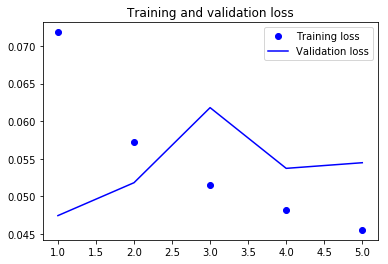

In [24]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
